# Investigating information processing in the anterior cingulate cortex
The anterior cingulate cortex is involved in outcome prediction; this is supported by evidence of encoding outcome valence. There is a distinct laterality to this effect, however. It remains unclear how the ACC communicates, and whether the ACC prediction network is affected by outcome valence, or if this is purely a unilateral effect.

We investigate communication between the anterior cingulate cortices & whether this communication is affected by the valence of outcome. This would be consistent with a model where the lACC encodes outcome valence, updating a bilateral prediction network to inform future decisions.

To do this, we will:
- Examine the data
- Analyse coherence between ACC recordings
- Analyse measures of information transfer

This approach can then be extended to examine other factors, such as the impact of novel stimuli, unexpected outcomes, etc., as outlined in $Weiss et al 2018$ (although the low sample sizes for these other measures may limit analysis)

Note that for the present analysis we will restrict our examination to the overall signal; in the absence of a specific prespecified hypothesis, systematic examination of all individual bands in all scenarios will only complicate matters by introducing a huge number of comparisons and making interpretation difficult. Exploratory analysis may be warranted depending on the outcomes of broadband analysis.

## Preparing for analysis
We will begin by loading the required libraries

In [522]:
# Import libraries
import numpy as np
import pandas as pd
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA, PCA
from statsmodels.tsa.stattools import grangercausalitytests
import pingouin as pg
from mne.viz import plot_connectivity_circle, circular_layout

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

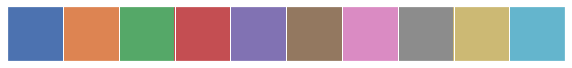

In [2]:
# Check plotting palette
colors = sns.color_palette()
sns.palplot(colors)

# Note can set figure size, etc. here using sns.set()

We will then import the data. Note that this data has been processed (using $ACCdataprep.m$) to prepare it for analysis here.

In [3]:
# Read in data 
df = pd.read_csv('ACCdata.csv')

# Examine data
df.head()

Time       L21       L32       L42       R65       R76       R87  \
0 -1000.000000  0.827081  1.595648 -1.349255  0.768563  0.115392 -2.290231   
1  -999.511719  0.808117  1.331159 -1.110086  0.826118  0.021592 -2.442664   
2  -999.023438  0.844883  0.812000 -0.632283  0.811667 -0.102224 -2.458007   
3  -998.535156  0.778317  0.282613 -0.001469  0.781021 -0.278869 -2.269550   
4  -998.046875  0.545140  0.024874  0.440941  0.730691 -0.443357 -1.978526   

   Outcome  Trial  Session  
0        0      1        1  
1        0      1        1  
2        0      1        1  
3        0      1        1  
4        0      1        1

Data is loaded & appears to be in appropriate format. We will change the "Outcome" column to make it more useful

In [4]:
# Convert "Outcome" to categorical
df["Outcome"] = df["Outcome"].astype("category")

# Change names to make easier to interpret
df["Outcome"].cat.categories = ["Incorrect", "Correct"]

# Check to make sure properly assigned
df["Outcome"].unique()

[Incorrect, Correct]
Categories (2, object): [Incorrect, Correct]

We now have all trials tagged by $Correct$ or $Incorrect$. Our data is now ready to start analysing - but first we will examine it & make sure it looks OK

## Examining data
We need to make sure the data is ready to analyse & there aren't any unexpected features that might mess things up.

Specifically, I'm concerned re. filtering here. I'm not clear on whether this data has already been preprocessed at all. Weiss et al. 2018 prepared the data by baseline correcting & normalising to unit variance and by applying a 50Hz notch filter. Both of these are important steps, but we need to know whether out data has had these done to avoid not doing them or re-filtering inappopriately.

We can then perform some simple visualisations to get a feel for how the data behaves under different conditions.

In [6]:
# Examine data characteristics
df.describe()

Time           L21           L32           L42           R65  \
count  3.306279e+06  3.306279e+06  3.306279e+06  3.306279e+06  3.306279e+06   
mean   0.000000e+00 -1.874841e-02 -6.944624e-03 -5.764332e-02 -5.092068e-02   
std    5.774913e+02  1.041400e+00  1.039533e+00  1.023519e+00  1.670295e+00   
min   -1.000000e+03 -1.319742e+01 -1.002916e+01 -5.578338e+00 -7.233013e+01   
25%   -5.000000e+02 -7.109168e-01 -6.614392e-01 -7.423851e-01 -7.010460e-01   
50%    0.000000e+00 -3.031829e-02 -2.605061e-02 -4.886363e-02 -3.333394e-02   
75%    5.000000e+02  6.612796e-01  6.156844e-01  6.391986e-01  6.302450e-01   
max    1.000000e+03  1.549192e+01  2.224115e+01  4.887251e+00  6.637271e+01   

                R76           R87         Trial       Session  
count  3.306279e+06  3.306279e+06  3.306279e+06  3.306279e+06  
mean   2.322342e-02 -3.377735e-02  4.040000e+02  4.991326e+00  
std    1.007399e+00  9.935553e-01  2.329607e+02  2.566330e+00  
min   -2.999169e+01 -7.191499e+01  1.000000e+00  1.000000e+00  
25%   -6.026739e-01 -6.517606e-01  2.020000e+02  3.000000e+00  
50%    1.288719e-02 -3.658857e-02  4.040000e+02  5.000000e+00  
75%    6.358202e-01  5.787413e-01  6.060000e+02  7.000000e+00  
max    3.457973e+01  6.395917e+01  8.070000e+02  9.000000e+00

The broad summary statistics look OK; notably, the mean of all of the electrode channels is around 0.

We will take a closer look just to be sure.

In [5]:
# Create list of electrodes
electrodes = ['L21', 'L32', 'L42', 'R65', 'R76', 'R87']

# Cycle through electrodes & print mean and standard deviation of each
def checkElectrodeStatistics(): # Defining as function so we can repeat if necessary
    for elec in electrodes:
    #    print("Electrode {0}: Mean {1], SD {2}".format(elec, df[elec].mean(), df[elec].std()
        print('Electrode {0}: Mean {1}, SD {2}'.format(elec, df[elec].mean(), df[elec].std()))
    
        
checkElectrodeStatistics()

Electrode L21: Mean -0.018748407910754564, SD 1.041399740651586
Electrode L32: Mean -0.006944623501870101, SD 1.0395334828580913
Electrode L42: Mean -0.05764332345143555, SD 1.0235186449287401
Electrode R65: Mean -0.05092067569378579, SD 1.6702952335390793
Electrode R76: Mean 0.023223415539787563, SD 1.0073992304581323
Electrode R87: Mean -0.03377735269711016, SD 0.9935552816994514


It looks like our electrodes are all close to 0 mean and unit variance.

The slight variation from 0 / 1 is likely due to me taking shorter epochs than those it was filtered over & possible effects if it was filtered over trials vs. sessions vs. all data
We may revisit this depending on how the rest of the data looks.

We will now examine the data to make sure it looks acceptable.

In [6]:
# Re-index data by trial & time; we can then aggregate data across all channels & plot amplitude and spectrum of mean signal, averaged around feedback
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'], aggfunc=np.mean)

# Examine data = we should have the average across trials for each electrode
allChannels

L21       L32       L42       R65       R76       R87
Trial Time                                                                    
1     -1000.000000  0.827081  1.595648 -1.349255  0.768563  0.115392 -2.290231
      -999.511719   0.808117  1.331159 -1.110086  0.826118  0.021592 -2.442664
      -999.023438   0.844883  0.812000 -0.632283  0.811667 -0.102224 -2.458007
      -998.535156   0.778317  0.282613 -0.001469  0.781021 -0.278869 -2.269550
      -998.046875   0.545140  0.024874  0.440941  0.730691 -0.443357 -1.978526
...                      ...       ...       ...       ...       ...       ...
807    998.046875  -2.005117 -0.329824  0.525105 -1.572872 -0.742944  0.247545
       998.535156  -1.979570 -0.379362  0.503901 -1.549664 -0.696024  0.211498
       999.023438  -1.952617 -0.428916  0.481523 -1.528337 -0.650459  0.173841
       999.511719  -1.924526 -0.478196  0.458069 -1.509216 -0.606636  0.134382
       1000.000000 -1.895564 -0.526915  0.433640 -1.492624 -0.564942  0.092930

[3306279 rows x 6 columns]

Good - we now have our data indexed by trial, and each trial indexed by time.
We can then process data by trials, or average across trials, etc. for each electrode; in all cases, data is indexed by time (in ms), where 0 is feedback by averaging across trials.

Note that we can come back & use Sessions to split by session, by participant, etc. if necessary.

We will start by visualising the average across trials for each channel.

Text(0.5, 1.0, 'Average response for each electrode')

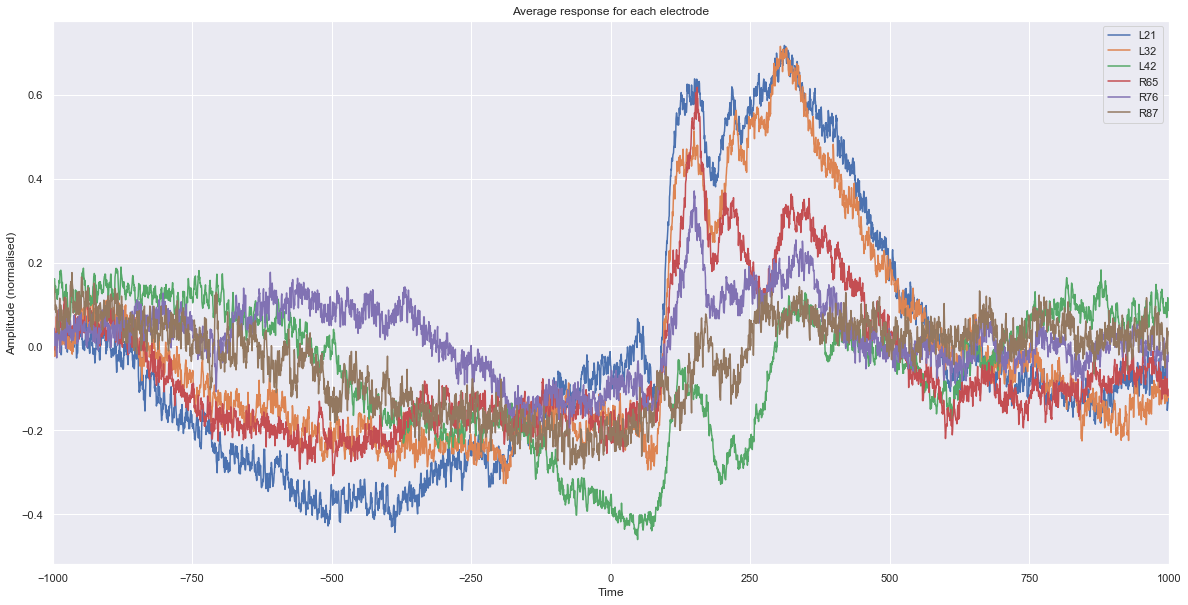

In [145]:
# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

fig, ax = plt.subplots(figsize=(20,10))
allChannels_averaged.plot(ax=ax)
ax.set_ylabel('Amplitude (normalised)')
ax.set_title('Average response for each electrode')

The data looks good. We can see that there is a response across all electrodes following feedback (time = 0). We won't analyse this too much now, rather we will start from averages of all channels and gradually build back up to the level of individual channels so we can build up a sense of how the system is behaving. On immediate inspectionhowever, we can see that the feedback response is domination by two electrodes, L21 and L32, both on the left side, cosistent with a lateralised effect. Interestingly, L42, the other left-sided recording, shows a response with a distinct morphology, suggesting that different areas within the ACC may encode different information and play different roles within our hypothesised ACC prediction network. Additionally, we can see a sharper, later response in the right-sided electrodes, suggesting a response with higher frequency components, possibly in response to information from the left side. Further, we can see a "propagation" of this spike along the areas recorded by R65, R76 and R87, again consistent with a communicating network of areas responding to outcome & making predictions. Note that this suggestion of distinct areas performing different roles in a prediction network is consistent with Weiss et al.'s results, showing improved performance of a linear discriminant analysis when applied to all electrodes compared to averaged lateralised responses, indicating that individual electrodes are recording areas that are encoding distinct information.

We will begin by examining the data to ensure there are no major issues & to get a sense for how it is behaving. To start, we will look at each electrode separately.

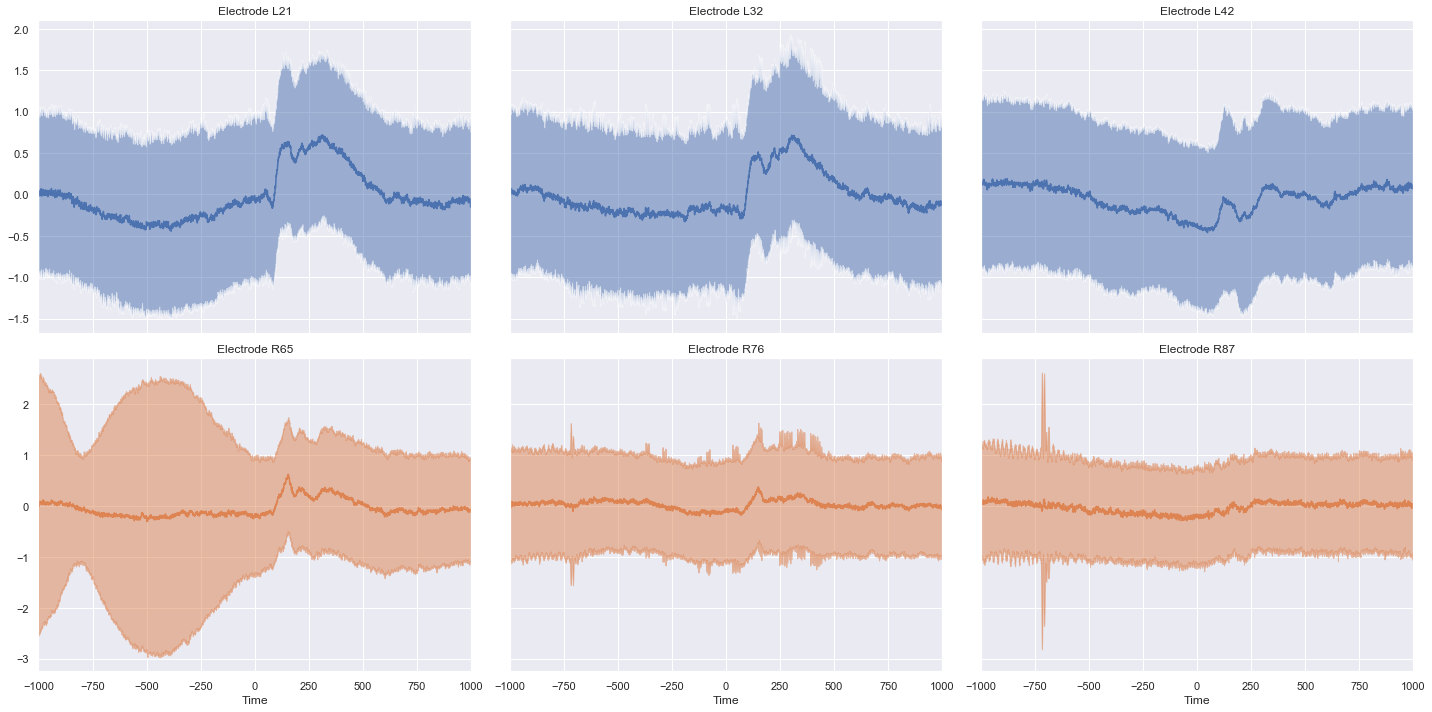

In [7]:
# Create list of electrodes on each side
electrodesLeft = ['L21', 'L32', 'L42']
electrodesRight = ['R65', 'R76', 'R87']

# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    # Get average for current channel across trials
    leftMean = allChannels[left].groupby('Time').mean()
    leftSD = allChannels[left].groupby('Time').std()
    
    rightMean = allChannels[right].groupby('Time').mean()
    rightSD = allChannels[right].groupby('Time').std()
    
    leftMean.plot(ax=ax[0,i])
    ax[0,i].fill_between(leftMean.index, leftMean + leftSD, leftMean - leftSD, alpha=0.5)
    ax[0,i].set_title('Electrode {}'.format(left))
    
    rightMean.plot(ax=ax[1,i], color=colors[1])
    ax[1,i].fill_between(rightMean.index, rightMean + rightSD, rightMean - rightSD, color=colors[1], alpha=0.5)
    ax[1,i].set_title('Electrode {}'.format(right))
     
fig.tight_layout()

We can now see the average responses & variance at each electrode. There are evidently differences in the response to feedback between electrodes. Notably, L21 and L32 show similar responses, while L42 shows a different morphology. The right sided electrodes show a damped, delayed response, with a progress increase in delay to peak from R65 to R76 to R87, suggesting a propagating response within the right ACC, supporting the activity of a network.

Looking at the variance, we see that there is a lot of variation between trials for each electrode. This is to be expected for these kinds of recordings. Most notably, the shape of R65's variance suggests that it may be contaminated. We will take a look at this electrode across all trials.

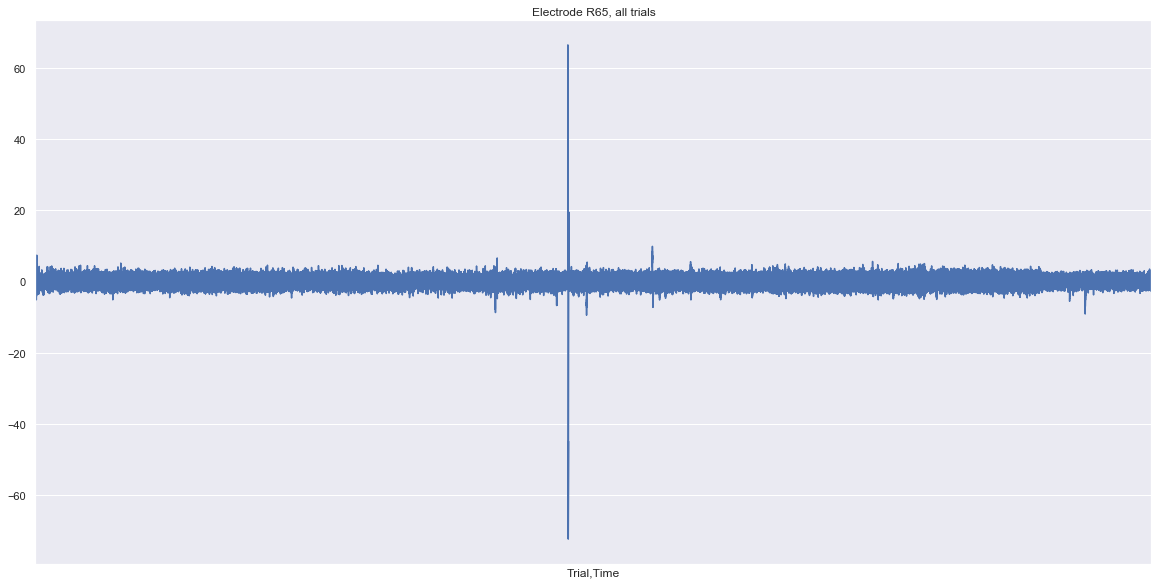

In [215]:
allChannels.R65.plot(figsize=(20,10), title='Electrode R65, all trials', xticks=[])

As suspected, part of the recording is clearly contaminated by an artefact an order of magnitude greater than the rest of the recording - we will need to correct this.

First we will find the affected trial

386

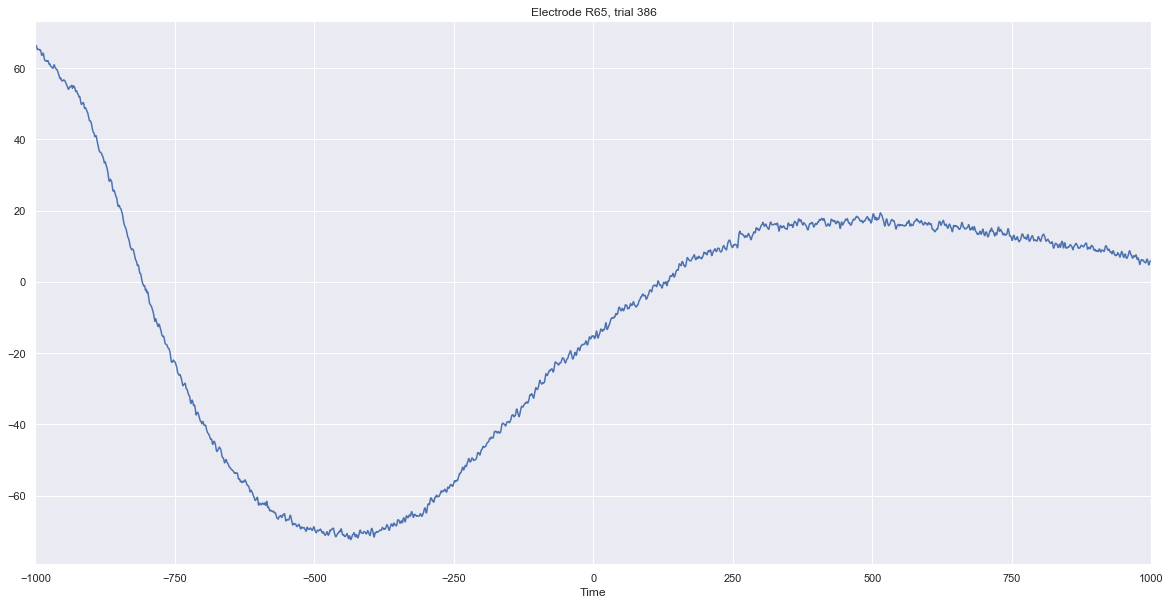

In [214]:
# Find trial containing highest value
index, _ = allChannels.R65.idxmax()

# Plot this trial
allChannels.R65[index].plot(figsize=(20,10), title='Electrode R65, trial {}'.format(index))

Trial 386 on electrode R65 has been contaminated. It's unlikely we can recover much of use from this. We can remove this trial & replace it with the mean of responses on this electrode so the artefact does not impact analyses. 

We will then examine all electrodes at this trial to see if they are also affected.

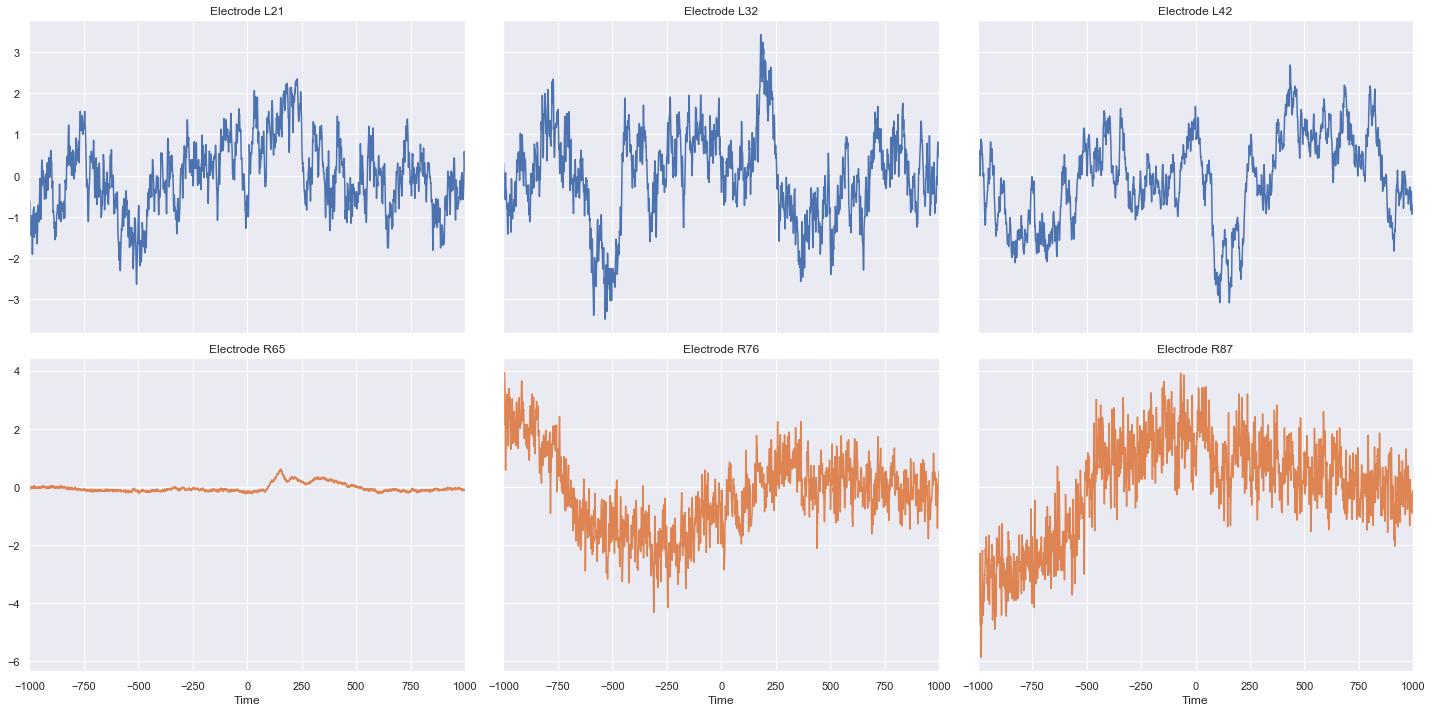

In [229]:
# Replace trial 386 for electrode R65 with the mean of all other trials
allChannels.R65[386] = allChannels.R65.drop(386).groupby('Time').mean()

# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    allChannels[left][index].plot(ax=ax[0,i], title='Electrode {}'.format(left))
    allChannels[right][index].plot(ax=ax[1,i], title='Electrode {}'.format(right), color=colors[1])
     
fig.tight_layout()

The recording of trial 386 at electrode R65 has been replaced by the mean of all other recordings at that electrode. The other electrodes do not seem to be as dramatically affected.

To be sure that there are no other significantly contaminated trials, we will visualise the full recordings for all electrodes.

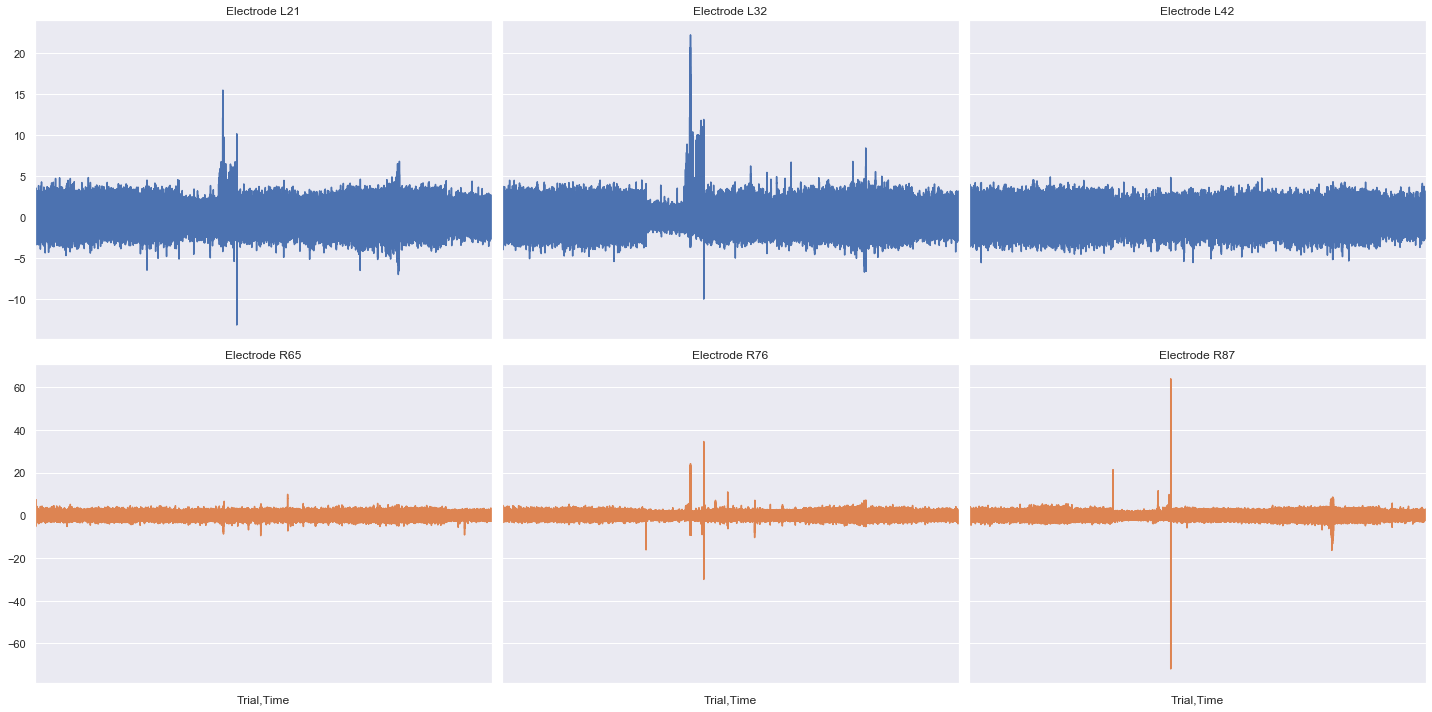

In [230]:
# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot all data
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    allChannels[left].plot(ax=ax[0,i], title='Electrode {}'.format(left), xticks=[])
    allChannels[right].plot(ax=ax[1,i], title='Electrode {}'.format(right), color=colors[1], xticks=[])
     
fig.tight_layout()

R65 looks a lot better, but it looks like there's actually a fair amount of contamination here. We'll need to do a bit of proper preprocessing before we continue.

## Preprocessing

We will aim to:
- Baseline correct every individual trial
- Identify all trials with a value > 2 standard deviations from mean
- Replace bad trials with mean of all unaffected trials at that electrode

First we will look to see if we need to apply a notch filter at 50Hz, as we can do that at the same time if we need to.

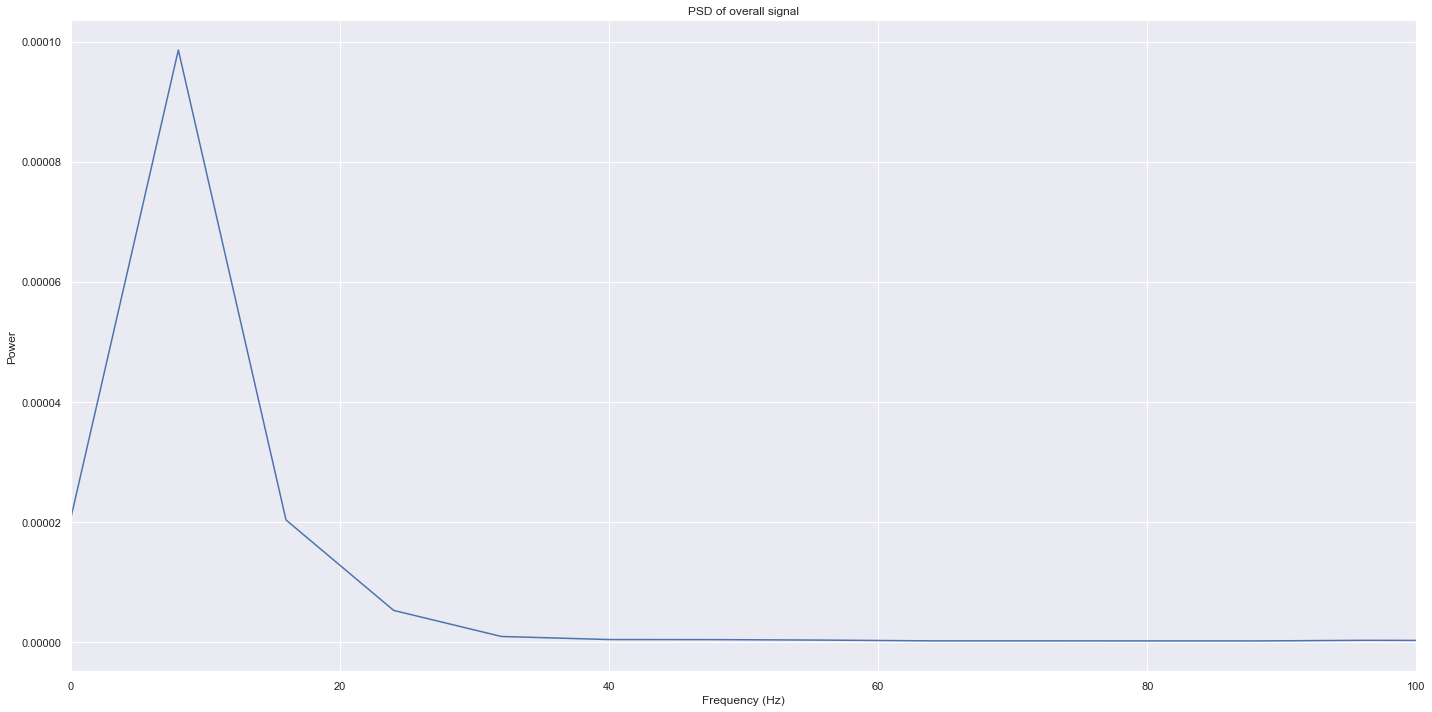

In [8]:
# Get all channels from raw data (ignore previous processing; process all trials systematically)
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'], aggfunc=np.mean)

# Plot PSD of average signal across all electrodes, across all trials to see if there is a 50Hz spike corresponding to AC noise
allChannels_averaged = allChannels.groupby('Time').mean()
allChannels_mean = allChannels_averaged.mean(axis=1)

# Get power spectral density of signal
freqs, psd = signal.welch(allChannels_mean, fs=2048)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(freqs, psd)
ax.set_title('PSD of overall signal')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_xlim([0, 100])
fig.tight_layout()

Most of the data's spectral power is in the 0 - 20Hz band, and there does not appear to be any spike representing 50Hz noise. This suggests that a 50Hz notch filter has already been applied. We will not do any more filtering at this stage.

We will now carry out preprocessing.

In [9]:
# Cycle through each electrode; within each, cycle through each trial
# Baseline correct trial
# Identigy all trials outside 3 standard deviations of mean
# Add to list of bad trials
# Then: cycle through bad trials; for each, replace by mean of all non-bad trials
# Then visudalise all recordings, then average of cleaned-up data

# Note since amplitude normalised, cut get SD of trials & remove any trials with abnormally high SD as alternative

# Create copy of channels to apply preprocessing to
allChannels_preprocessed = allChannels;

# Cycle through each electrode
for elec in electrodes:
    badtrials = [] # List of corrupted trials to replace
    # Cycle through each trial
    for trial in df.Trial.unique():
        # Baseline correct all individual trials
        allChannels_preprocessed[elec][trial] = allChannels[elec][trial] - allChannels[elec][trial].mean()
        
        if allChannels[elec][trial].max() > allChannels[elec].mean() + 5*allChannels[elec].std() or allChannels[elec][trial].min() < allChannels[elec].mean() - 5*allChannels[elec].std():
            badtrials.append(trial)
    
    # Cycle through bad trials & replace each
    for trial in badtrials:
        # Replace bad trial with mean of all non-bad trials
        allChannels_preprocessed[elec][trial] = allChannels[elec].drop(badtrials).groupby('Time').mean()
        
    print('Electrode {0}: {1} bad trials replaced'.format(elec, len(badtrials)))

Electrode L21: 36 bad trials replaced
Electrode L32: 36 bad trials replaced
Electrode L42: 4 bad trials replaced
Electrode R65: 4 bad trials replaced
Electrode R76: 21 bad trials replaced
Electrode R87: 30 bad trials replaced


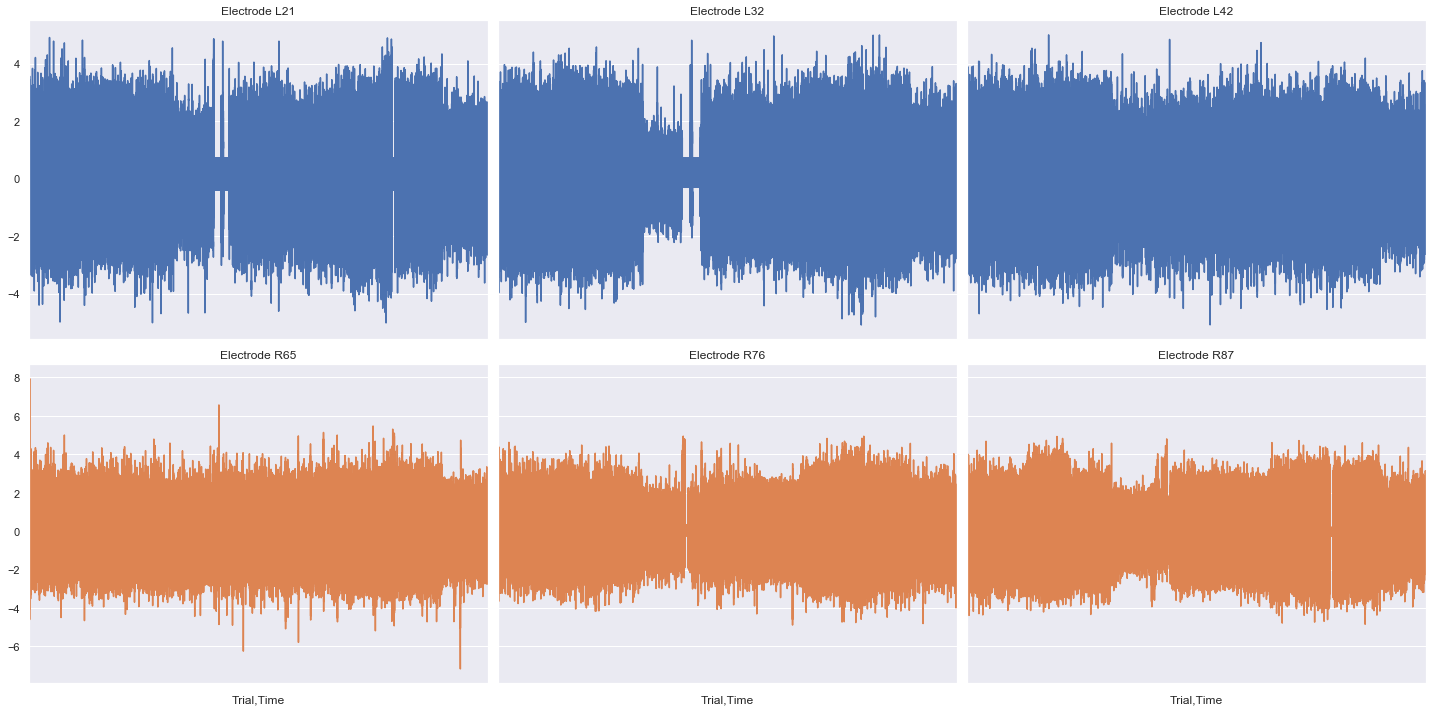

In [10]:
# Visualise the cleaned up recordings
# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    allChannels_preprocessed[left].plot(ax=ax[0,i], title='Electrode {}'.format(left), xticks=[])
    allChannels_preprocessed[right].plot(ax=ax[1,i], title='Electrode {}'.format(right), color=colors[1], xticks=[])
     
fig.tight_layout()

This is much cleaner! We have removed the large contaminated sections from the data. We will now take a look at the average responses for each electrode on the cleaned up data

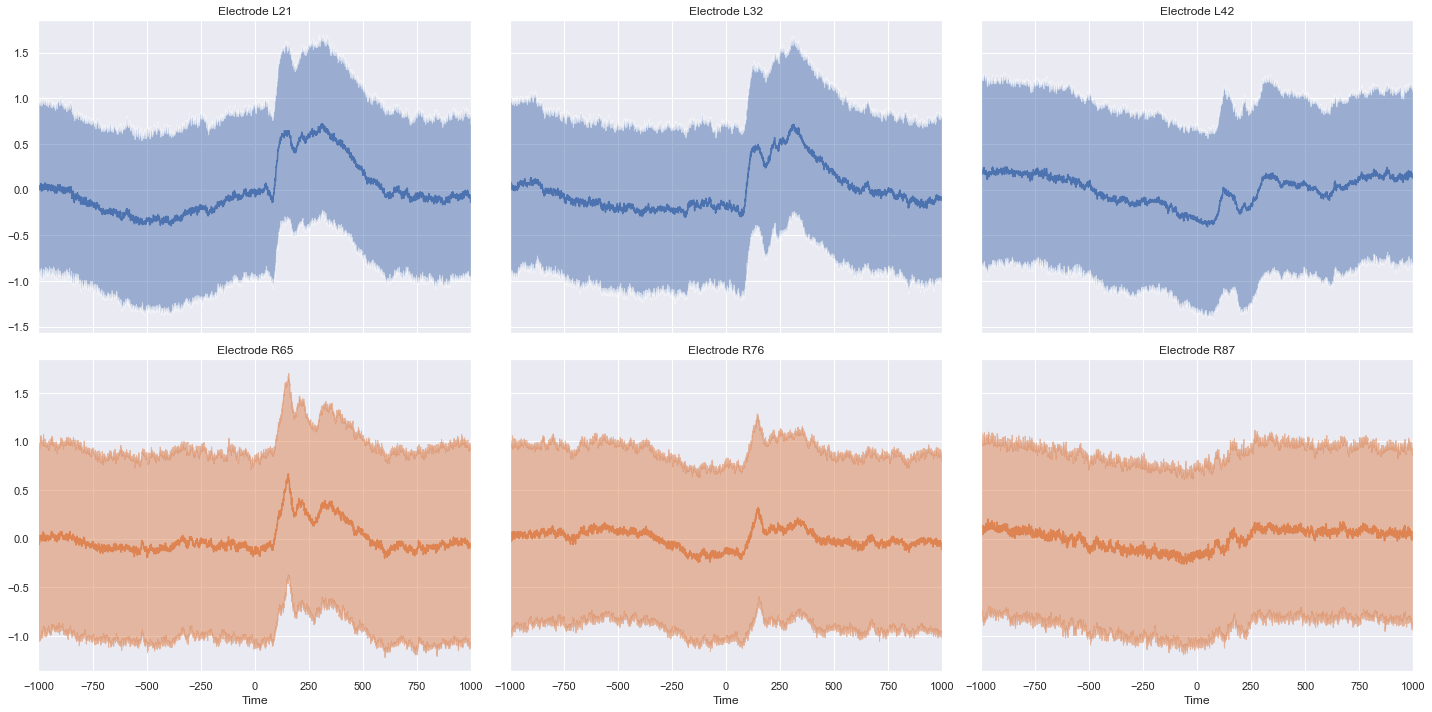

In [266]:
# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    # Get average for current channel across trials
    leftMean = allChannels_preprocessed[left].groupby('Time').mean()
    leftSD = allChannels_preprocessed[left].groupby('Time').std()
    
    rightMean = allChannels_preprocessed[right].groupby('Time').mean()
    rightSD = allChannels_preprocessed[right].groupby('Time').std()
    
    leftMean.plot(ax=ax[0,i])
    ax[0,i].fill_between(leftMean.index, leftMean + leftSD, leftMean - leftSD, alpha=0.5)
    ax[0,i].set_title('Electrode {}'.format(left))
    
    rightMean.plot(ax=ax[1,i], color=colors[1])
    ax[1,i].fill_between(rightMean.index, rightMean + rightSD, rightMean - rightSD, color=colors[1], alpha=0.5)
    ax[1,i].set_title('Electrode {}'.format(right))
     
fig.tight_layout()

Our data definitely looks a lot cleaner here; we haven't affected the morphology of the average response, but the bounds are tigher now.

We will use this preprocessed data to explore the data further.

In [11]:
# Maintain raw data as df_raw, and assign preprocessed data into df to use for analysis
df_raw = df

for elec in electrodes:
    df[elec] = allChannels_preprocessed.reset_index()[elec]
    
df.head()

Time       L21       L32       L42       R65       R76       R87  \
0 -1000.000000  0.834717  1.649313 -1.434706  1.338858 -0.169881 -2.339065   
1  -999.511719  0.815754  1.384824 -1.195536  1.396413 -0.263681 -2.491498   
2  -999.023438  0.852520  0.865664 -0.717733  1.381962 -0.387497 -2.506842   
3  -998.535156  0.785953  0.336277 -0.086919  1.351316 -0.564142 -2.318385   
4  -998.046875  0.552777  0.078538  0.355491  1.300986 -0.728630 -2.027361   

     Outcome  Trial  Session  
0  Incorrect      1        1  
1  Incorrect      1        1  
2  Incorrect      1        1  
3  Incorrect      1        1  
4  Incorrect      1        1

## Exploring the data
We will come back to more detailed analysis at the individual electrode level. For now, we will build up our analysis from the average of all channels to get a good understanding for how the ACC is responding to feedback.

Text(0.5, 1.0, 'Average response across all electrodes')

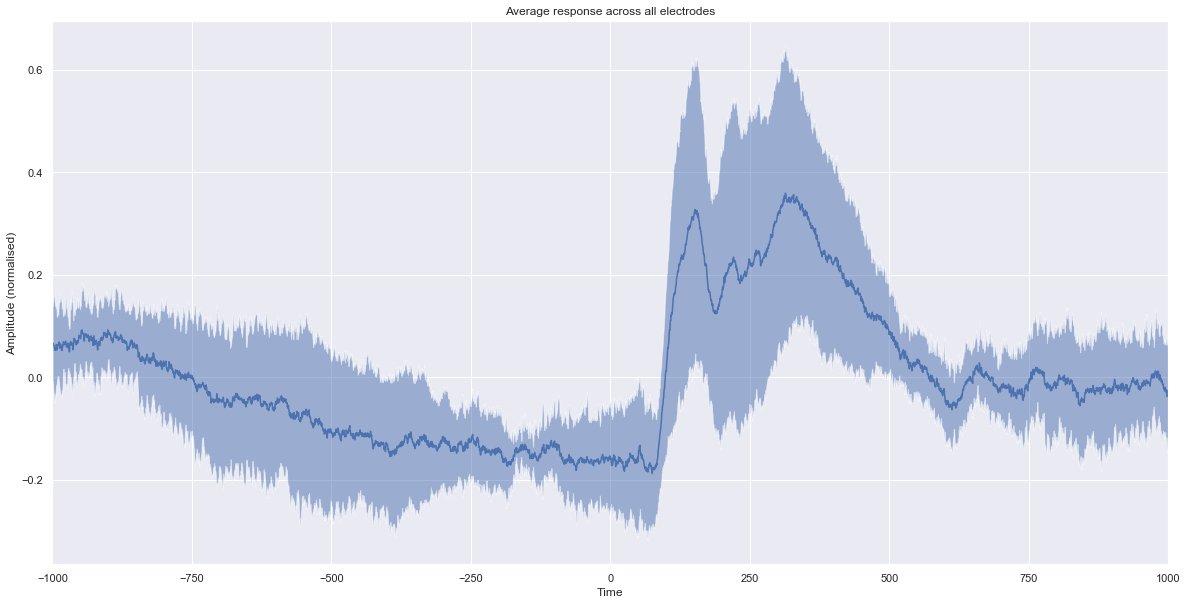

In [275]:
# Get channel data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'], aggfunc=np.mean)

# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

# Average across channels
allChannels_averagedMean = allChannels_averaged.mean(axis=1)
allChannels_averagedSD = allChannels_averaged.std(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
allChannels_averagedMean.plot(ax=ax)
ax.fill_between(df.Time.unique(), allChannels_averagedMean + allChannels_averagedSD, allChannels_averagedMean - allChannels_averagedSD, alpha=0.5)
ax.set_ylabel('Amplitude (normalised)')
ax.set_title('Average response across all electrodes')

Looks good. There's quite a clear response across all electrodes after feedback. Weiss et al. indicated that "encoding" of valence mostly occurred at 200 to 400ms after feedback, which is consistent with what we're seeing here. There's a lot of variability within that 200 - 400ms window, consistent with what we saw in the plots of individual electrodes, but there is a clear response in all electrodes. This supports the notion of multiple areas within the ACC responding differently as part of a prediction network. Note also the immediate response to feedback at about 100ms: the variance tightens up massively here, indicating a consistent response to feedback across all electrodes.

Particularly noteworthy here is the period about 200ms BEFORE feedback. Although there is not a very large amplitude response, notice that the variance suddenly tightens up hugely. This suggests some synchronisation across all electrode areas. Given the period immediately pre-feedback, this is likely to represent our hypothesised ACC prediction network "anticipating" feedback and priming itself to respond.

We can zoom in a bit and have a closer look at that 200 - 400ms response.

Text(0, 0.5, 'Amplitude (normalised)')

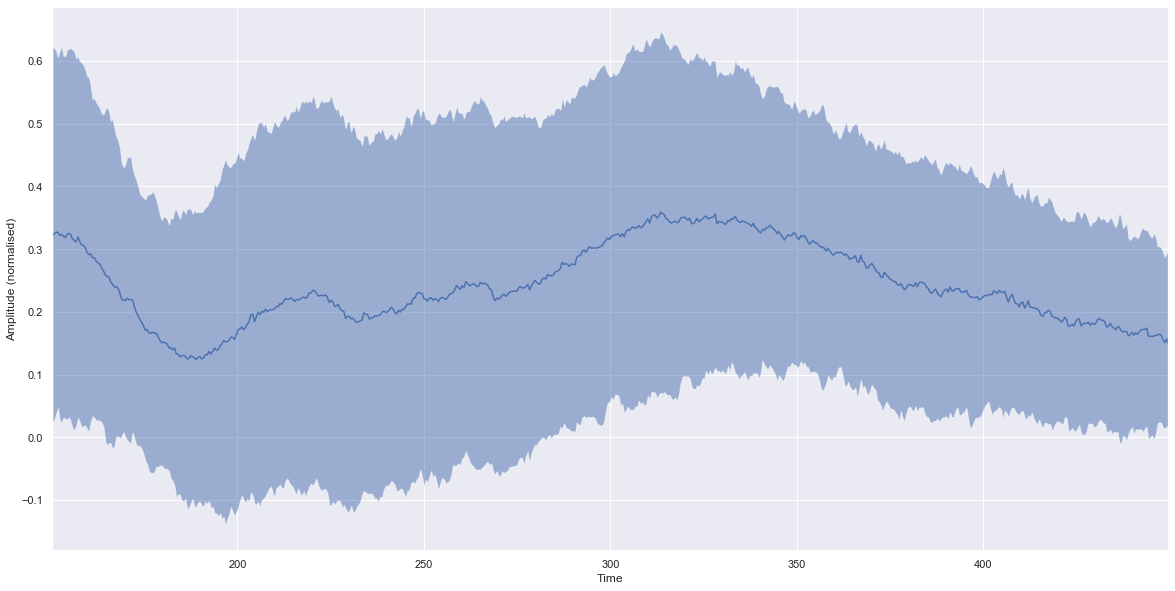

In [276]:
# Plot between 200 and 400ms after feedback
fig, ax = plt.subplots(figsize = (20, 10))
ax = allChannels_averagedMean[150:450].plot()
ax.fill_between(allChannels_averagedMean[150:450].index, allChannels_averagedMean[150:450] + allChannels_averagedSD[150:450], allChannels_averagedMean[150:450] - allChannels_averagedSD[150:450], alpha=0.5)
ax.set_ylabel('Amplitude (normalised)')

These double peaks (at just after 200ms and 300 - 400ms) likely correspond to the peaks in valence encoding described by the linear discriminant analysis described in Weiss et al. We can later revisit this and examine this between sides & individual electrodes, then look at whether it differs according to trial outcome.

First, we will examine the spectrum of the overall signal.

Specifically, we will look at the power spectral density & phase for all frequencies.

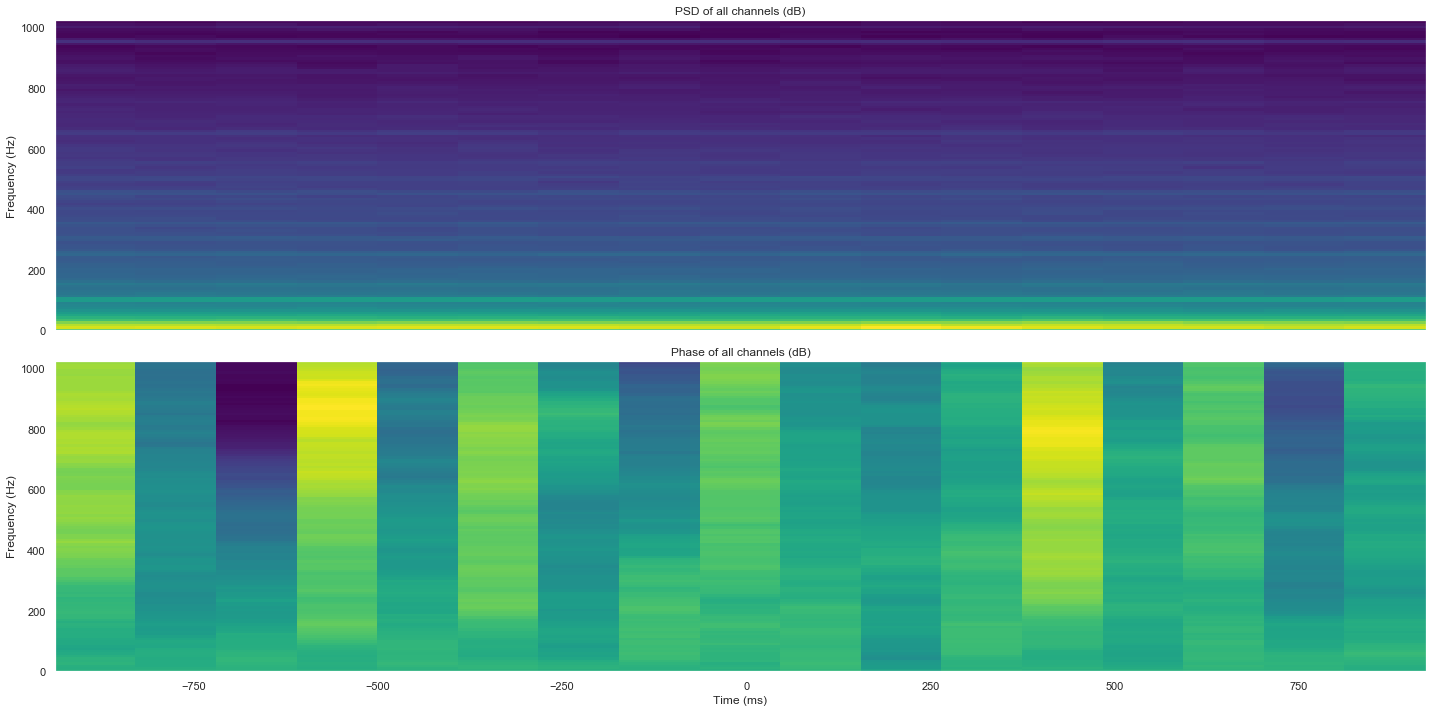

In [277]:
# Get data for all channels, indexed by trial and time
allChannels = pd.pivot_table(df, values=electrodes, index=['Trial', 'Time'])

# Average across electrodes, indexed by trial & time
allChannels_averaged = allChannels.mean(axis=1)

# Get spectrogram for each trial & average these
# Note getting average spectrogram rather than spectrogram of average - latter results in loss of information
PSDs = [] # Empty list for storing PSDs
Phases = [] # Empty list for storing phases
for trial in df.Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, Sxx = signal.spectrogram(allChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, phaseTrial = signal.spectrogram(allChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    # Add PSD & phase to list
    PSDs.append(Sxx)
    Phases.append(phaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials

# Get average psd & phase
psd = np.mean(PSDs, axis=0)
phase = np.mean(Phases, axis=0)

# Convert times to ms, centred on feedback
times = (times - 1) * 1000

# Create plot
fig, ax = plt.subplots(2,1, sharex='col', figsize = (20, 10));
ax[0].pcolormesh(times, freqs, 10*np.log10(psd), cmap='viridis') # Convert to dB
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('PSD of all channels (dB)')

ax[1].pcolormesh(times, freqs, phase, cmap='viridis')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Phase of all channels (dB)')

fig.tight_layout()

As is predictable, there is very little activity above the very low end of the spectrum, and it is hard to appreciate much here. We will therefore "zoom in" on the frequency range of interest & look at this along with the time series. Note however that there are some bursts of high-frequency activity at around 200Hz in the period immediately after feedback and at 200 - 400ms. Additionally, if we look at the phase plot we can see cphrence across all frequency bands from about 200 - 400ms, again indicating a coordinated response of the ACC to feedback within this period.

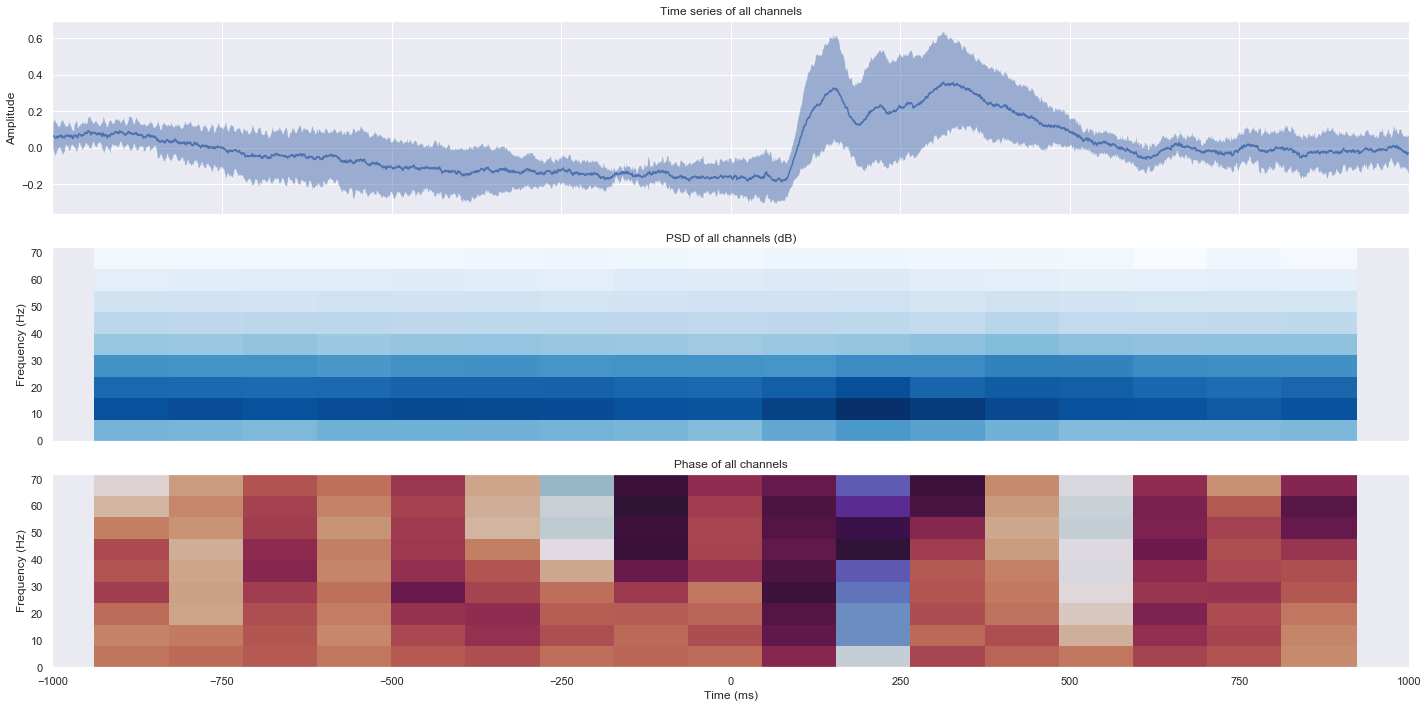

In [570]:
# Create plot: time series / PSD / phase
fig, ax = plt.subplots(3,1, sharex='col', figsize=(20, 10));

allChannels_averagedMean.plot(ax=ax[0])
ax[0].fill_between(allChannels_averagedMean.index, allChannels_averagedMean + allChannels_averagedSD, allChannels_averagedMean - allChannels_averagedSD, alpha=0.5)
ax[0].set_title('Time series of all channels')
ax[0].set_ylabel('Amplitude')

ax[1].pcolormesh(times, freqs[:10], 10*np.log10(psd[:10]), cmap='Blues')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('PSD of all channels (dB)')

ax[2].pcolormesh(times, freqs[:10], phase[:10], cmap='twilight_shifted')
ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_title('Phase of all channels')
ax[2].set_xlabel('Time (ms)')

fig.tight_layout()

So the response we saw on the time series at 200 - 400ms is also seen on the spectrogram as an increase in spectral power in the sub-20Hz range, particularly in the 10-20Hz range. At the same time as this spike in amplitude, we see that the phase across all frequency bands becomes coherent; this is maintained until about 500ms adn then lost, corresponding to the length of the average response seen. Note this is consistent with the idea that "evoked responses" (i.e. trial-averaged responses to some event) are associated with "phase-resetting", resulting in coherent signals in the period after the response.

Let's repeat the same visualisation, this time looking at that 200 - 400ms range we looked at earlier.

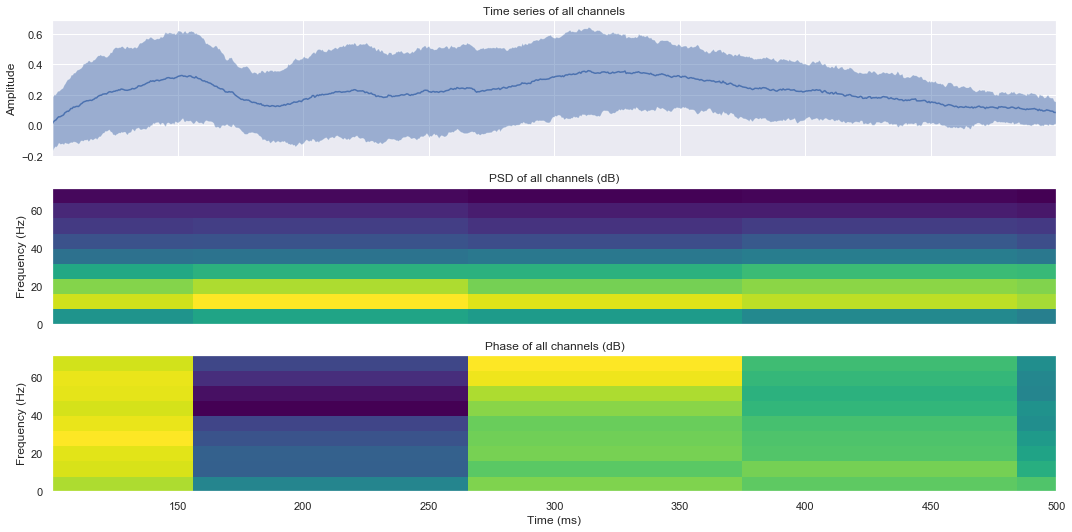

In [279]:
# Create plot: time series / PSD / phase
fig, ax = plt.subplots(3,1, sharex='col', figsize=(15, 7.5));

allChannels_averagedMean[100:500].plot(ax=ax[0])
ax[0].fill_between(allChannels_averagedMean[100:500].index, allChannels_averagedMean[100:500] + allChannels_averagedSD[100:500], allChannels_averagedMean[100:500] - allChannels_averagedSD[100:500], alpha=0.5)
ax[0].set_title('Time series of all channels')
ax[0].set_ylabel('Amplitude')

ax[1].pcolormesh(times[9:15], freqs[:10], 10*np.log10(psd[:10, 9:15]), cmap='viridis')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('PSD of all channels (dB)')

ax[2].pcolormesh(times[9:15], freqs[:10], phase[:10, 9:15], cmap='viridis')
ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_title('Phase of all channels (dB)')
ax[2].set_xlabel('Time (ms)')

fig.tight_layout()

Nothing substantially new here: a spike in activity at sub-20Hz and coherence across frequency bands at 200 - 400ms, consistent with the ACC responding to feedback during this period.

Next, we will have a look at lateralising effects: we will repeat the same visualisations, this time comparing the average of all electrodes on the left vs. the average of all electrodes on the right. This will give us a feeling for how each side responds to feedback, and we can then start looking at individual electrodes & more complex analyses.

Text(0, 0.5, 'Amplitude (normalised)')

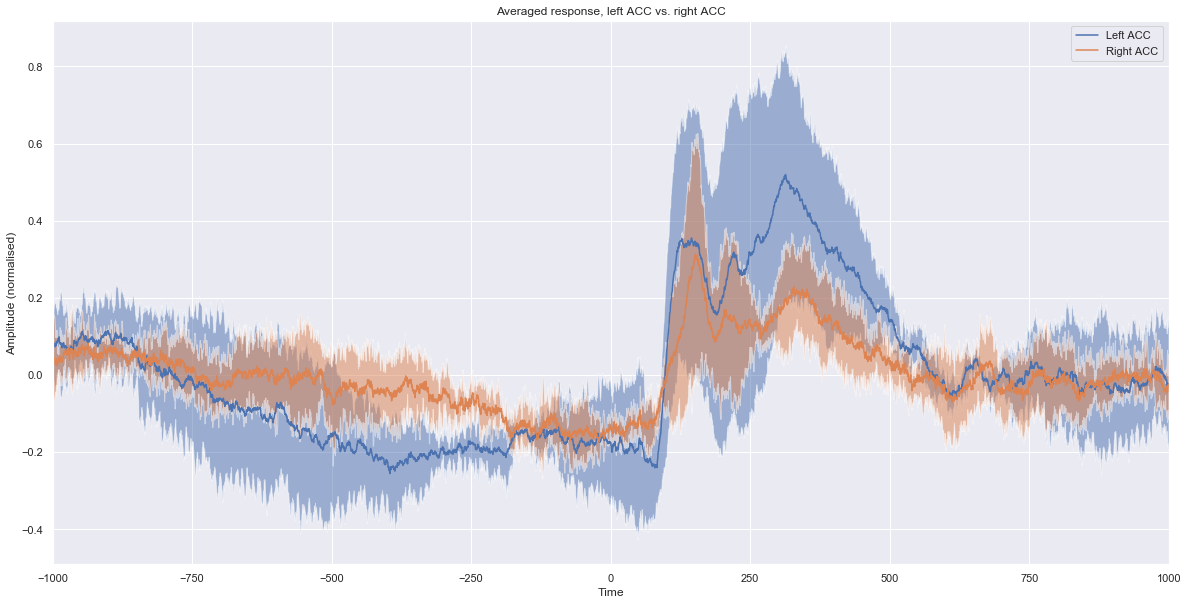

In [738]:
# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
leftChannels_averaged = leftChannels.groupby('Time').mean() # Mean of each electrode on left across trials
rightChannels_averaged = rightChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
leftChannels_mean = leftChannels_averaged.mean(axis=1)
leftChannels_SD = leftChannels_averaged.std(axis=1)

rightChannels_mean = rightChannels_averaged.mean(axis=1)
rightChannels_SD = rightChannels_averaged.std(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
leftChannels_mean.plot(ax=ax)
ax.fill_between(leftChannels_mean.index, leftChannels_mean+leftChannels_SD, leftChannels_mean-leftChannels_SD, alpha=0.5)

rightChannels_mean.plot(ax=ax)
ax.fill_between(rightChannels_mean.index, rightChannels_mean+rightChannels_SD, rightChannels_mean-rightChannels_SD, alpha=0.5)

ax.legend(['Left ACC', 'Right ACC'])
ax.set_title('Averaged response, left ACC vs. right ACC')
ax.set_ylabel('Amplitude (normalised)')

Getting more interesting now. We can see that both sides respond to feedback, with the double-peak response we saw in the overall average. Interestingly, we can see by direct inspection that the response in the left ACC is greater in amplitude and occurs earlier. Similarly, we see that the pre-stimulus "anticipation" occurs bilaterally, with right lagging slightly after left. We can zoom in to have a look at these responses more closely.

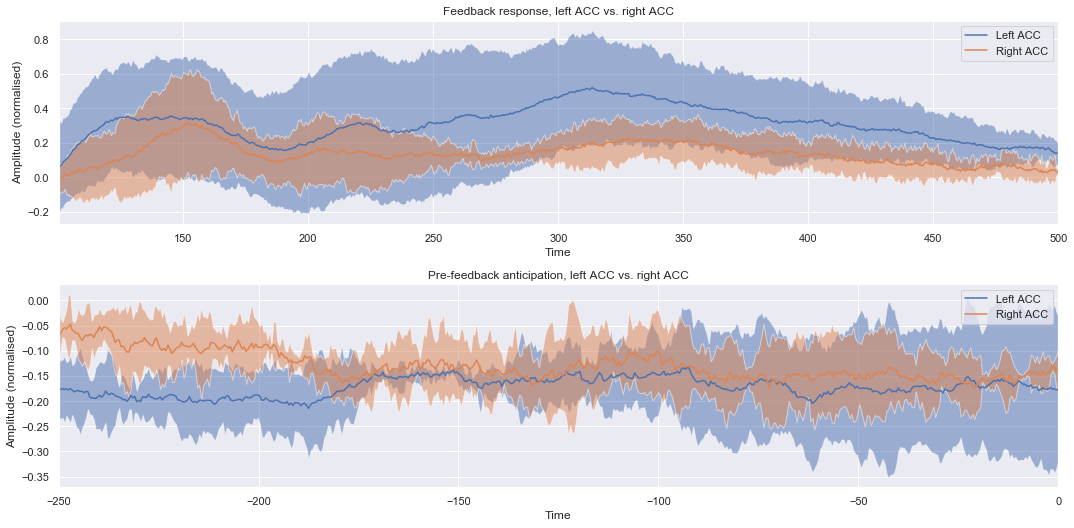

In [739]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7.5))

# Post-stimulus response
leftChannels_mean[100:500].plot(ax=ax[0])
ax[0].fill_between(leftChannels_mean[100:500].index, leftChannels_mean[100:500]+leftChannels_SD[100:500], leftChannels_mean[100:500]-leftChannels_SD[100:500], alpha=0.5)

rightChannels_mean[100:500].plot(ax=ax[0])
ax[0].fill_between(rightChannels_mean[100:500].index, rightChannels_mean[100:500]+rightChannels_SD[100:500], rightChannels_mean[100:500]-rightChannels_SD[100:500], alpha=0.5)

ax[0].legend(['Left ACC', 'Right ACC'])
ax[0].set_title('Feedback response, left ACC vs. right ACC')
ax[0].set_ylabel('Amplitude (normalised)')

# Pre-stimulus anticipation
leftChannels_mean[-250:0].plot(ax=ax[1])
ax[1].fill_between(leftChannels_mean[-250:0].index, leftChannels_mean[-250:0]+leftChannels_SD[-250:0], leftChannels_mean[-250:0]-leftChannels_SD[-250:0], alpha=0.5)

rightChannels_mean[-250:0].plot(ax=ax[1])
ax[1].fill_between(rightChannels_mean[-250:0].index, rightChannels_mean[-250:0]+rightChannels_SD[-250:0], rightChannels_mean[-250:0]-rightChannels_SD[-250:0], alpha=0.5)

ax[1].legend(['Left ACC', 'Right ACC'])
ax[1].set_title('Pre-feedback anticipation, left ACC vs. right ACC')
ax[1].set_ylabel('Amplitude (normalised)')

fig.tight_layout()

On inspection of the average of left and right ACC responses in the period following feedback, we see that there is an early response in the left ACC at roughly 100ms - slightly sooner than expected from Weiss et al.'s linear discriminant analysis, but may not be "encoding" valence in the same way as later responses. This is followed by a sustained plateau of activity on the left, with a slightly delayed peak on the right at about 150ms. We see a similar patter later, with a peak on the left, with a damped and delayed peak on the right. These peaks are preceded by a notable loss of variance on the right at about 275ms, indicating a consistent response at this point. This may be suggestive of "communication" between anterior cingulate cortices, with the left side providing an initial response, and the right responding to whatever is encoded by the left (e.g. updating prediction models to account for response valence). This pattern would certainly be consistent with our hypothesis of a "network" containing the ACC bilaterally which encodes valence & communicates between ACCs to update and maintain a prediction model. We will see later whether this varies with valence & if there is any stronger evidence of communication to support this idea of an ACC prediction network.

Similarly, on examination of the pre-feedback period we marked reduction in variance at roughly -170 to -150ms. As above, this is suggestive of "preparation" of an ACC prediction network for feedback through a consistent pattern of activity before feedback is expected.

As above, let's take a look at the spectral response to feedback on the left vs. right.

Text(0.5, 1.0, 'Right ACC, phase')

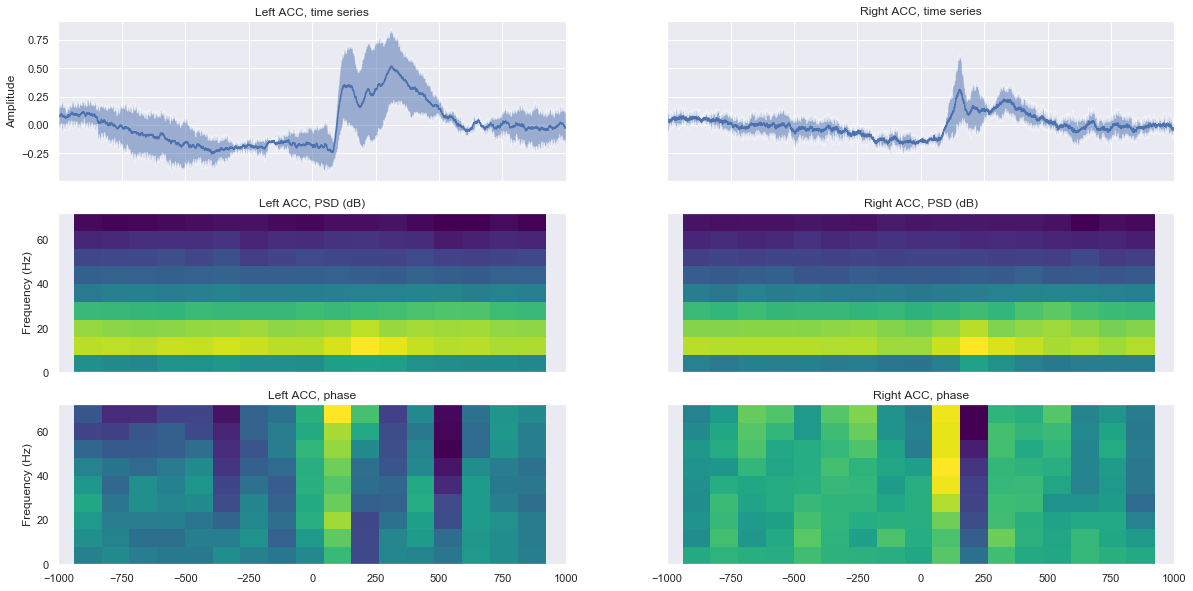

In [744]:
# Repeat spectral analysis from above

# Get average across electrodes, indexed by trial & time
leftChannels_averaged = leftChannels.mean(axis=1)
rightChannels_averaged = rightChannels.mean(axis=1)

# Get spectrograms for each trial & average these
# Note getting average spectrogram rather than spectrogram of average - latter results in loss of information
leftPSDs = [] # Empty list for storing PSDs
leftPhases = [] # Empty list for storing phases

rightPSDs = []
rightPhases = []
for trial in df.Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, leftSxx = signal.spectrogram(leftChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, leftphaseTrial = signal.spectrogram(leftChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    freqs, times, rightSxx = signal.spectrogram(rightChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, rightphaseTrial = signal.spectrogram(rightChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    # Add PSD & phase to list
    leftPSDs.append(leftSxx)
    leftPhases.append(leftphaseTrial)
    
    rightPSDs.append(rightSxx)
    rightPhases.append(rightphaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials
    
# Get average psd & phase
leftpsd = np.mean(leftPSDs, axis=0)
leftphase = np.mean(leftPhases, axis=0)

rightpsd = np.mean(rightPSDs, axis=0)
rightphase = np.mean(rightPhases, axis=0)

# Convert to times centres on feedback
times = (times - 1) * 1000

# Create plot
fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex = 'col', sharey = 'row', figsize = (20, 10))

# Plot time series
leftChannels_mean.plot(ax=ax[0,0])
ax[0,0].fill_between(leftChannels_mean.index, leftChannels_mean+leftChannels_SD, leftChannels_mean-leftChannels_SD, alpha=0.5)
ax[0,0].set_title('Left ACC, time series')
ax[0,0].set_ylabel('Amplitude')

rightChannels_mean.plot(ax=ax[0,1])
ax[0,1].fill_between(rightChannels_mean.index, rightChannels_mean+rightChannels_SD, rightChannels_mean-rightChannels_SD, alpha=0.5)
ax[0,1].set_title('Right ACC, time series')

# Plot PSD
ax[1,0].pcolormesh(times, freqs[:10], 10*np.log(leftpsd[:10]), cmap = 'viridis')
ax[1,0].set_title('Left ACC, PSD (dB)')
ax[1,0].set_ylabel('Frequency (Hz)')

ax[1,1].pcolormesh(times, freqs[:10], 10*np.log(rightpsd[:10]), cmap = 'viridis')
ax[1,1].set_title('Right ACC, PSD (dB)')

# Plot phase
ax[2,0].pcolormesh(times, freqs[:10], leftphase[:10], cmap = 'viridis')
ax[2,0].set_title('Left ACC, phase')
ax[2,0].set_ylabel('Frequency (Hz)')

ax[2,1].pcolormesh(times, freqs[:10], rightphase[:10], cmap = 'viridis')
ax[2,1].set_title('Right ACC, phase')

As expected from the overall analysis, we see that the feedback response is associated with activity in the 150 - 400ms range on the left. On the right, this activity is slightly delayed and shorter-lived, as well as having a slightly higher frequency components (though this could be inferred by looking at the raw time series). We also see that there is a consistent pattern of activity (indicated by very low variance) in the pre-feedback period, and this seems to be more marked in the right ACC and earlier in the right ACC. This is consistent with a role for the right ACC in predicting outcomes as part of our hypothesised prediction network. Further, we can also see a later pattern of activity at 500ms on the right and 700ms on the left, indicating that the response may be longer than was evident earlier, with timings differing between sides. Again, this is consistent with a network communicating here.

Looking at the phase response is interesting: on both sides, there is clear cross-frequency coherence from roughly 250ms BEFORE feedback, indicating some level of anticipation of the left ACC to feedback. This does not appear to be accompanied by any clear amplitude response in these frequencies; it may, however, indicate a "readying" of our hypothesised prediction network for feedback & valence encoding, with resetting of phases in preparation for feedback. This would be consistent with evidence re. the role of oscillatory phase in sensory perception, where oscillatory phase is entrained to predicted stimuli to ensure that stimulus signals are received when the system is in the optimum phase to encode & respond (oscillatory phase is related to the efficiency of encoding percepts). This would suggest that the ACC network is preparing itself for anticipated feedback (or, alternatively, it may be associated with "making a prediction"). This response is not as evident on the right.

The phase response to feedback, which we saw on the overall signal, is also evident here. Occurring at about 200ms, this is evident bilaterally & appears to be longer lived, particularly in the sub-40Hz frequency range. On the right, there is a phase response to feedback, but cross-frequency coherence is lost more quickly. This again supports a dominant left-sided response to feedback.

It is difficult to appreciate phase coherence between left and right here; on direct inspection, it seems there the signals are obviously coherent at the onset of the feedback response at roughly 200ms. This is briefly sustained but is certainly lost by 500ms. It appears to be stronger within specific frequencies: the 0 - 20Hz range in particular appears to sustain coherence for a longer period.

Now that we have a sense for the data is behaving, we will look at the individual electrodes. It is apparent from Weiss et al. that the individual electrodes contain differing information on feedback responses, with improved linear discriminant analysis performance when all electrode traces were used. This suggests that specific areas within the ACC are performing differing tasks within our hypothesised ACC prediction network.

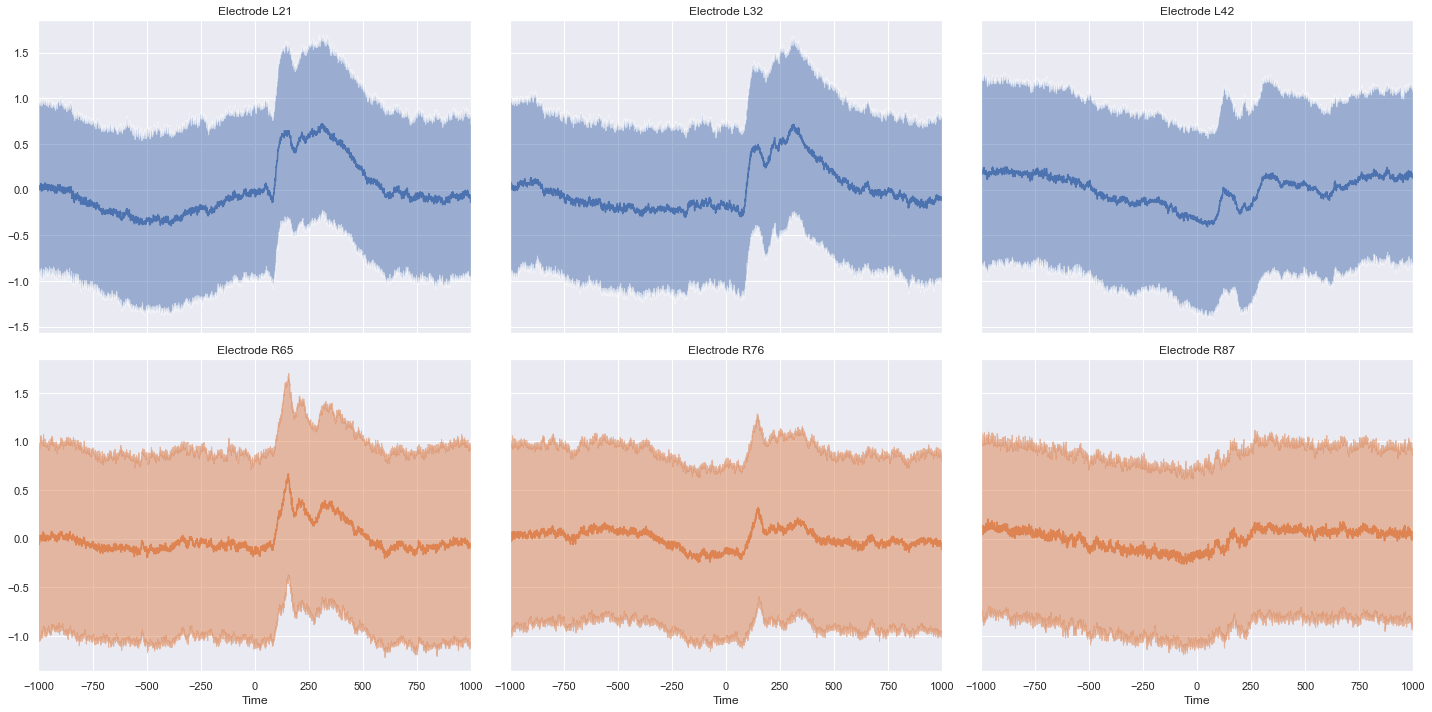

In [285]:
# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    # Get average for current channel across trials
    leftMean = allChannels[left].groupby('Time').mean()
    leftSD = allChannels[left].groupby('Time').std()
    
    rightMean = allChannels[right].groupby('Time').mean()
    rightSD = allChannels[right].groupby('Time').std()
    
    leftMean.plot(ax=ax[0,i])
    ax[0,i].fill_between(leftMean.index, leftMean + leftSD, leftMean - leftSD, alpha=0.5)
    ax[0,i].set_title('Electrode {}'.format(left))
    
    rightMean.plot(ax=ax[1,i], color=colors[1])
    ax[1,i].fill_between(rightMean.index, rightMean + rightSD, rightMean - rightSD, color=colors[1], alpha=0.5)
    ax[1,i].set_title('Electrode {}'.format(right))
     
fig.tight_layout()

Looks interesting - as was apparent from all electrodes plotted together above, the morphology of the feedback response appears to differ between sides & between areas within each side. This is in keeping with our hypothesis of an ACC network with multiple discrete nodes carrying out different taks & communicating with each other. Look at the left side, L21 and L32 are broadly similar in shape, with the double-peak response to feedback. L42 also shows two peaks, but these are shorter and distinct, rather than sustained and summative as in the others.

On the right, we see differences between electrodes again. Particularly, the peak is sharper and occurs later, and the peak response timing appears to differ between electrodes, suggesting a propagation of the feedback response between the areas recorded.

These individual waveforms support the idea that there are multiple discrete nodes in an ACC prediction network. We will finish our exploration by taking a look at the PSDs and phase responses for each electrode individually.

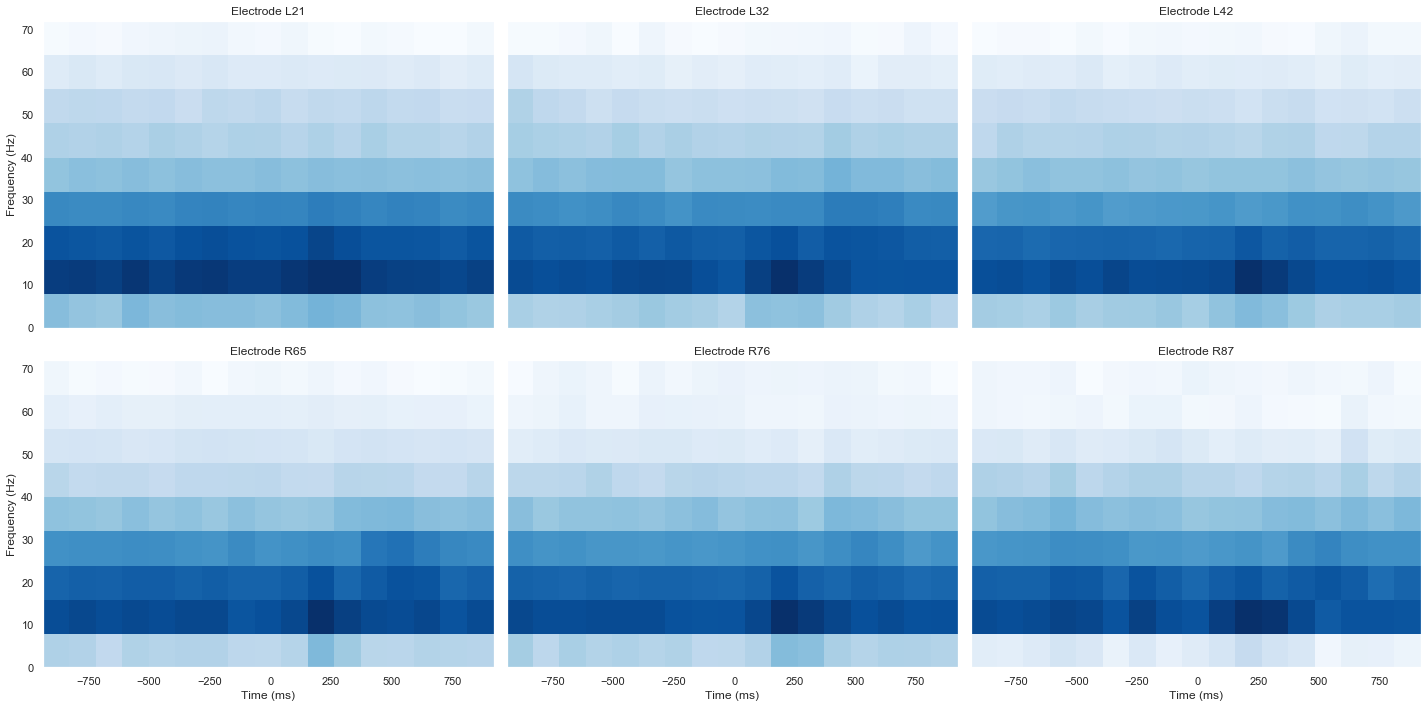

In [693]:
# Plot spectrograms for each electrode

# Get data from all trials, indexed by trial and time
allChannels = pd.pivot_table(df, values=electrodes, index=['Trial', 'Time'])

# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    # Lists for averaging over
    leftPSDs = []
    rightPSDs = []
    for trial in df.Trial.unique(): # Cycle through trials -> get mean spectrogram & phase
        freqs, times, leftSxx = signal.spectrogram(allChannels[left][trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256)
        freqs, times, rightSxx = signal.spectrogram(allChannels[right][trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256)
        
        leftPSDs.append(leftSxx)
        rightPSDs.append(rightSxx)
        
    # Average PSD & phase
    leftpsd = np.mean(leftPSDs, axis=0)
    rightpsd = np.mean(rightPSDs, axis=0)
    
    # Convert times to ms, centred on feedback
    times = (times-1)*1000
    
    # Plot current channel
    ax[0,i].pcolormesh(times, freqs[:10], 10*np.log10(leftpsd[:10]), cmap='Blues')
    ax[0,i].set_title('Electrode {}'.format(left))
    
    ax[1,i].pcolormesh(times, freqs[:10], 10*np.log10(rightpsd[:10]), cmap='Blues')
    ax[1,i].set_title('Electrode {}'.format(right))
    ax[1,i].set_xlabel('Time (ms)')
    
ax[0,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_ylabel('Frequency (Hz)')
fig.tight_layout()

Nothing really in the spectrograms that was not readily apparent in the time domain representation. There is a clear response at about 200ms post feedback at 10-20Hz throughout. We don't really have the resolution here to go into that in much more detail; the time representation is more informative here.

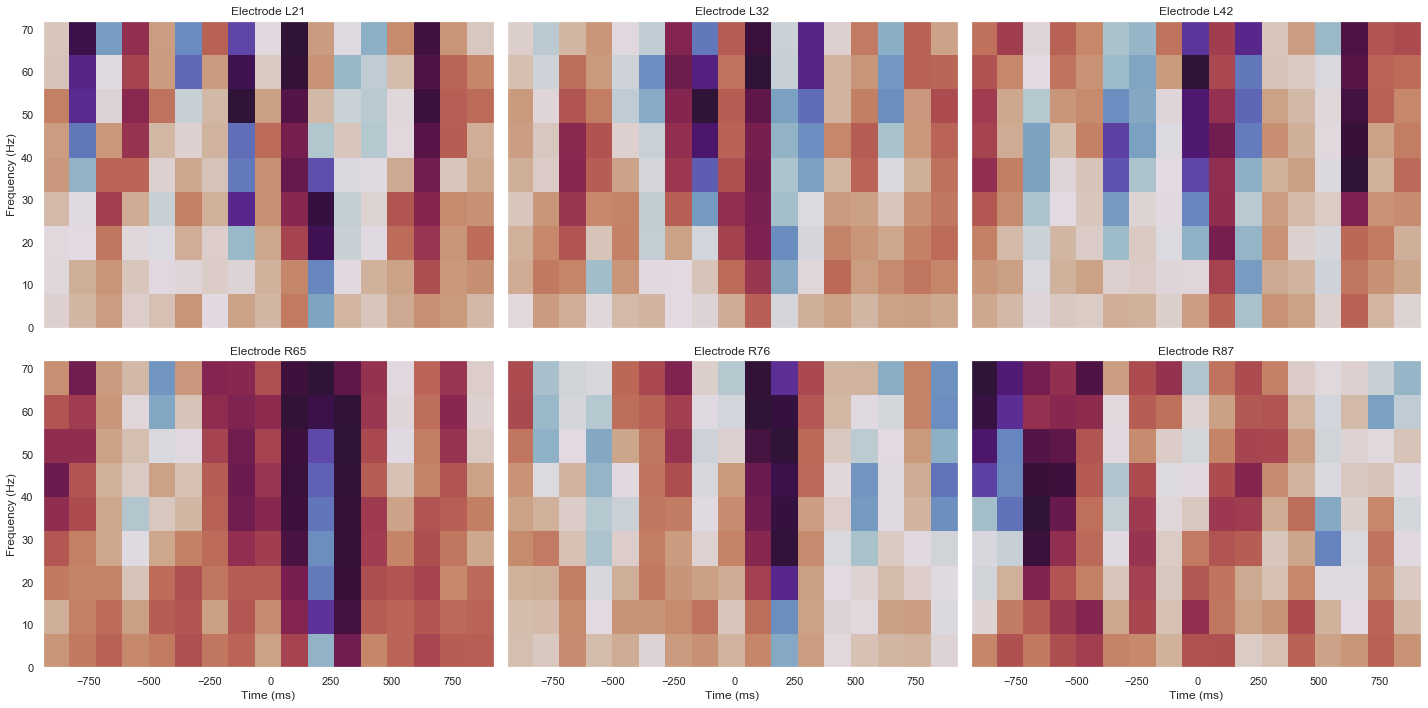

In [694]:
# Plot spectrograms for each electrode

# Get data from all trials, indexed by trial and time
allChannels = pd.pivot_table(df, values=electrodes, index=['Trial', 'Time'])

# Create figure to plot on
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize = (20,10))

# Cycle through each electrode & plot average response across trials
for i, (left, right) in enumerate(zip(electrodesLeft, electrodesRight)):
    # Lists for averaging over
    leftPSDs = []
    rightPSDs = []
    for trial in df.Trial.unique(): # Cycle through trials -> get mean spectrogram & phase
        freqs, times, leftSxx = signal.spectrogram(allChannels[left][trial], fs=2048, mode = 'phase', scaling='spectrum', window='hanning', nperseg=256)
        freqs, times, rightSxx = signal.spectrogram(allChannels[right][trial], fs=2048, mode = 'phase', scaling='spectrum', window='hanning', nperseg=256)
        
        leftPSDs.append(leftSxx)
        rightPSDs.append(rightSxx)
        
    # Average PSD & phase
    leftpsd = np.mean(leftPSDs, axis=0)
    rightpsd = np.mean(rightPSDs, axis=0)
    
    # Convert times to ms, centred on feedback
    times = (times-1)*1000
    
    # Plot current channel
    ax[0,i].pcolormesh(times, freqs[:10], 10*np.log10(leftpsd[:10]), cmap='twilight_shifted')
    ax[0,i].set_title('Electrode {}'.format(left))
    
    ax[1,i].pcolormesh(times, freqs[:10], 10*np.log10(rightpsd[:10]), cmap='twilight_shifted')
    ax[1,i].set_title('Electrode {}'.format(right))
    ax[1,i].set_xlabel('Time (ms)')
    
ax[0,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_ylabel('Frequency (Hz)')
fig.tight_layout()

Looking at phase over time for each electrode, we see, as expected, a coherent response across all bands at about 200ms in all electrodes, corresponding with the feedback response. Interestingly, here we see that this appears to be coherent between all electrodes on the left up to about 500ms, while on the left the response is only really coherent between R65 and R76 and is much shorter-lived, while R87 is not as coherent with the other electrodes on this side, but does seem to be coherent with R76 at about 500ms. This post-feedback "phase reset" is in line with the time-domain response we have seen, while these differences in phase response, not as apparent in the time domain, further support a lateralised difference in response, and differing roles for discrete nodes within an ACC network.

Further, looking pre-feedback, on the left there seems to be coherence across electrodes at about -150ms, consistent with a coordinated phase response in "anticipation" of an input. This is more marked on the right side, where it is consistent across all electrodes, and appears to extend over a longer period. This is consistent with a greater role for the right side in prediction.

Having now developed a bit of a sense for how the data is behaving, we can look at laying out some more specific hypotheses and doing some more quantitative analysis to explore these.

## Hypothesis
Having visualised the data, we can outline our hypothesis for what the ACC is doing, in line with existing evidence.

We hypothesise that the bilateral anterior cingulate cortices are involved in a "prediction network" which predicts outcomes to events & updates its prediction model on the basis of the observed outcomes. The activity of this network is carried out by distinct network nodes. Responses to feedback are therefore lateralised, and within hemispheres different areas respond differently. These network nodes communicate with each other to transfer information on predictions & outcomes to inform action and update prediction models. This network therefore responds strongly to event outcomes, with distinct patterns of activity and inter-node communication.

We can then set about investigating this hypothesis quantitatively.

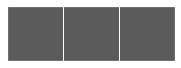

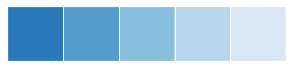

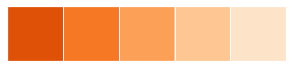

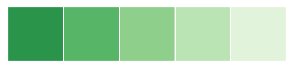

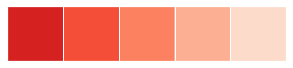

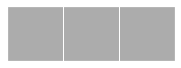

In [523]:
# Set up plotting settings for plots here
# Decide on colour scheme, e.g. for L v R - create two colour palettes -> call from these (e.g. plot all 6 electrodes, L in shades of blue, R in shades of red)
    # Need colors for left / right / correct / incorrect / highlight & for all plot types - consistent aesthetics for combining plots
# Set figure size, text size, line width, etc. globally
sns.set(rc={'figure.figsize':(20, 10)}) # Can fix font size, legend size, etc. when putting plots together 

# Will need to review this when final plots made
colours_left = sns.color_palette("Blues_r")[1:]
colours_right = sns.color_palette("Oranges_r")[1:]
colours_correct = sns.color_palette("Greens_r")[1:]
colours_incorrect = sns.color_palette("Reds_r")[1:]

colour_overall = sns.color_palette("Greys")[4]
colour_highlight = sns.color_palette("Greys")[2]

colours_spectrum = "Blues"
colours_phase = "twilight_shifted"

sns.palplot(colour_overall)
sns.palplot(colours_left)
sns.palplot(colours_right)
sns.palplot(colours_correct)
sns.palplot(colours_incorrect)
sns.palplot(colour_highlight)

### The anterior cingulate cortex predicts & responds to event outcomes
We hypothesise that the anterior cingulate cortices overall respond to event outcomes. We propose that they predict outcomes, which is used to inform activity, and that they use the actual outcome to update their prediction model for future events. If this is true, we expect to see a consistent pattern of activity across the ACC in the periods preceding and following feedback (at physiologically plausible time lags), and we expect to be able to identify components of this response corresponding to prediction and response.

To investigate this, we normalised our data to mean zero and unit variance. We can then analyse the feedback-locked time series to determine whether and in what intervals the waveform deviates from 0 to a statistically significant degree. We expect to see clear windows of significant activity, relating to time-locked responses within the ACC relating to prediction and model updating. Further, we expect to be able to decompose this feedback-locked time series to identify discrete sources corresponding to these activities (pre- and post-feedback).

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: -948.73046875ms to -944.3359375ms
Interval: -942.3828125ms to -938.96484375ms
Interval: -937.98828125ms to -937.98828125ms
Interval: -937.01171875ms to -936.5234375ms
Interval: -908.203125ms to -905.2734375ms
Interval: -903.3203125ms to -902.83203125ms
Interval: -901.85546875ms to -895.99609375ms
Interval: -889.6484375ms to -886.71875ms
Interval: -877.9296875ms to -877.9296875ms
Interval: -568.359375ms to -568.359375ms
Interval: -566.40625ms to -566.40625ms
Interval: -565.4296875ms to -564.94140625ms
Interval: -558.10546875ms to -555.17578125ms
Interval: -553.7109375ms to -553.7109375ms
Interval: -537.109375ms to -529.78515625ms
Interval: -528.80859375ms to 91.30859375ms
Interval: 105.46875ms to 505.37109375ms
Interval: 507.32421875ms to 507.8125ms


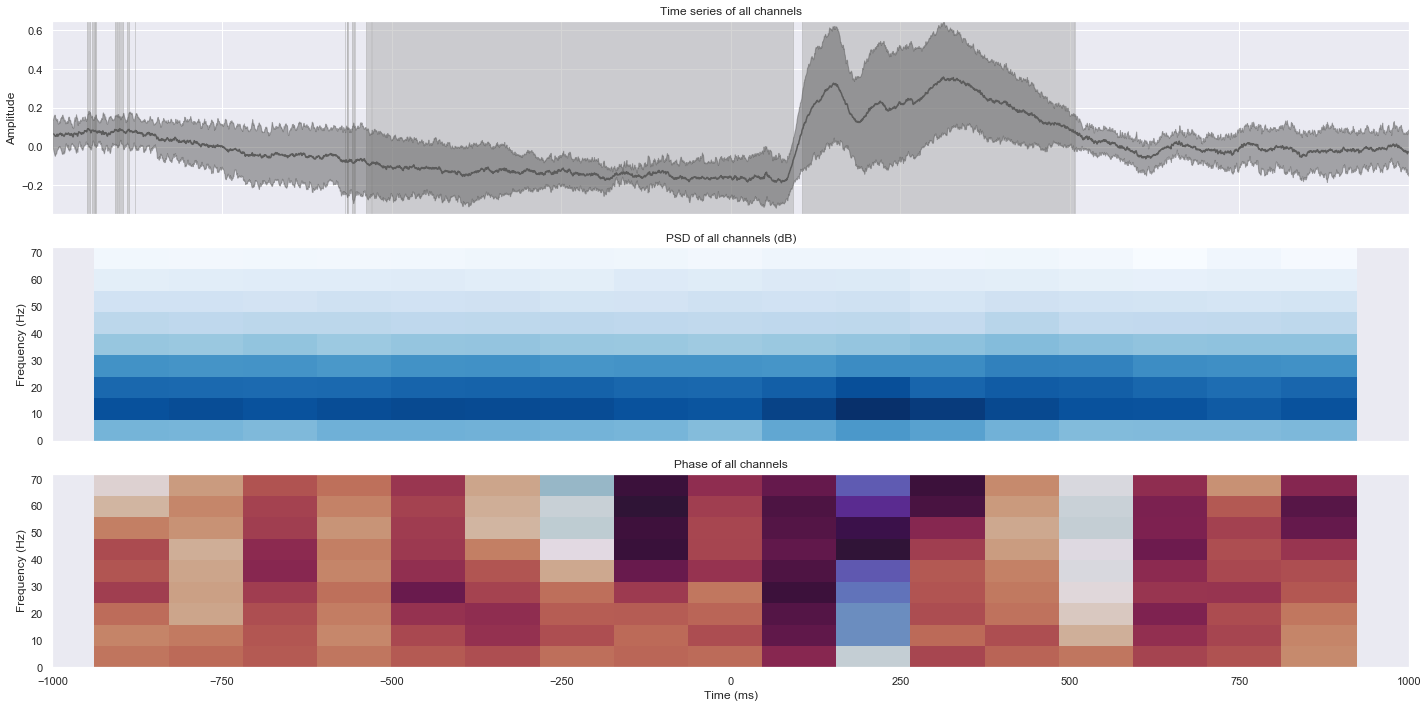

In [772]:
# Plot average of all channels with significant areas highlighted, spectrogram and phase

# Get channel data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

##### Get average time series #####

# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

# Average across channels
allChannels_averagedMean = allChannels_averaged.mean(axis=1)
allChannels_averagedSD = allChannels_averaged.std(axis=1)

##### Test to see where waveform is statistically significant #####
allChannels = pd.pivot_table(df, values = electrodes, index = ['Time', 'Trial'])

# Get average of all electrodes, indexed by trial and time
allChannels_averaged = allChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttests = [stats.ttest_1samp(allChannels_averaged[t], 0) for t in df.Time.unique()]
pvals = [test.pvalue for test in ttests]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if pvals[index] < threshold and pvals[index-1] > threshold:
        startinds.append(index)
        
    if pvals[index] < threshold and pvals[index+1] > threshold:
        endinds.append(index)
        
intervals = zip(startinds, endinds)

##### Get PSD & phase #####

# Get channel data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

# Average across electrodes, indexed by trial & time
allChannels_averaged = allChannels.mean(axis=1)

# Get spectrogram for each trial & average these
# Note getting average spectrogram rather than spectrogram of average - latter results in loss of information
PSDs = [] # Empty list for storing PSDs
Phases = [] # Empty list for storing phases
for trial in df.Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, Sxx = signal.spectrogram(allChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, phaseTrial = signal.spectrogram(allChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    # Add PSD & phase to list
    PSDs.append(Sxx)
    Phases.append(phaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials

# Get average psd & phase
psd = np.mean(PSDs, axis=0)
phase = np.mean(Phases, axis=0)

# Convert times to ms, centred on feedback
times = (times - 1) * 1000

# Create plot: time series / PSD / phase
fig, ax = plt.subplots(3,1, sharex='col');

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax[0].fill_between([t[start], t[end]], 0.7, -0.4, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
allChannels_averagedMean.plot(ax=ax[0], color=colour_overall)
ax[0].fill_between(allChannels_averagedMean.index, allChannels_averagedMean + allChannels_averagedSD, allChannels_averagedMean - allChannels_averagedSD, alpha=0.5, color=colour_overall)
ax[0].set_title('Time series of all channels')
ax[0].set_ylabel('Amplitude')
ax[0].set_ylim([-0.35, 0.65])

ax[1].pcolormesh(times, freqs[:10], 10*np.log10(psd[:10]), cmap=colours_spectrum)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('PSD of all channels (dB)')

ax[2].pcolormesh(times, freqs[:10], phase[:10], cmap=colours_phase)
ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_title('Phase of all channels')
ax[2].set_xlabel('Time (ms)')

fig.tight_layout()

We demonstrate here that there the ACC predicts and responds to feedback. The time series shows the average response across all channels. We can see that there is a visible response to feedback, and a predictive "anticipation" response was predicted based on the reduction in signal variance at -200ms. The highlighted regions of the time series show the intervals in which there is a statistically significant response to feedback across trials. In order to ensure that our results are rigorous and represent true responses, we will be strict about our hypothesis testing. Here, we judge a timepoint to represent a statistically significant response to feedback if the signal at that timepoint (locked to feedback) across all trials (all baseline corrected and normalised to zero mean and unit variance) differs from a population with mean 0 and unit variance with $p < 1e^{-4}$; in addition to a strict p-value, we then use Bonferonni correction to reduce our significant threshold proportional to the number of points tests; we therefore set our significance threshold to $p < 1e^{-4} \div 4097 = 2e^{-8}$; this represents a < 0.01% chance of a type 1 error, corrected for the number of tests.

This clearly demonstrates a consistent pattern of activity in the anterior cingulate cortex related to feedback. Our data here indicate that the ACC begins to anticipate outcome from 528ms before feedback is received, and that the post-stimulus response is in the interval from 105 to 505ms after feedback.

The post-feedback response is characterised by the double-peak structure described by Weiss et al. 2018, with an early and a late component. This double peak structure is represented in the frequency domain by a spike in the 10-20Hz range, and a coherent phase response lasting until about 500ms (i.e. the end of the response window indentified.

The pre-feedback ("predictive") period is not marked by any high-frequency features producing characteristic time-domain waveforms; however, there is clearly a consistent pattern of activity here over trials. Most marked is a period from about 200ms pre-feedback, where there is sudden reduction in the variance of all channels and a phase reset, resulting in a strongly coherent pattern of activity as feedback is received. This is consistent with an "anticipation" response, with the system readying itself to receive input at a point where it is most "primed" to respond.

We have clearly demonstrated that the ACC responds to feedback, with a predictive window beginning at 500ms pre-feedback and a response window at 100 - 500ms post-feedback. We will now investigate whether this pattern of activity is represented throughout the ACC.

Text(0.5, 1.0, 'Average response for each electrode')

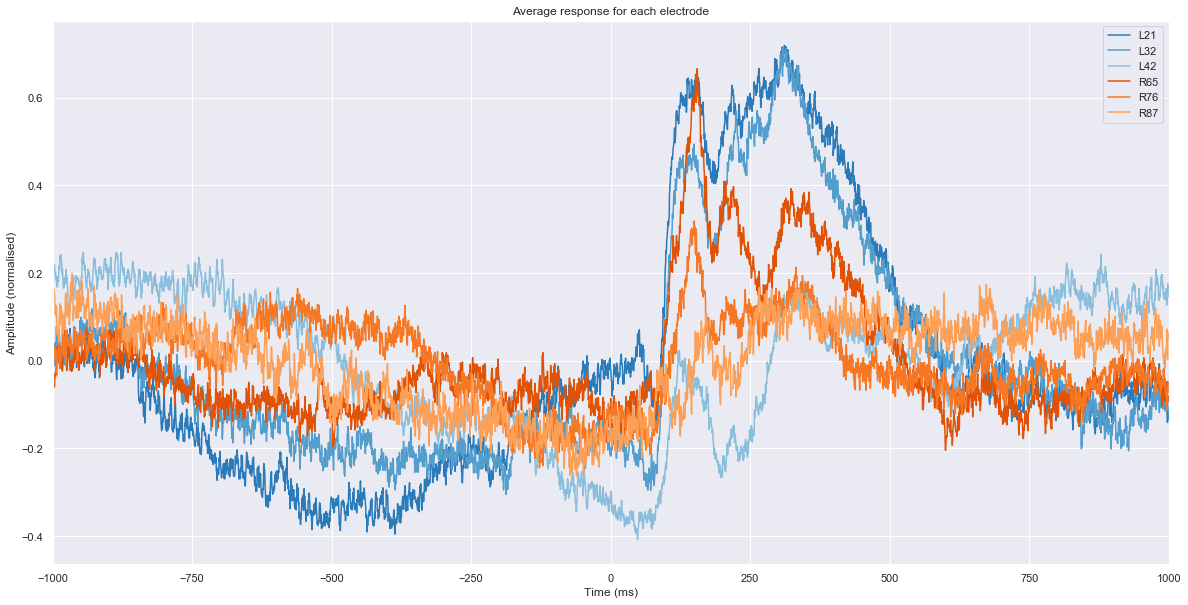

In [734]:
# Plot all electrodes
# Get channel data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

fig, ax = plt.subplots()
for i, left in enumerate(electrodesLeft):
    ax.plot(t, allChannels_averaged[left], label=left, color=colours_left[i])
    
for i, right in enumerate(electrodesRight):
    ax.plot(t, allChannels_averaged[right], label=right, color=colours_right[i])
    
ax.legend()
ax.set_xlim([-1000,1000])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (normalised)')
ax.set_title('Average response for each electrode')

We can see that the same broad pattern of activity is represented across the electrodes. Notably, the double-peak structure in the post-feedback window is most strongly evident on the left-sided electrodes (blues) than on those on the right (oranges). Additionally, electrode L42 shows a differing morphology to the other left-sided electrodes. The right-sided electrodes show a sharper, more delated early peak and a blunted late response. Further, there is a time lag between electrodes to reach this early peak, suggestive of propagating activity within the right ACC in response to feedback.

In the pre-stimulus period, we can see this window of reduced variance at -200ms clearly represented here, where all electrodes converge. This is consistent with a priming response for receiving input throughout the ACC bilaterally.

It appears, then, that the ACC anticipates and responds to feedback with stereotypes responses in discrete time windows. Further, it seems that this activity differs between sides and between areas. This supports our proposal of a distributed network of sources, each carrying distinct roles and communicating with each other.

Given that there is clearly a multi-component response to feedback (prediction, early response, late response) with differing activities at different electrodes suggestive of differing areas producing these responses within the ACC, we expect to be able to decompose this response into distinct components representing our hypothesised processes.

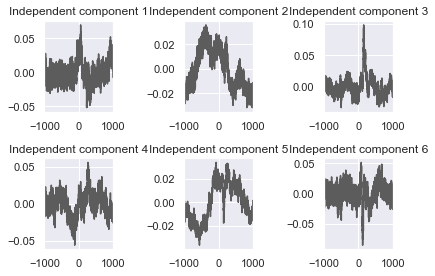

In [122]:
# Do ICA all electrodes and examine sources

# Get channel data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

allChannels_averaged = allChannels.groupby('Time').mean()

# 4097 x 6 array of average responses at each channel over time
signals = np.array([allChannels.groupby('Time').mean()[elec] for elec in electrodes]).T

# Compute ICA
ica = FastICA(n_components = 6)
signals_ = ica.fit_transform(signals)

# Plot ICs
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row')

for i, ic in enumerate(signals_.T):
    plt.subplot(2,3,i+1)
    plt.title('Independent component {}'.format(i+1))
    plt.plot(t,ic, color=colour_overall)
    plt.xlim([-1000,1000])
       
fig.tight_layout()

Here we have decomposed the average signal for all electrodes into its sources. This allows us to identify the independent sources of activity that produced the activity seen. On analysis of these sources, we can see that the first independent component represents a source with most marked activity at roughtly -200ms; this likely corresponds to our proposed pre-feedback anticipation activity, during the period where all electrodes converge and there is a uniform phase reset. Independent components 2 and 4 appear to be related to the earlier portion of the predictive window seen, with peaks of activity around -500ms. This suggests that the predictive response we have seen in the overall signal may itself be composed of an earlier prediction at -500ms, followed by a period of preparation for feedback at -200ms (represented by IC1 and ICs 2 and 4 respectively).

Independent components 2, 3, 5 and 6 all show responses at roughly 200ms post-feedback, while 3, 5 and 6 all show a second peak of activity at roughly 400ms post-feedback. This is consistent with our observation of a feedback response period from 100ms to 500ms post feedback. Interestingly, it suggests that this response may be spread throughout multiple sources within the ACC.

These results clearly demonstrate that the ACC's response to feedback can be decomposed into multiple sources, and that these sources correspond to anticipation of feedback and response to feedback. It appears that these activities are produced by different sources within the ACC. Further, it seems that our pre-feedback anticipation window is made up of two distinct components (i.e. prediction and readiness for input).

This is supportive of our proposal that there exists an ACC prediction network that predicts and responds to feedback, and that this activity is dispersed through multiple nodes throughout the ACCs.

### ACC network activity is distributed spatially
We hypothesised that our ACC prediction network is made up of spatially distinct centres of activity. This is supported by Weiss et al's results showing lateralisation of valence encoding, and by our results demonstrating that the average response can be decomposed into distinct sources representing different components of feedback prediction and response.

If our hypothesis of a distributed prediction network is true, we expect to see differences in response between the left and right ACC, representing different patterns of activity in these areas. We further expect the source decomposition of the left- and right-ACC signals to demonstrate different patterns, indicating that the primary sources of activity on each side are carrying out different roles. Lastly, given the spatial distribution of our proposed network, we expect to see differences within individual electrodes corresponding to the differing set of activity sources they are recording from.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
(Left) Interval: -624.51171875ms to -622.55859375ms
(Left) Interval: -618.65234375ms to -618.65234375ms
(Left) Interval: -617.67578125ms to -612.79296875ms
(Left) Interval: -605.95703125ms to -604.00390625ms
(Left) Interval: -579.58984375ms to 91.30859375ms
(Left) Interval: 104.00390625ms to 509.765625ms
(Right) Interval: -275.87890625ms to -275.87890625ms
(Right) Interval: -273.92578125ms to -273.92578125ms
(Right) Interval: -264.16015625ms to -264.16015625ms
(Right) Interval: -261.23046875ms to -261.23046875ms
(Right) Interval: -233.3984375ms to -232.421875ms
(Right) Interval: -224.609375ms to -223.14453125ms
(Right) Interval: -222.16796875ms to -220.703125ms
(Right) Interval: -215.33203125ms to -212.40234375ms
(Right) Interval: -210.44921875ms to -209.47265625ms
(Right) Interval: -208.0078125ms to -207.51953125ms
(Right) Interval: -206.54296875ms to -206.54296875ms
(Right) Interval: -204.1015625ms to -204.1015625ms
(R

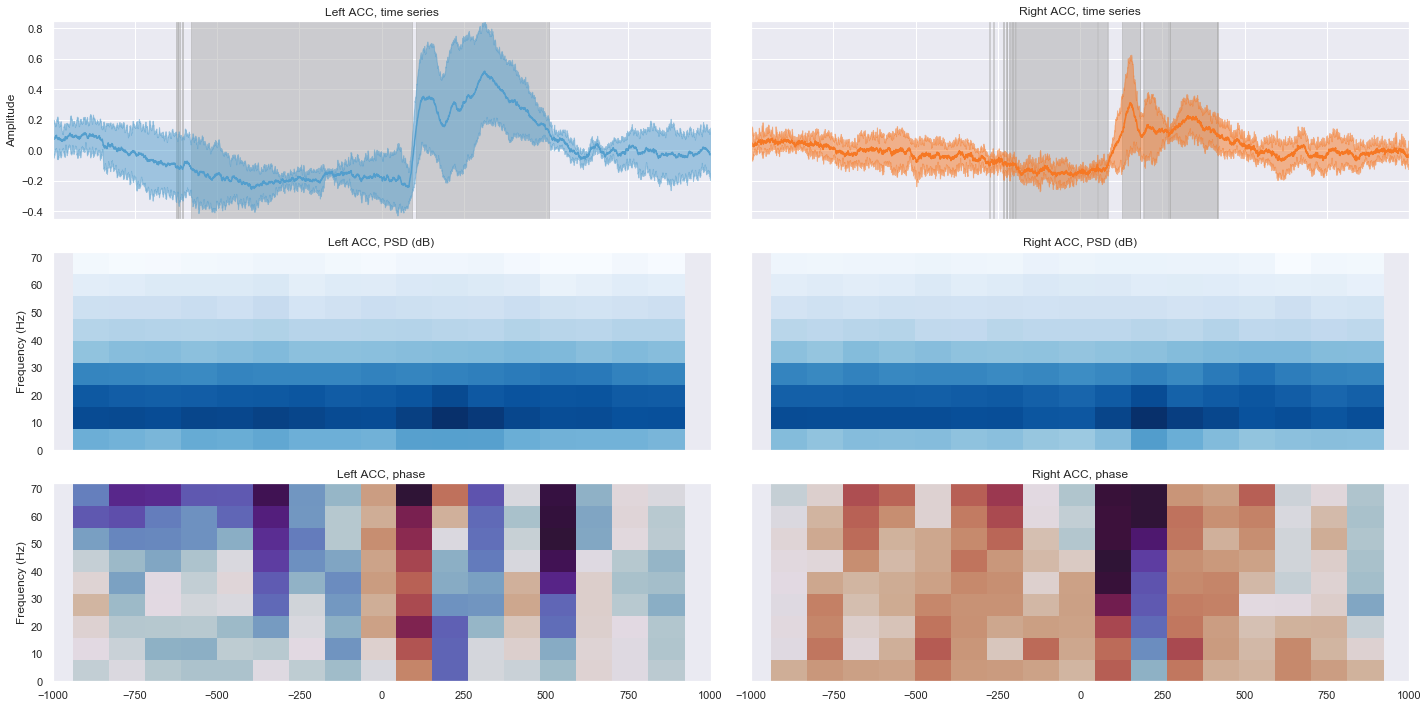

In [747]:
# Plot L & R highlighted with PSD & phase

# Get channel data from df
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

##### Get average time series #####

# Average across trials
leftChannels_averaged = leftChannels.groupby('Time').mean() # Mean of each electrode on left across trials
rightChannels_averaged = rightChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Average across channels
leftChannels_mean = leftChannels_averaged.mean(axis=1)
leftChannels_SD = leftChannels_averaged.std(axis=1)

rightChannels_mean = rightChannels_averaged.mean(axis=1)
rightChannels_SD = rightChannels_averaged.std(axis=1)

##### Test to see where waveform is statistically significant #####
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Time', 'Trial'])
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Time', 'Trial'])

# Get average of all electrodes, indexed by trial and time
leftChannels_averaged = leftChannels.mean(axis=1)
rightChannels_averaged = rightChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttestsLeft = [stats.ttest_1samp(leftChannels_averaged[t], 0) for t in df.Time.unique()]
pvalsLeft = [test.pvalue for test in ttestsLeft]

ttestsRight = [stats.ttest_1samp(rightChannels_averaged[t], 0) for t in df.Time.unique()]
pvalsRight = [test.pvalue for test in ttestsRight]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startindsLeft = [] # List of starts of intervals
endindsLeft = [] # List of ends of intervals
for index, value in enumerate(pvalsLeft):
    if pvalsLeft[index] < threshold and pvalsLeft[index-1] > threshold:
        startindsLeft.append(index)
        
    if pvalsLeft[index] < threshold and pvalsLeft[index+1] > threshold:
        endindsLeft.append(index)
        
intervalsLeft = zip(startindsLeft, endindsLeft)

startindsRight = [] # List of starts of intervals
endindsRight = [] # List of ends of interval
for index, value in enumerate(pvalsRight):
    if pvalsRight[index] < threshold and pvalsRight[index-1] > threshold:
        startindsRight.append(index)
        
    if pvalsRight[index] < threshold and pvalsRight[index+1] > threshold:
        endindsRight.append(index)
        
intervalsRight = zip(startindsRight, endindsRight)

##### Get PSD & phase #####

# Get channel data from df
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'])
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'])

# Average across electrodes, indexed by trial & time
leftChannels_averaged = leftChannels.mean(axis=1)
rightChannels_averaged = rightChannels.mean(axis=1)

# Get spectrogram for each trial & average these
# Note getting average spectrogram rather than spectrogram of average - latter results in loss of information
leftPSDs = [] # Empty list for storing PSDs
leftPhases = [] # Empty list for storing phases

rightPSDs = []
rightPhases = []
for trial in df.Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, leftSxx = signal.spectrogram(leftChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, leftphaseTrial = signal.spectrogram(leftChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    freqs, times, rightSxx = signal.spectrogram(rightChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, rightphaseTrial = signal.spectrogram(rightChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial
    
    # Add PSD & phase to list
    leftPSDs.append(leftSxx)
    leftPhases.append(leftphaseTrial)
    
    rightPSDs.append(rightSxx)
    rightPhases.append(rightphaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials
    
# Get average psd & phase
leftpsd = np.mean(leftPSDs, axis=0)
leftphase = np.mean(leftPhases, axis=0)

rightpsd = np.mean(rightPSDs, axis=0)
rightphase = np.mean(rightPhases, axis=0)

# Convert to times centres on feedback
times = (times - 1) * 1000

##### Create plot: time series / PSD / phase
fig, ax = plt.subplots(3,2, sharex='col', sharey='row');

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervalsLeft:
    ax[0,0].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Left) Interval: {0}ms to {1}ms".format(t[start], t[end]))
for start, end in intervalsRight:
    ax[0,1].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Right) Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
    
# Plot time series
leftChannels_mean.plot(ax=ax[0,0], color=colours_left[1])
ax[0,0].fill_between(leftChannels_mean.index, leftChannels_mean+leftChannels_SD, leftChannels_mean-leftChannels_SD, alpha=0.5, color=colours_left[1])
ax[0,0].set_title('Left ACC, time series')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_ylim([-0.45, 0.85])

rightChannels_mean.plot(ax=ax[0,1], color=colours_right[1])
ax[0,1].fill_between(rightChannels_mean.index, rightChannels_mean+rightChannels_SD, rightChannels_mean-rightChannels_SD, alpha=0.5, color=colours_right[1])
ax[0,1].set_title('Right ACC, time series')

# Plot PSD
ax[1,0].pcolormesh(times, freqs[:10], 10*np.log(leftpsd[:10]), cmap = colours_spectrum)
ax[1,0].set_title('Left ACC, PSD (dB)')
ax[1,0].set_ylabel('Frequency (Hz)')

ax[1,1].pcolormesh(times, freqs[:10], 10*np.log(rightpsd[:10]), cmap = colours_spectrum)
ax[1,1].set_title('Right ACC, PSD (dB)')

# Plot phase
ax[2,0].pcolormesh(times, freqs[:10], leftphase[:10], cmap = colours_phase)
ax[2,0].set_title('Left ACC, phase')
ax[2,0].set_ylabel('Frequency (Hz)')

ax[2,1].pcolormesh(times, freqs[:10], rightphase[:10], cmap = colours_phase)
ax[2,1].set_title('Right ACC, phase')

fig.tight_layout()

This plot shows the time series, PSD and phase over time for the left ACC (blue) and left ACC (orange). The highlighted regions show where the feedback-locked waveforms of the zero-mean, unit-variance signals differ from zero to a statistically significant degree (i.e. where there is a statistically robust response relative to feedback) with a p-value threshold of $1e^{-4} \div 4097 = 2 \times 10^{-8}$. This represents a less than 0.01% chance of a false positive result, Bonferroni corrected for the number of timepoints tested.

This shows clear differences in the feedback responses between the right and left ACC. We see that the left ACC has a prolonged period of anticipation beginning at 579ms before feedback, while the anticipation window on the right is confined to the shorter prediction window we had identified earlier, beginning at 195ms pre-feedback (with smaller significant intervals back to 270ms pre-feedback). This supports out proposal that the left and right ACC carry out different activities, as well as providing further evidence that the predictive action of the ACC network is composed of an early component from about 500ms pre-feedback and a late preparation component at about 200ms pre-feedback.

We see that both sides show a robust response to feedback. However, there is a slight difference in the time to onset of a significant response, with an effect of feedback evident on the left by 104ms post-feedback, while the feedback effect is not evident on the right until 126ms post-feedback. This lag is suggestive of differences in activity between the two sides, and in particular suggests that the right ACC may be responding to the activity of the left ACC 20ms earlier. In keeping with this notion, we see that the peak of the early right ACC response is sharper and occurs later, suggesting a difference in activity, and the "double-peak" structure described by Weiss et al. is clearly evident on the left, while the second peak in particular is delayed and blunted on the right. This further supports a difference in response to feedback between the two sides, and supports the suggestion of a network with communicating nodes predicting and responding to outcomes.

Examining the PSD of both sides, we see what would be expected from the time domain signal: a peak of activity in the 10-20Hz range, corresponding to the peaked response seen. On examination of the phase response, we can clearly see a "phase reset" following feedback, consistent with a feedback response. This is consistent bilaterally and appears to be broadly coherent between sides in the post-feedback period.

These results strongly suggest that there is a difference in feedback response between the left and right ACC, supporting our hypothesis of a distributed network responding to feedback. In order to get a clearer idea of where the responses differ, we will directly compare the feedback-locked signals from the left and right ACC.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: -561.5234375ms to -558.59375ms
Interval: -557.6171875ms to -552.734375ms
Interval: -551.26953125ms to -530.2734375ms
Interval: -529.296875ms to -511.23046875ms
Interval: -509.27734375ms to -508.7890625ms
Interval: -487.3046875ms to -487.3046875ms
Interval: -486.328125ms to -469.7265625ms
Interval: -468.75ms to -454.58984375ms
Interval: -449.21875ms to -449.21875ms
Interval: -447.265625ms to -447.265625ms
Interval: -446.2890625ms to -445.3125ms
Interval: -444.3359375ms to -444.3359375ms
Interval: -443.359375ms to -321.77734375ms
Interval: -320.3125ms to -318.359375ms
Interval: -317.3828125ms to -315.91796875ms
Interval: -313.96484375ms to -311.5234375ms
Interval: -310.05859375ms to -310.05859375ms
Interval: -309.08203125ms to -306.640625ms
Interval: -305.17578125ms to -305.17578125ms
Interval: -301.7578125ms to -301.7578125ms
Interval: -300.78125ms to -288.57421875ms
Interval: -266.11328125ms to -265.13671875ms


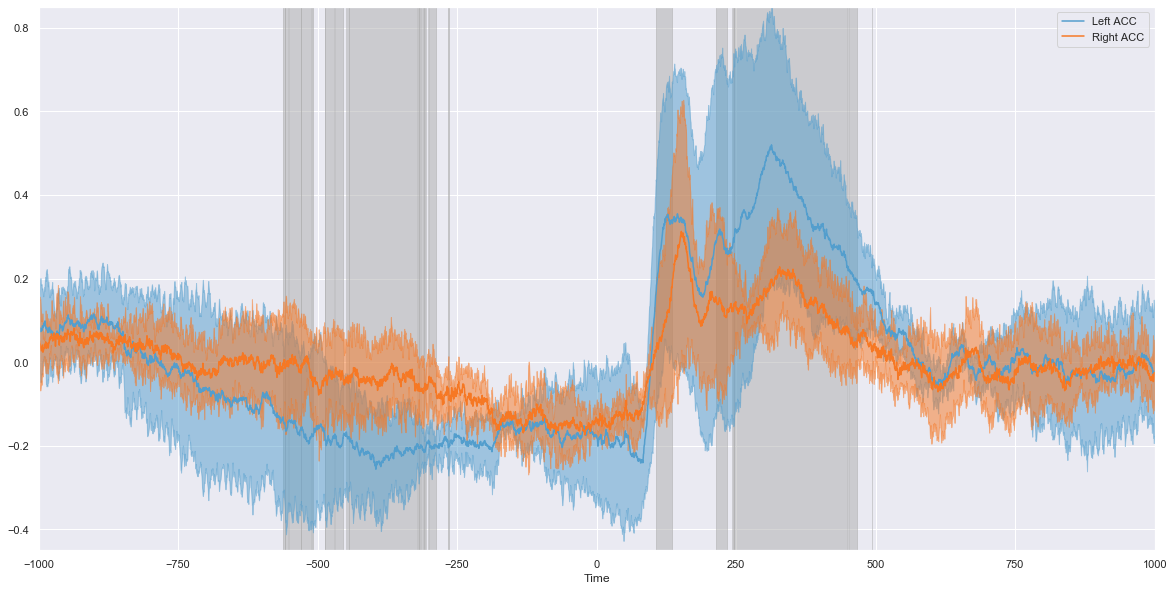

In [767]:
# Compare L & R
# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)

# Get average of all electrodes, indexed by trial and time
leftChannels_averaged = leftChannels.mean(axis=1)
rightChannels_averaged = rightChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttests = [stats.ttest_rel(leftChannels_averaged[t], rightChannels_averaged[t], 0) for t in df.Time.unique()]
pvals = [test.pvalue for test in ttests]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if pvals[index] < threshold and pvals[index-1] > threshold:
        startinds.append(index)
        
    if pvals[index] < threshold and pvals[index+1] > threshold:
        endinds.append(index)
        
intervals = zip(startinds, endinds)

# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
leftChannels_averaged = leftChannels.groupby('Time').mean() # Mean of each electrode on left across trials
rightChannels_averaged = rightChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
leftChannels_mean = leftChannels_averaged.mean(axis=1)
leftChannels_SD = leftChannels_averaged.std(axis=1)

rightChannels_mean = rightChannels_averaged.mean(axis=1)
rightChannels_SD = rightChannels_averaged.std(axis=1)

# Plot L v R
fig, ax = plt.subplots()

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax.fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
leftChannels_mean.plot(ax=ax, label='Left ACC', color=colours_left[1])
rightChannels_mean.plot(ax=ax, label='Right ACC', color=colours_right[1])
ax.fill_between(leftChannels_mean.index, leftChannels_mean + leftChannels_SD, leftChannels_mean - leftChannels_SD, alpha=0.5, color=colours_left[1])
ax.fill_between(rightChannels_mean.index, rightChannels_mean + rightChannels_SD, rightChannels_mean - rightChannels_SD, alpha=0.5, color=colours_right[1])

ax.set_ylim([-0.45, 0.85])
ax.legend()

This plot shows the responses of the left (blue) and right (orange) ACC to feedback on the same plot. Highlighted areas show regions where the two responses (zero-meaned and normalised to unit variance) differ to a statistically significant degree on a repeated-measures t-test with a threshold of $p < 0.0001$, Bonferonni corrected to a threshold of $p < 0.0001 \div 4097 = 2 \times 10^{-8}$.

This supports the results we had inferred from visualisation of the separate responses. The early "predictive response" differs between the right and left, with a difference evident in the interval between 561ms and 288ms pre-feedback. This suggests that the activity of the right and left ACC differ during the early portion of outcome prediction. We see that the difference between sides is not statistically significant during the late predictive window, consistent with our observation of a coordinated preparatory response earlier.

Looking at the post-feedback response, we see an immediate difference in the interval between 106ms and 135ms post-feedback. This is due to the lag in response between the two sides, consistent with our observation of a later-onset response on the right.

We then see a difference in the interval between 242ms and 566ms post-feedback. This is again consistent with difference in response to feedback between the left and right ACC. With the two figures superimposed, we see clearly the lagged and damped "double-peak" response in the right ACC.

These results strongly suggest that the right and left ACCs are carrying out different activities during the pre- and post-feedback windows identified. If this is the case, we expect to be able to decompose the averaged feedback-locked signals from the left and right ACC into distinct sources which represent these different activities.

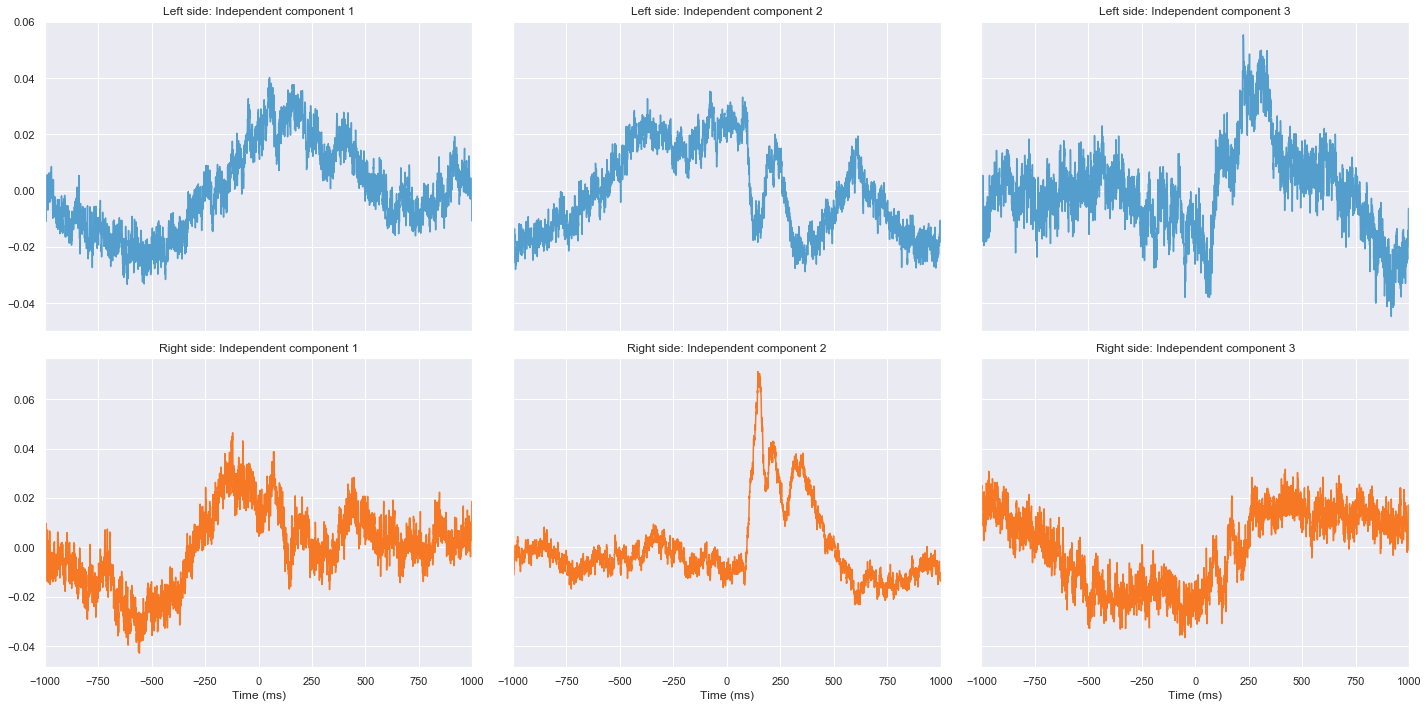

In [138]:
# Compare ICs,left vs. right

# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc=np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc=np.mean)

# Compare ICs L v R -> ? diff in activity
leftChannels_averaged = leftChannels.groupby('Time').mean()
rightChannels_averaged = rightChannels.groupby('Time').mean()

# 4097 x 6 array of average responses at each channel over time
signalsLeft = np.array([leftChannels.groupby('Time').mean()[elec] for elec in electrodesLeft]).T
signalsRight = np.array([rightChannels.groupby('Time').mean()[elec] for elec in electrodesRight]).T

# Compute ICA
ica = FastICA(n_components = 3)
signalsLeft_ = ica.fit_transform(signalsLeft)
signalsRight_ = ica.fit_transform(signalsRight)

# Plot ICs
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(20,10))

for i, (icL, icR) in enumerate(zip(signalsLeft_.T, signalsRight_.T)):
    ax[0,i].plot(t, icL, color=colours_left[1])
    ax[0,i].set_title('Left side: Independent component {}'.format(i+1))
    
    ax[1,i].plot(t, icR, color=colours_right[1])
    ax[1,i].set_title('Right side: Independent component {}'.format(i+1))
    ax[1,i].set_xlabel('Time (ms)')
    ax[1,i].set_xlim([-1000,1000])
    
fig.tight_layout()

By decomposing the signals from the left (blue) and right (orange) ACC into their sources, we can see that the activities that produced the recorded signals on each side appear to differ.

Looking at the left side, the first source has a double-peaked structure post-feedback, and likely relates to the feedback response seen on the average signal. Similarly, the second source shows a response at 200 - 500ms post-feedback, again suggesting this left-sided source is related to feedback response. The third left-sided source shows a peak in the -500ms to 0ms interval and a trough at roughly 250ms post-feedback, suggesting this may be related to prediction and to the immediate feedback response.

On the right, we see a different set of patterns. The first source appears to be related to the feedback response, with a sharp first peak and a damped double-peak structure. The second and third sources show activity primarily in the pre-feedback period, with the second source showing a distinction between the response at 500ms pre-feedback and at 200ms pre-feedback, supporting earlier suggestions of differing components to the anticipation period. The third component shows a prolonged trough during the 500ms prediction window.


These results support the hypothesis that the left and right ACC respond differently to feedback, and are components in a distributed prediction network. Particularly, the source decomposition here suggests that the left ACC is primarily concerned with feedback response, while the activity of the right ACC is more associated with prediction.

The above suggests that the left and right ACCs demonstrate differing responses to feedback. These analyses support the hypothesis that there is a spatially distributed network within the ACCs, with distinct areas carrying out different activities. We can see that the pre-feedback period appears to be split into an "early" window at 500ms before feedback and a later response at 200ms pre-feedback, corresponding to the "preparatory" phase response seen earlier. These seem to be carried out by different areas, with the 200ms predictive window driven by a centre of activity in the right ACC. Similarly, the post-feedback response is characterised by a strong double-peak response in left ACC centres, with a damped response in the right ACC roughly 20ms later, suggestive of communication between the two sides, with the right ACC node responding to activity in a left ACC centre.

The results so far have demonstrated differences in activity between the left and right ACC. The hypothesis of a spatially distributed network within the ACCs bilaterally is supported by the decomposition of the signal into distinct sources that appear to correspond to the activities seen. In the case of a spatially distributed network, we expect the activity at individual electrodes to vary due to the differing proportions of different sources recorded at each.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: -997.0703125ms to -996.58203125ms
Interval: -924.31640625ms to -923.828125ms
Interval: -885.7421875ms to -885.7421875ms
Interval: -845.703125ms to -844.7265625ms
Interval: -843.75ms to -843.26171875ms
Interval: -837.40234375ms to -833.984375ms
Interval: -832.51953125ms to -832.51953125ms
Interval: -827.63671875ms to -827.63671875ms
Interval: -826.66015625ms to -824.21875ms
Interval: -817.3828125ms to -817.3828125ms
Interval: -816.40625ms to -815.4296875ms
Interval: -814.453125ms to -812.98828125ms
Interval: -807.6171875ms to -789.55078125ms
Interval: -788.57421875ms to -782.2265625ms
Interval: -781.25ms to -780.76171875ms
Interval: -779.296875ms to -771.97265625ms
Interval: -770.01953125ms to -762.20703125ms
Interval: -761.23046875ms to -322.265625ms
Interval: -318.84765625ms to -318.84765625ms
Interval: -317.3828125ms to -317.3828125ms
Interval: -298.828125ms to -298.33984375ms
Interval: -296.38671875ms to -29

Text(0.5, 1.0, 'Average response for each electrode')

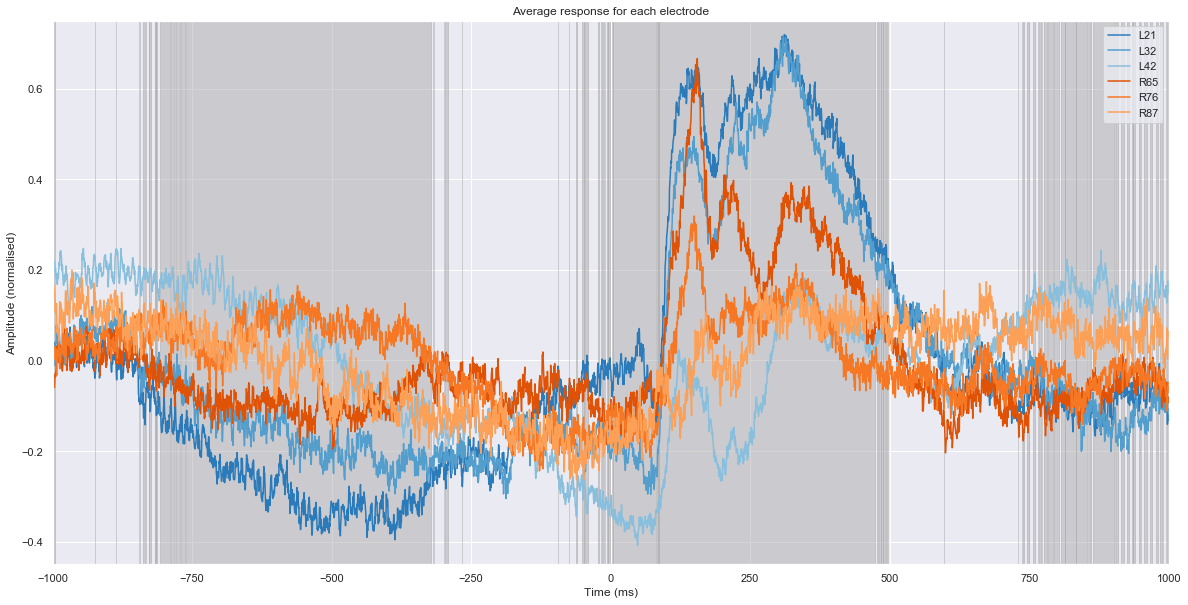

In [852]:
# Plot all electrodes with differences highlighted
# One-way ANOVA with all electrodes as variables

# Get data from df
allChannels = pd.pivot_table(df, values = electrodes, index = ['Time', 'Trial'], aggfunc = np.mean)

pvals = []
for t in df.Time.unique():
    anova = stats.f_oneway(allChannels.L21[t], allChannels.L32[t], allChannels.L42[t], allChannels.R65[t], allChannels.R76[t], allChannels.R87[t])
    pvals.append(anova[1])

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if index < len(pvals)-1: # Avoids error if last pval < 0.05
        if pvals[index] < threshold and pvals[index-1] > threshold:
            startinds.append(index)

        if pvals[index] < threshold and pvals[index+1] > threshold:
            endinds.append(index)
if pvals[-1] < threshold: # Add last index to end of intervals if last value significant
    endinds.append(len(pvals)-1)
        
intervals = zip(startinds, endinds)

# Plot all electrodes with intervals highlighted
fig, ax = plt.subplots()

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax.fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
# Plot all electrodes, split by L and R
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

for i, left in enumerate(electrodesLeft):
    ax.plot(t, allChannels_averaged[left], label=left, color=colours_left[i])
    
for i, right in enumerate(electrodesRight):
    ax.plot(t, allChannels_averaged[right], label=right, color=colours_right[i])
    
ax.legend()
ax.set_xlim([-1000,1000])
ax.set_ylim([-0.45, 0.75])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (normalised)')
ax.set_title('Average response for each electrode')

Here we see the activity of all electrodes plotted together. Highlighted areas are those where the activity of all electrodes differ significantly, based on one-way analysis of variance. As anticipated from the comparison of the average left- and right-sided signal, we see differences between electrodes in the early pre-feedback period and during the 100 - 500ms post-feedback response. There is co-ordinated activity across all electrodes in the late predictive window. The morphology of the individual signals suggests that these are recording from populations with distinct activities; we expect these inter-electrode differences to be evident within each side.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
(Left) Interval: -846.19140625ms to -843.26171875ms
(Left) Interval: -842.28515625ms to -842.28515625ms
(Left) Interval: -838.8671875ms to -832.51953125ms
(Left) Interval: -828.125ms to -828.125ms
(Left) Interval: -826.66015625ms to -822.75390625ms
(Left) Interval: -818.84765625ms to -818.359375ms
(Left) Interval: -817.3828125ms to -817.3828125ms
(Left) Interval: -816.40625ms to -813.96484375ms
(Left) Interval: -812.98828125ms to -812.98828125ms
(Left) Interval: -807.6171875ms to -801.26953125ms
(Left) Interval: -799.8046875ms to -789.55078125ms
(Left) Interval: -788.57421875ms to -782.2265625ms
(Left) Interval: -779.296875ms to -773.4375ms
(Left) Interval: -770.01953125ms to -770.01953125ms
(Left) Interval: -768.5546875ms to -762.6953125ms
(Left) Interval: -759.765625ms to -470.21484375ms
(Left) Interval: -467.7734375ms to -464.35546875ms
(Left) Interval: -463.37890625ms to -463.37890625ms
(Left) Interval: -457.51953125

Text(0.5, 1.0, 'Right ACC: average response for each electrode')

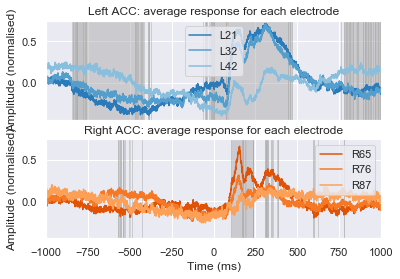

In [120]:
# Plot ANOVA of timepoints, L & R
# Get data from df
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)

pvalsLeft = []
pvalsRight = []
for t in df.Time.unique():
    anova = stats.f_oneway(leftChannels.L21[t], leftChannels.L32[t], leftChannels.L42[t])
    pvalsLeft.append(anova[1])
    
    anova = stats.f_oneway(rightChannels.R65[t], rightChannels.R76[t], rightChannels.R87[t])
    pvalsRight.append(anova[1])

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startindsLeft = [] # List of starts of intervals
endindsLeft = [] # List of ends of intervals
for index, value in enumerate(pvalsLeft):
    if index < len(pvalsLeft)-1: # Avoids error if last pval < 0.05
        if pvalsLeft[index] < threshold and pvalsLeft[index-1] > threshold:
            startindsLeft.append(index)

        if pvalsLeft[index] < threshold and pvalsLeft[index+1] > threshold:
            endindsLeft.append(index)
            
if pvalsLeft[-1] < threshold: # Add last index to end of intervals if last value significant
    endindsLeft.append(len(pvalsLeft)-1)
    
intervalsLeft = zip(startindsLeft, endindsLeft)

startindsRight = [] # List of starts of intervals
endindsRight = [] # List of ends of interval
for index, value in enumerate(pvalsRight):
    if index < len(pvalsRight)-1: # Avoids error if last pval < 0.05
        if pvalsRight[index] < threshold and pvalsRight[index-1] > threshold:
            startindsRight.append(index)

        if pvalsRight[index] < threshold and pvalsRight[index+1] > threshold:
            endindsRight.append(index)
        
if pvalsRight[-1] < threshold: # Add last index to end of intervals if last value significant
    endindsRight.append(len(pvalsRight)-1)
        
intervalsRight = zip(startindsRight, endindsRight)

# Create plot
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col');

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervalsLeft:
    ax[0].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Left) Interval: {0}ms to {1}ms".format(t[start], t[end]))
for start, end in intervalsRight:
    ax[1].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Right) Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
# Plot all electrodes, split by L and R
allChannels = pd.pivot_table(df, values = electrodes, index = ['Trial', 'Time'])

# Average across trials
allChannels_averaged = allChannels.groupby('Time').mean() # Mean of each electrode across trials

for i, left in enumerate(electrodesLeft):
    ax[0].plot(t, allChannels_averaged[left], label=left, color=colours_left[i])
    
for i, right in enumerate(electrodesRight):
    ax[1].plot(t, allChannels_averaged[right], label=right, color=colours_right[i])
    
ax[0].legend()
ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-0.45, 0.75])
ax[0].set_ylabel('Amplitude (normalised)')
ax[0].set_title('Left ACC: average response for each electrode')

ax[1].legend()
ax[1].set_xlim([-1000,1000])
ax[1].set_ylim([-0.45, 0.75])
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Amplitude (normalised)')
ax[1].set_title('Right ACC: average response for each electrode')

This plot shows the average signal for each electrode in the left (blue) and right (orange) ACC. Highlighted regions show the areas where the signals recorded on each electrode within each side differ to a statistically significant degree, based on analysis of variance with a significance threshold of $p < 0.0001$ Bonferroni corrected for the number of samples tested, for a pointwise significance threshold of $p < 0.0001 \div 4097 = 2 \times 10^{-8}$.

These results clearly demonstrate that the activity at different electrodes within one side differ during the activity intervals previously identified. This is consistent with our suggestion that each source identified on decomposition of the signal represents a spatially distinct node within an ACC prediction network, and that each electrode is recording contributions from these sources with differing proportions based on its spatial location. This very strongly supports our hypothesis of a network of areas with distinct roles distributed throughout the ACC bilaterally. There are differences in activity between hemispheres, and differences between regions within individual hemispheres. Based on our decomposition analysis, each distributed region appears to respond to feedback slightly differently, playing different roles in our hypothesised network.

Looking at the individual plots in more detail, we can see that on the left, electrodes differ in the early prediction period, but demonstrate coordinated activity in the late prediction window, consistent with what we have seen in the averaged results. We see a notable interval of difference in activity from 89ms to 446ms post-feedback, corresponding to the feedback response, encompassing the "double-peak" we have noted in the averaged recordings. Notably, while L21 and L32 demonstrate very similar feedback responses, L42 has a differing morphology. This is consistent with the idea that electrode L42 is recording from a population within the left ACC that responds to feedback, but in a different way to those seen by the other electrodes on this side. This is consistent with the suggestion of a spatially distributed network with distinct activity patterns.

On the right, we see coordinated activity between electrodes throughout the pre-feedback period. This is consistent with widespread prediction-related activity within the right ACC. In the post-feedback period, we see intervals of significant difference from 105 to 173ms and from 190 to 238ms post-feedback. These relate to the early response to feedback. This is again consistent with a spatially distributed set of nodes that respond differently to feedback.

Of particular note here, within the 105ms to 173ms window, we again see the delay in time-to-peak between electrode recordings in the right ACC. This is suggestive of a propagation of feedback-related activity throughout nodes in this area, with peaks occuring at a slight lag between populations.

In [871]:
# Shows propagation - peak occurs later & lower
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

rvals = []
timetopeak=[]
for trial in df.Trial.unique():
    peakvals = [rightChannels[elec][trial][0:300].max() for elec in electrodesRight]
    indices = [rightChannels[elec][trial][0:300].idxmax() for elec in electrodesRight]
    
    result = stats.pearsonr([1, 2, 3], indices)
    rvals.append(result[1])
    timetopeak.append(indices)
    
ttest = stats.ttest_1samp(rvals, 0)

print("r = {0} +/- {1}".format(np.mean(rvals), np.std(rvals)))
print("p = {}".format(ttest.pvalue))

r = 0.48749726260908943 +/- 0.28647153044072415
p = 3.15181341472675e-240


We can see here that there is a significant lag in time to peak between electrodes on the right ($p < 0.0001$); this is consistent with a spead of activity to spatially distributed network nodes.

We have now demonstrated that the ACC responds to feedback, and that this feedback response differs between sides, and between electrodes within each side. We have shown that there are windows of significant activity both before and after feedback, corresponding to feedback prediction and response. We have shown that these different activities can be separated out and are carried out by spatially distinct regions throughout the ACC. The right ACC appears to be particularly active in outcome prediction, while the left ACC has a stronger response post-feedback. However, the left ACC also shows a pre-feedback response and is involved in the late prediction window anticipatory phase reset, and the left ACC shows a lagged peak response to feedback and a propagation of feedback-related activity throughout the areas recorded. This is suggestive of communication between the distinct network nodes that we have identified.

### ACC network nodes communicate to co-ordinate activity
We have demonstrated that the ACC contains a network of spatially distributed regions that respond differently during distinct time windows pre- and post-feedback. If our hypothesis of an ACC prediction network is correct, we expect to see evidence of communication between areas within this prediction network at physiologically plausible intervals. Further, we expect to be able to demonstrate directionality of these effects, in line with one network region influencing the activity of another.

Given the intervals and relationships we have identified, we expect to see a role for right ACC network centres in outcome prediction. Specifically, we anticipate that the late anticipation window, characterised by marked activity in the right ACC and a subsequent coordinated prepatatory phase reset across the whole network, will be associated with communication from the right ACC to the left ACC - i.e. the right ACC is making outcome predictions, and signals to the left ACC to prepare for feedback. 

Within the post-feedback period, we expect to see communication from the left ACC to the right ACC within the 100ms to 500ms post-feedback window we have identified. This would be consistent with the apparent dominance of a post-feedback response in the left ACC, the observed 20ms lag to response in the right ACC, and the propagation of activity through right ACC centres.

We will therefore look for coherence between signals from the right and left ACC at a series of time lags within the activity intervals identified. We will repeat this, lagging both sides, to investigate whether this effect is directional.

Maximum coherence: 0.5628183793281993 at 21ms; p = 0.00033369614651601625
At 22ms, peak coherence is 0.8820270533779122 at 24.0Hz
Second peak of 0.6064387366887222 at 56.0Hz
Also 0.8477547171571346 at sub-8.0Hz


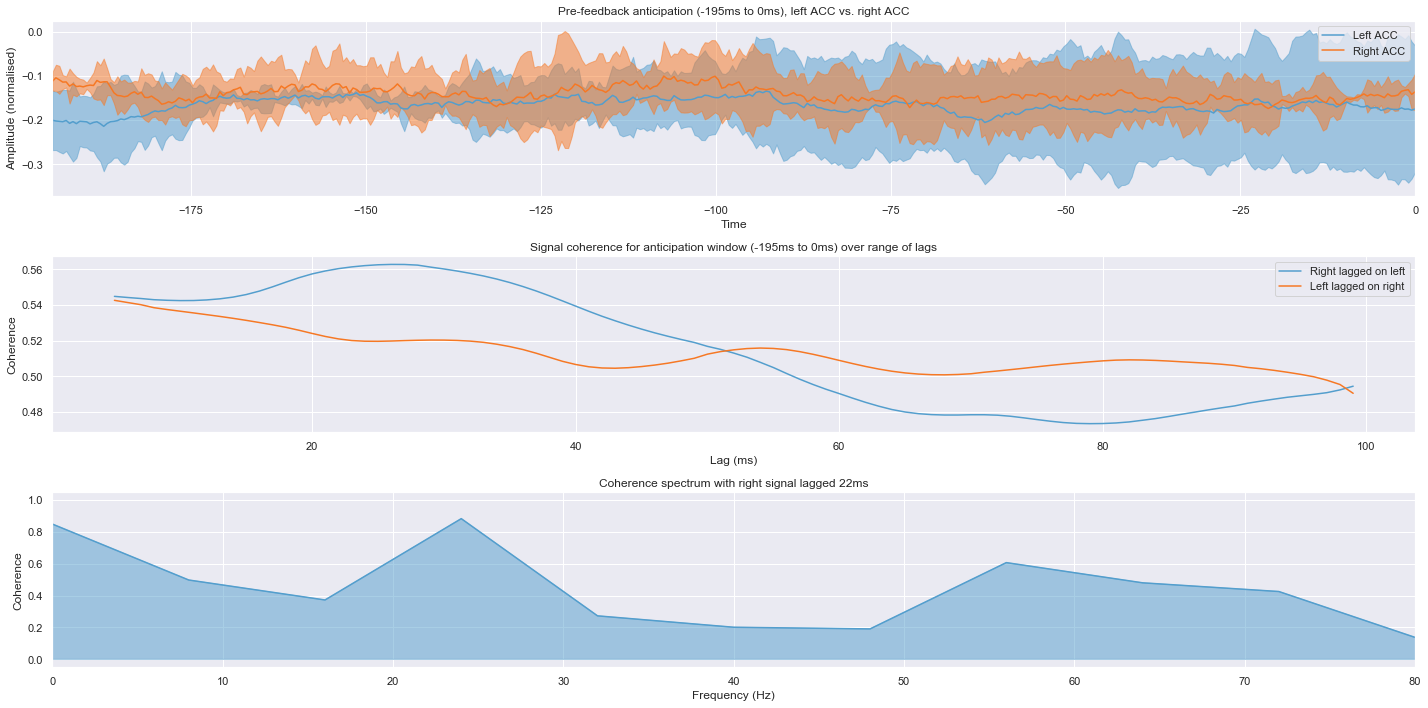

In [125]:
# Pre-feedback: coherence at lags, R -> L and L -> R
# Try lagged coherence over range of lags for data within interval
leftChannels = pd.pivot_table(df, values=electrodesLeft, index=['Time', 'Trial'])
rightChannels = pd.pivot_table(df, values=electrodesRight, index=['Time', 'Trial'])

leftChannels_averaged = leftChannels.groupby('Time').mean()
rightChannels_averaged = rightChannels.groupby('Time').mean()

leftChannels_mean = leftChannels_averaged.mean(axis=1)
rightChannels_mean= rightChannels_averaged.mean(axis=1)

# Lag right side, looking at 200 - 400ms interval
cohvalsLtoR=[]
pvalsLtoR = []
cohvalsRtoL=[]
pvalsRtoL = []
for lag in range(5, 100):
    f, CxyLtoR = signal.coherence(leftChannels_mean[-195:0], rightChannels_mean[-195+lag:0+lag], fs=2048)
    f, CxyRtoL = signal.coherence(leftChannels_mean[-195+lag:0+lag], rightChannels_mean[-195:0], fs=2048)
    
    ttest = stats.ttest_1samp(CxyLtoR[:10], 0)
    pvalsLtoR.append(ttest.pvalue)
    cohvalsLtoR.append(np.mean(CxyLtoR))
    
    ttest = stats.ttest_1samp(CxyRtoL[:10], 0)
    pvalsRtoL.append(ttest.pvalue)
    cohvalsRtoL.append(np.mean(CxyRtoL))

##### Coherence spectrum at 22ms lag on interval -195:0
f, Cxy = signal.coherence(leftChannels_mean[-195:0], rightChannels_mean[-195+22:0+22], fs=2048)
    
##### Get average response over interval to plot along with coherence    
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
leftChannels_averaged = leftChannels.groupby('Time').mean() # Mean of each electrode on left across trials
rightChannels_averaged = rightChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
leftChannels_mean = leftChannels_averaged.mean(axis=1)
leftChannels_SD = leftChannels_averaged.std(axis=1)

rightChannels_mean = rightChannels_averaged.mean(axis=1)
rightChannels_SD = rightChannels_averaged.std(axis=1)

### Create plot
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))

leftChannels_mean[-195:0].plot(ax=ax[0], color=colours_left[1])
ax[0].fill_between(leftChannels_mean[-195:0].index, leftChannels_mean[-195:0]+leftChannels_SD[-195:0], leftChannels_mean[-195:0]-leftChannels_SD[-195:0], alpha=0.5, color=colours_left[1])
rightChannels_mean[-195:0].plot(ax=ax[0], color=colours_right[1])
ax[0].fill_between(rightChannels_mean[-195:0].index, rightChannels_mean[-195:0]+rightChannels_SD[-195:0], rightChannels_mean[-195:0]-rightChannels_SD[-195:0], alpha=0.5, color=colours_right[1])
ax[0].legend(['Left ACC', 'Right ACC'])
ax[0].set_title('Pre-feedback anticipation (-195ms to 0ms), left ACC vs. right ACC')
ax[0].set_ylabel('Amplitude (normalised)')

ax[1].plot([t for t in range(5,100)], cohvalsLtoR, color=colours_left[1], label="Right lagged on left")
ax[1].plot([t for t in range(5,100)], cohvalsRtoL, color=colours_right[1], label='Left lagged on right')
ax[1].set_xlabel('Lag (ms)')
ax[1].set_ylabel("Coherence")
ax[1].set_title("Signal coherence for anticipation window (-195ms to 0ms) over range of lags")
ax[1].legend()

ax[2].plot(f, Cxy, color=colours_left[1])
ax[2].fill_between(f, Cxy, np.zeros(len(f)), color=colours_left[1], alpha=0.5)
ax[2].set_xlim([0, 80])
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Coherence")
ax[2].set_title("Coherence spectrum with right signal lagged 21ms")

fig.tight_layout()

print("Maximum coherence: {0} at {1}ms; p = {2}".format(np.max(cohvalsLtoR), np.argmax(cohvalsLtoR), pvalsLtoR[np.argmax(cohvalsLtoR)]))
print("At 22ms, peak coherence is {0} at {1}Hz".format(np.max(Cxy[:10]), f[np.argmax(Cxy[:10])]))
print("Second peak of {0} at {1}Hz".format(Cxy[7], f[7]))
print("Also {0} at sub-{1}Hz".format(Cxy[0], f[1]))
# R lagged on L -> peak at 20ms lag -195-0 -- L causing activity in R: revise earlier -> prolonged activity in L -> triggers R sided activity
# Based on difference between regions demonstrated on L v R: previous activity "triggers" interaction L -> R to prepare for input (L actively involved, R predicting)

This plot shows the time series for the average signals from the left and right ACC superimposed during the -195ms to 0ms anticipation window. In order to investigate whether there is communication between the areas recorded, we looked at broadband coherence between the signals within this window at a range of lags from 5ms to 100ms, shown in the middle plot. We can see the peak coherence value occurs when the right ACC signal is lagged on the left by 21ms (coherence = 0.563, p = 0.0003). The coherence between the left ACC signal and the lagged right ACC signal builds to this point over a range of lags, then falls of after this. The coherence between the right ACC and the lagged left ACC signal shows a gradual drop-off as lag is increased.

The greatest coherence is seen between the left ACC signal and the right ACC signal 21ms later. This suggests that there is communication between these areas within this interval. This is consistent with the apparent left ACC-driven "early" anticipation response at 500ms pre-feedback "triggering" the widespread phase-reset and coordinated activity seen in this 200ms late anticipatory window.

To examine the nature of this communication, we can examine the coherence spectrum with the right ACC signal lagged by 21ms. Here we see that this coherence is driven mostly by frequencies in the sub-8Hz and 10-20Hz range, and there is also a peak in the 50-60Hz range. We can further then further explore the communication within the ACC network within this anticipatory window by investigating the pairwise coherence between signals at each electrode within the peak frequency band at a 21ms lag.

In [238]:
# Circle plot: get pairwise connectivity for each electrode in interval
# -195 to 0, right lagged 22ms
# Set diagonal to 1
allChannels = pd.pivot_table(df, values=electrodes, index=['Time', 'Trial'])
allChannels_averaged = allChannels.groupby('Time').mean()

coherences = np.ones([6,6]) # Matrix to fill

# Cycle through each electrode & get coherence with all other electrodes
for row, elec1 in enumerate(electrodes):
    for column, elec2 in enumerate(electrodes):
        f, Cxy = signal.coherence(allChannels_averaged[elec1][-195:0], allChannels_averaged[elec2][-195+22:0+22], fs=2048)
        
        #coherences[row,column] = np.mean(Cxy[:10]) # Use mean in range (< 80Hz)
        coherences[row,column] = Cxy[3] # Use peak value identified in spectrum
        
colors = [colours_left[0], colours_left[1], colours_left[2], colours_right[0], colours_right[1], colours_right[2]]

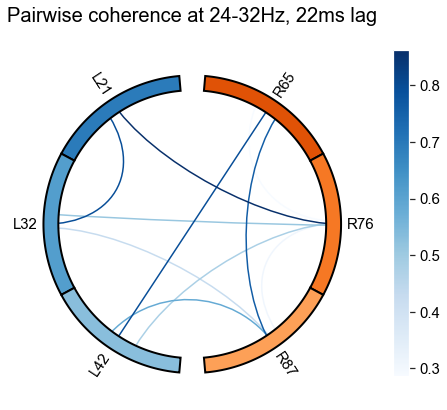

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x24f4c542808>)

In [239]:
angles = circular_layout(electrodes, ['L21', 'L32', 'L42', 'R87', 'R76', 'R65'],
                         start_pos=90, start_between=True,
                         group_boundaries=[0, 3], group_sep=10
                        )

plot_connectivity_circle(coherences, electrodes,
                         n_lines=10,
                         title="Pairwise coherence at 24-32Hz, 22ms lag",
                         facecolor="white", textcolor="black", colormap="Blues",
                         node_colors=colors,
                         node_angles=angles,
                         colorbar_size=0.75, colorbar_pos=(0,0.6), 
                         fontsize_names=15, fontsize_colorbar=15, fontsize_title=20,
                         node_linewidth=2,
                         padding=2
                        )

We can see here the pairwise coherence between all individual electrodes at 24-32Hz at a lag of 22ms. We are only visualising the ten strongest connections. We can see strongly coordinated activity between individual areas between and within hemispheres. This is suggestive of strongly coordinated activity throughout the ACC network, consistent with the -200ms preparatory response we have seen, with a widespread phase reset and similar patterns of activity in all areas in preparation for an input. This further supports the idea that feedback-related activity is distributed throughout an ACC network, with some areas responding differently and communicating with differing areas.

These results seem to suggest a flow of information from centres in the left ACC to centres in the right ACC. It is important to note, however, that there is also a notable level of coherence when the left ACC signal is lagged - indicating bidirectional communication between ACC centres. This is consistent with our suggestion of a distributed network, and a complex arrangement of mutually communicating nodes is consistent with our demonstration of differing patterns of activity between different electrodes within the same hemisphere.

Given this apparent spatial discretisation of feedback-related activity & communication between activity sources, we will investigate whether there is evidence of communication between signals in source space. This will allow us to investigate whether specific sources of activity are communicating with each other within the ACC network.

Step at 20.01953125: F = 5.803097994891795, p = 3.1485474781968372e-28


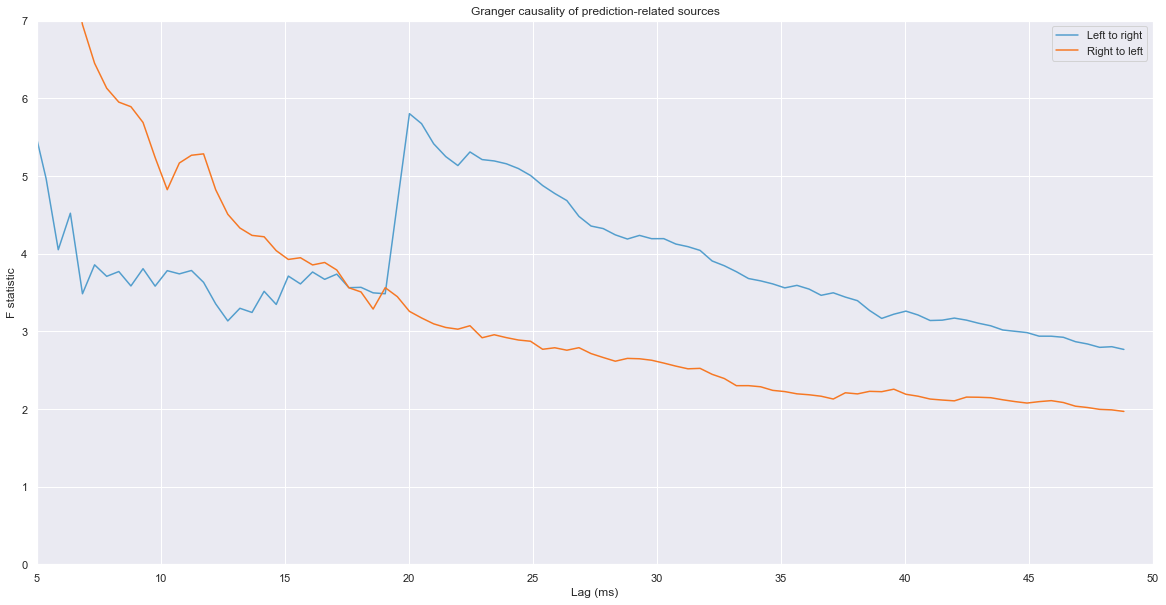

In [242]:
# GC in source space: early prediction on L and late prediction on R
# Plot F-statistic for GC in both directions
dataLtoR = np.array([np.diff(signalsRight_.T[2]), np.diff(signalsLeft_.T[0])]).T
dataRtoL = np.array([np.diff(signalsLeft_.T[0]), np.diff(signalsRight_.T[2])]).T

gc_resLtoR = grangercausalitytests(dataLtoR,100,verbose=False)
gc_resRtoL = grangercausalitytests(dataRtoL,100,verbose=False)

# Define intervals using t-tests -> test over these intervals over lags
# Choose test statistic & plot this
# Can then take max significance as area of max communication
# Also: demonstrate directionality by reversing
# Can then use these lags & directions for transfer entropy test

# At -150 to 0, early R -> L; L-> R less so, at later lags: bidirectional feedback, differing temporal dynamics
# 150 to 450: L -> R v early; no R -> L

# Can look at whether there is difference in communication C v I (i.e. L v R under conditions of C, I)
# Using intervals & directions already determined, look at whether test statistic plots differ for pre & post (i.e. is causality different with C v I)

FvalsLtoR = [gc_resLtoR[lag][0]['ssr_ftest'][0] for lag in range(1,101)]
FvalsRtoL = [gc_resRtoL[lag][0]['ssr_ftest'][0] for lag in range(1,101)]

timepoints = [t * 1000/2048 for t in range(1,101)]

fig,ax = plt.subplots(figsize=(20,10))

ax.plot(timepoints,FvalsLtoR, color=colours_left[1], label="Left to right")
ax.plot(timepoints,FvalsRtoL, color=colours_right[1], label="Right to left")
ax.legend()
ax.set_ylabel('F statistic')
ax.set_xlabel('Lag (ms)')
ax.set_xlim([5, 50])
ax.set_ylim([0, 7])
ax.set_title('Granger causality of prediction-related sources')

print("Step at {0}: F = {1}, p = {2}".format(timepoints[np.argmax(FvalsLtoR[5:])+5], np.max(FvalsLtoR[5:]), gc_resLtoR[42][0]['ssr_ftest'][1])) # Add 1 to index of gc_res as lags 1 - 100 (not 0 indexed)

This plot demonstrates Granger causality between (the first-difference of) independent sources related to pre-feedback anticipation in the source-decomposed signals over a range of lags. This measures whether our ability predict future values of a signal is improved by knowledge of past values of another signal. This implies a directional flow of information. Here, we are able to demonstrate the sources we had identified in the left and right ACC that appeared to produce activity related to the early (-500ms) and late (-200ms) respectively communicate with each other.

Notably, we see an immediate peak in the F-statistic for right-to-left communication; given the physiologically implausibly short delay, it is likely that this is a result of the ongoing bidirectional communication identified, and the overall response to feedback throughout the network rather than a true communication between these activity sources. This is supported by the consistent drop-off in the F-statistic, suggesting that the increased predictive ability seen here in simply a function of the broad event-related similarity of the feedback-locked activity sources.

More interestingly, we see a jump in the test statistic for left-to-right communication at 21ms (F = 5.75). This is statistically significant at a threshold of $p < 0.0001$, Bonferonni corrected for the number of lags tested (i.e. $p < 0.0001 \div 100$).

This strongly supports our hypothesis of a network of distributed activity centres that carry out different activities related to the prediction and response to feedback, and that these activity sources communicate with each other to transfer information around the network. Specifically, we see here evidence of bidirectional communication between the left and right ACC during the pre-feedback period. This is then followed by a signal from the left ACC at the beginning of the late anticipation window at -200ms, with the right ACC responding 21ms later. This activity is primarily driven by identifiable sources within the left and right ACC which appear to correspond to the early and late predictive response respectively.

These results allow us to understand the communication dynamic of the ACC prediction network.

We will then investigate whether there are similar patterns of communication during the post-feedback response.

Maximum coherence: 0.21296997121838324 at 15ms; p = 0.0014210122500876048
At 15ms, peak coherence is 0.7875764803507916 at 8.0Hz
Second peak of 0.3720698420913146 at 56.0Hz
Also 0.5872538096496097 at sub-8.0Hz


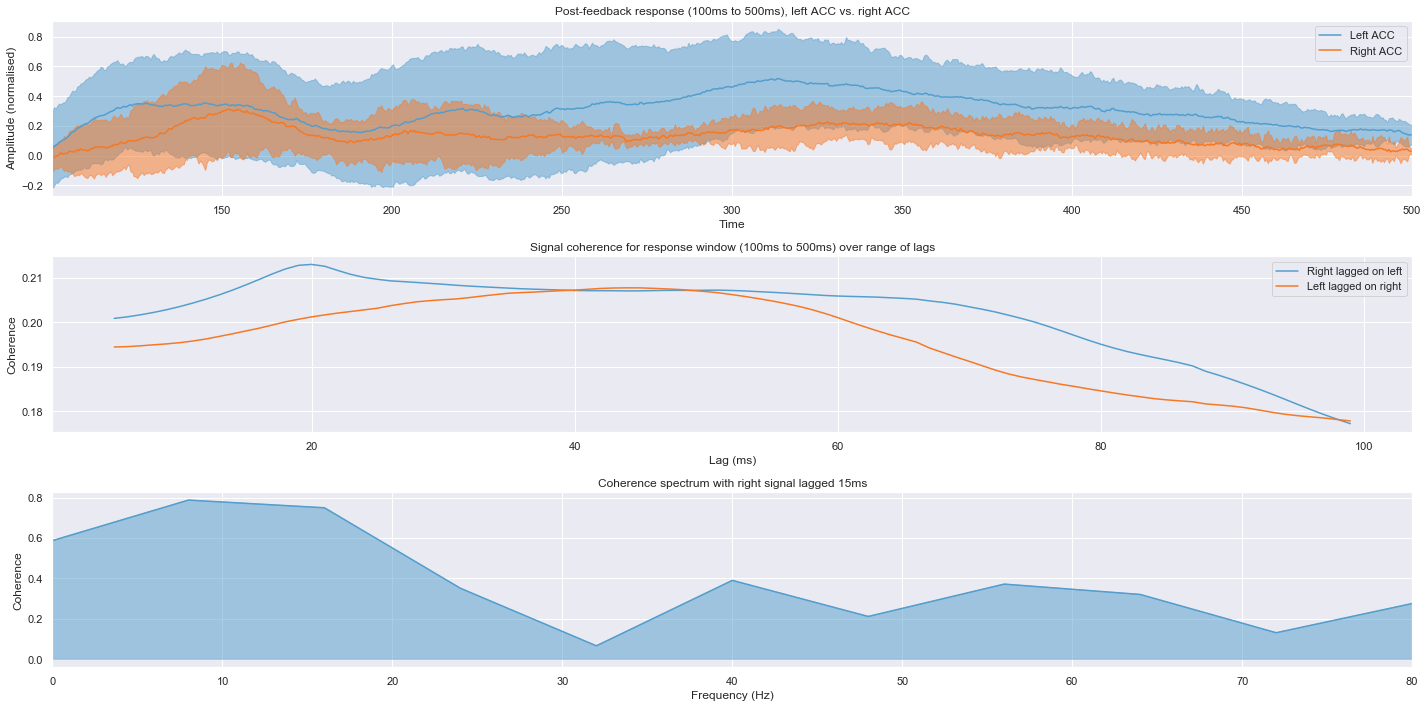

In [116]:
# Post-feedback: coherence at lags, R -> L and L -> R
# Try lagged coherence over range of lags for data within interval
leftChannels = pd.pivot_table(df, values=electrodesLeft, index=['Time', 'Trial'])
rightChannels = pd.pivot_table(df, values=electrodesRight, index=['Time', 'Trial'])

leftChannels_averaged = leftChannels.groupby('Time').mean()
rightChannels_averaged = rightChannels.groupby('Time').mean()

leftChannels_mean = leftChannels_averaged.mean(axis=1)
rightChannels_mean= rightChannels_averaged.mean(axis=1)

# Lag right side, looking at 200 - 400ms interval
cohvalsLtoR=[]
pvalsLtoR = []
cohvalsRtoL=[]
pvalsRtoL = []
for lag in range(5, 100):
    f, CxyLtoR = signal.coherence(leftChannels_mean[100:500], rightChannels_mean[100+lag:500+lag], fs=2048)
    f, CxyRtoL = signal.coherence(leftChannels_mean[100+lag:500+lag], rightChannels_mean[100:500], fs=2048)
    
    ttest = stats.ttest_1samp(CxyLtoR[:10], 0)
    pvalsLtoR.append(ttest.pvalue)
    cohvalsLtoR.append(np.mean(CxyLtoR))
    
    ttest = stats.ttest_1samp(CxyRtoL[:10], 0)
    pvalsRtoL.append(ttest.pvalue)
    cohvalsRtoL.append(np.mean(CxyRtoL))

##### Coherence spectrum at 22ms lag on interval -195:0
f, Cxy = signal.coherence(leftChannels_mean[100:500], rightChannels_mean[100+15:500+15], fs=2048)

##### Get average response over interval to plot along with coherence    
leftChannels = pd.pivot_table(df, values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
rightChannels = pd.pivot_table(df, values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
leftChannels_averaged = leftChannels.groupby('Time').mean() # Mean of each electrode on left across trials
rightChannels_averaged = rightChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
leftChannels_mean = leftChannels_averaged.mean(axis=1)
leftChannels_SD = leftChannels_averaged.std(axis=1)

rightChannels_mean = rightChannels_averaged.mean(axis=1)
rightChannels_SD = rightChannels_averaged.std(axis=1)
    
### Create plot
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))

leftChannels_mean[100:500].plot(ax=ax[0], color=colours_left[1])
ax[0].fill_between(leftChannels_mean[100:500].index, leftChannels_mean[100:500]+leftChannels_SD[100:500], leftChannels_mean[100:500]-leftChannels_SD[100:500], alpha=0.5, color=colours_left[1])
rightChannels_mean[100:500].plot(ax=ax[0], color=colours_right[1])
ax[0].fill_between(rightChannels_mean[100:500].index, rightChannels_mean[100:500]+rightChannels_SD[100:500], rightChannels_mean[100:500]-rightChannels_SD[100:500], alpha=0.5, color=colours_right[1])
ax[0].legend(['Left ACC', 'Right ACC'])
ax[0].set_title('Post-feedback response (100ms to 500ms), left ACC vs. right ACC')
ax[0].set_ylabel('Amplitude (normalised)')

ax[1].plot([t for t in range(5,100)], cohvalsLtoR, color=colours_left[1], label="Right lagged on left")
ax[1].plot([t for t in range(5,100)], cohvalsRtoL, color=colours_right[1], label='Left lagged on right')
ax[1].set_xlabel('Lag (ms)')
ax[1].set_ylabel("Coherence")
ax[1].set_title("Signal coherence for response window (100ms to 500ms) over range of lags")
ax[1].legend()

ax[2].plot(f, Cxy, color=colours_left[1])
ax[2].fill_between(f, Cxy, np.zeros(len(f)), color=colours_left[1], alpha=0.5)
ax[2].set_xlim([0, 80])
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Coherence")#
ax[2].set_title("Coherence spectrum with right signal lagged 15ms")

fig.tight_layout()

print("Maximum coherence: {0} at {1}ms; p = {2}".format(np.max(cohvalsLtoR), np.argmax(cohvalsLtoR), pvalsLtoR[np.argmax(cohvalsLtoR)]))
print("At 15ms, peak coherence is {0} at {1}Hz".format(np.max(Cxy[:10]), f[np.argmax(Cxy[:10])]))
print("Second peak of {0} at {1}Hz".format(Cxy[7], f[7]))
print("Also {0} at sub-{1}Hz".format(Cxy[0], f[1]))
# R lagged on L -> peak at 20ms lag -195-0 -- L causing activity in R: revise earlier -> prolonged activity in L -> triggers R sided activity
# Based on difference between regions demonstrated on L v R: previous activity "triggers" interaction L -> R to prepare for input (L actively involved, R predicting)

Here we see the average signals in the left (blue) and right (orange) ACC over the 100ms to 500ms post-feedback response window. As above, below we can see the coherence between each signal and the lagged signal on the other side over a range of lags. We can see that the peak coherence occurs between the left ACC signal and the right ACC signal 15ms later (p = 0.001). This is suggestive of communication between the left and right ACC in this interval, consistent with the observed 20ms lag in the beginning of the early response between sides and the idea of the left ACC's immediate response signalling to the right ACC, resulting in a response here. This is consistent with the network distribution we had outlined earlier, with an immediate response in the left ACC, which signals to the right ACC, which responds to this with propagating activity throughout right ACC centres.

Below this, we can see the frequency spectrum at this 15ms lag. Here, we see that this coherence is mostly driven by frequencies in the sub-10Hz band. Notably, the contribution of >40Hz frequencies seen in pre-feedback communication is less evident here, and the overall coherence is lower; this suggests a less coordinated response that was seen pre-feedback. 

This may be due to a less consistent response than the reliable phase-reset in the late anticipation window, possibly due to differences in signalling between sides under different conditions. This would suggest that the network communicates differently under differing outcome conditions. We will investigate this by separating trials by outcome to see if this pattern of communication is different based on the nature of feedback. This would be consistent with a network that responds to outcomes and updates itself differently based on this information.

Before this, we will again investigate the pattern of pairwise connectivity between electrode signals in the interval identified at the frequency band we have identified so that we can appreciate the pattern of connections between different regions within the ACC network 

In [236]:
# Circle plot: get pairwise connectivity for each electrode in interval
# 100 to 500, right lagged 15ms
# Set diagonal to 1
allChannels = pd.pivot_table(df, values=electrodes, index=['Time', 'Trial'])
allChannels_averaged = allChannels.groupby('Time').mean()

coherences = np.ones([6,6]) # Matrix to fill

# Cycle through each electrode & get coherence with all other electrodes
for row, elec1 in enumerate(electrodes):
    for column, elec2 in enumerate(electrodes):
        f, Cxy = signal.coherence(allChannels_averaged[elec1][100:500], allChannels_averaged[elec2][100+15:500+15], fs=2048)
        
        #coherences[row,column] = np.mean(Cxy[:10]) # Use mean over range
        coherences[row,column] = Cxy[1] # Use peak value identified
        
colors = [colours_left[0], colours_left[1], colours_left[2], colours_right[0], colours_right[1], colours_right[2]]

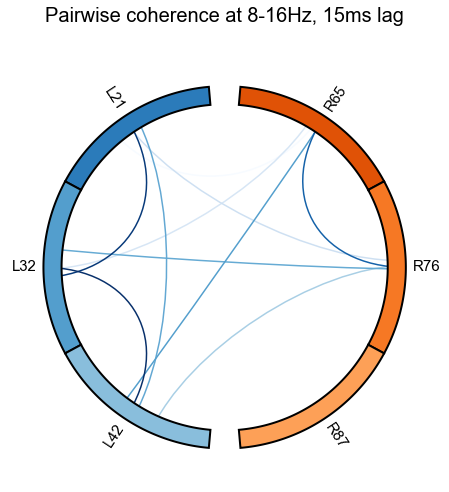

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x24f0aa97e08>)

In [237]:
angles = circular_layout(electrodes, ['L21', 'L32', 'L42', 'R87', 'R76', 'R65'],
                         start_pos=90, start_between=True,
                         group_boundaries=[0, 3], group_sep=10
                        )

plot_connectivity_circle(coherences, electrodes,
                         n_lines=10,
                         title="Pairwise coherence at 8-16Hz, 15ms lag",
                         facecolor="white", textcolor="black", colormap="Blues",
                         node_colors=colors,
                         node_angles=angles,
                         colorbar=False,
                         colorbar_size=0.75, colorbar_pos=(0,0.6), 
                         fontsize_names=15, fontsize_colorbar=15, fontsize_title=20,
                         node_linewidth=2,
                         padding=2
                        )

We can see here the pairwise coherence between all individual electrodes at 8-16Hz at a lag of 15ms. We are only visualising the ten strongest connections. We can see strongly coordinated activity between electrodes within the left ACC, with evidence of coherence between parts of the right ACC and the left ACC. Notably, this is not a uniform effect throughout the right ACC - we can see that the areas recorded by R87 are not as strongly coherent, even within this window where we have demonstrated communication between the two sides. This further supports the idea that feedback-related activity is distributed throughout an ACC network, with some areas responding differently and communicating with differing areas.

Again, these results suggest a flow of information from left ACC centres to right ACC centres, consistent with a response of the left ACC to outcomes and a response of right ACC to an outcome-related signal from the left ACC. In order to investigate whether this apparent information flow is due to communication between specific activity centres in left and right ACC we will investigate whether there is evidence of communication in source space using sources with activities related to feedback identified earlier.

Step at 20.01953125: F = 2.5472610569343734, p = 3.322130108711088e-07


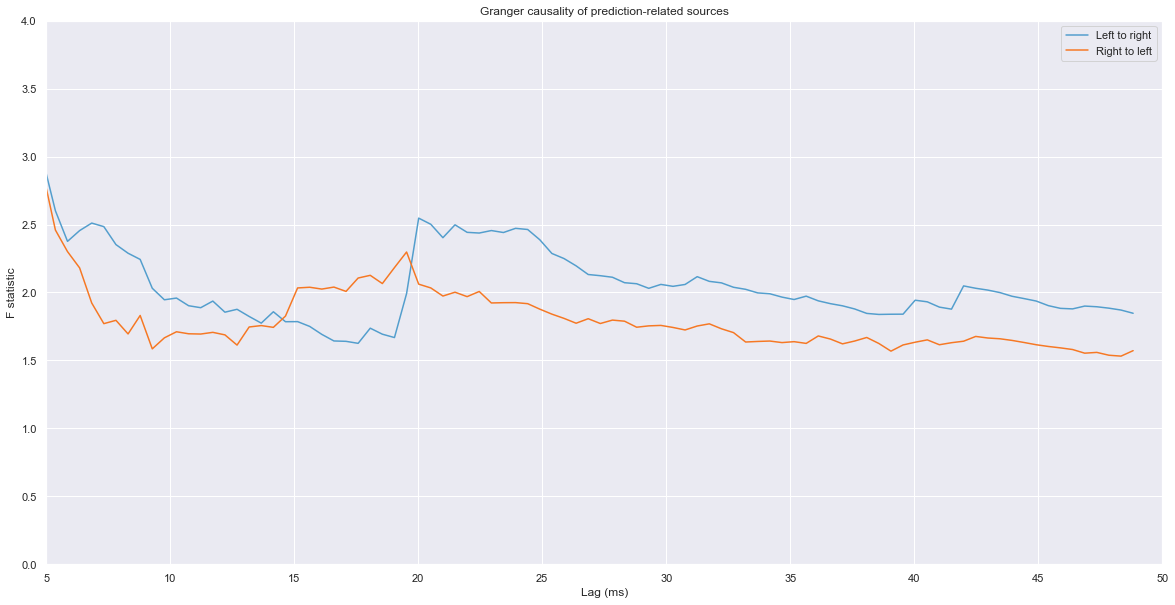

In [234]:
# GC in source space: early prediction on L and late prediction on R
# Plot F-statistic for GC in both directions
dataLtoR = np.array([np.diff(signalsRight_.T[1]), np.diff(signalsLeft_.T[2])]).T
dataRtoL = np.array([np.diff(signalsLeft_.T[2]), np.diff(signalsRight_.T[1])]).T

gc_resLtoR = grangercausalitytests(dataLtoR,100,verbose=False)
gc_resRtoL = grangercausalitytests(dataRtoL,100,verbose=False)

# Define intervals using t-tests -> test over these intervals over lags
# Choose test statistic & plot this
# Can then take max significance as area of max communication
# Also: demonstrate directionality by reversing
# Can then use these lags & directions for transfer entropy test

# At -150 to 0, early R -> L; L-> R less so, at later lags: bidirectional feedback, differing temporal dynamics
# 150 to 450: L -> R v early; no R -> L

# Can look at whether there is difference in communication C v I (i.e. L v R under conditions of C, I)
# Using intervals & directions already determined, look at whether test statistic plots differ for pre & post (i.e. is causality different with C v I)

FvalsLtoR = [gc_resLtoR[lag][0]['ssr_ftest'][0] for lag in range(1,101)]
FvalsRtoL = [gc_resRtoL[lag][0]['ssr_ftest'][0] for lag in range(1,101)]

timepoints = [t * 1000/2048 for t in range(1,101)]

fig,ax = plt.subplots(figsize=(20,10))

ax.plot(timepoints,FvalsLtoR, color=colours_left[1], label="Left to right")
ax.plot(timepoints,FvalsRtoL, color=colours_right[1], label="Right to left")
ax.legend()
ax.set_ylabel('F statistic')
ax.set_xlabel('Lag (ms)')
ax.set_xlim([5, 50])
ax.set_ylim([0, 4])
ax.set_title('Granger causality of prediction-related sources')

print("Step at {0}ms: F = {1}, p = {2}".format(timepoints[np.argmax(FvalsLtoR[12:])+12], np.max(FvalsLtoR[12:]), gc_resLtoR[42][0]['ssr_ftest'][1])) # Add 1 to index of gc_res as lags 1 - 100 (not 0 indexed)

Here we can see the Granger causality between the first-difference of independent sources related to outcome response in the source-decomposed signals over a range of lags. Here, we are able to identify that sources in the left and right ACC communicate with each other in the post-feedback response period (100 to 500ms post-feedback).

The early high F-values are, as before, likely indicative of the ongoing bidirectional communication between areas and the overall event-related signal. Notably, we see a step change in the test statistic for left-to-right communication at a lag of 20ms (F = 2.55). This is statistically significant at a threshold of $p < 0.0001$, Bonferonni corrected for the number of lags tested (i.e. $p < 0.0001 \div 100$).

This is consistent with our previous results demonstrating a 20ms lag between feedback response windows between sides and a relationship between the signal in the left ACC and the signal in the right ACC 15ms later. This shows that there are distinct activity-related sources within the left and right ACC, and that the left ACC centres communicate with those on the right with a delay of 20ms. This is consistent with our hypothesis of a feedback response network, with the left ACC responding immediately to outcome, followed by a signal from left ACC centres to areas of the right ACC, which subsequently respond.

These results further outline the temporal and spatial dynamics of communication within the ACC network. However, it is interesting to note that although there is evidence of left to right communication in the interval we had expected, this effect is not as strong as the effect seen at the point where the late anticipation window is triggered. This may simply be a weaker effect, but it also may be due to variable communication between left ACC centres and right ACC centres depending on the nature of the outcome, leading to variable patterns of communication. This would be consistent with our hypothesis of a spatially distributed network within the ACC that communicates feedback-related information.

### Event outcome modulates ACC network activity
We have demonstrated the the ACC anticipates and responds to events, that these activities are carried out by a spatially distributed network of activity sources, and that these activity sources communicate with each other in a directional manner during key intervals. If our hypothesis regarding the role of this network in predicting and responding to event outcomes is correct, we expect to see a difference in network activity based on the nature of the outcome (correct vs. incorrect). We will investigate this by dividing the data into correct and incorrect trials.

Given the network we have identified and our hypothesis regarding its role, we expect to see differences in the outcome response between correct and incorrect trials. Further, we expect these responses to also differ between left ACC and right AC, due to the differences in signalling throughout the network. Lastly, we expect to see differences in patterns of communication in the post-feedback window (100ms to 500ms), corresponding to to differences in the information transmitted throughout the network relating to outcome.

These results would be consistent with a spatially distributed prediction network within the ACC that maintained an internal prediction model to aid decision making. When feedback is anticipated, the network "primes" itself to respond; on receiving feedback on an outcome, this is then relayed to the network to "update" the model in order to prepare for the next event.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
(Correct) Interval: -532.71484375ms to -532.2265625ms
(Correct) Interval: -529.78515625ms to -529.78515625ms
(Correct) Interval: -520.99609375ms to -520.99609375ms
(Correct) Interval: -520.01953125ms to -489.74609375ms
(Correct) Interval: -488.28125ms to -488.28125ms
(Correct) Interval: -486.81640625ms to -480.46875ms
(Correct) Interval: -479.00390625ms to -478.515625ms
(Correct) Interval: -476.5625ms to -476.07421875ms
(Correct) Interval: -474.12109375ms to -474.12109375ms
(Correct) Interval: -465.33203125ms to -465.33203125ms
(Correct) Interval: -463.37890625ms to -463.37890625ms
(Correct) Interval: -462.40234375ms to -462.40234375ms
(Correct) Interval: -461.42578125ms to -461.42578125ms
(Correct) Interval: -458.49609375ms to -457.03125ms
(Correct) Interval: -454.1015625ms to -449.70703125ms
(Correct) Interval: -447.75390625ms to -447.75390625ms
(Correct) Interval: -446.77734375ms to -359.375ms
(Correct) Interval: -357

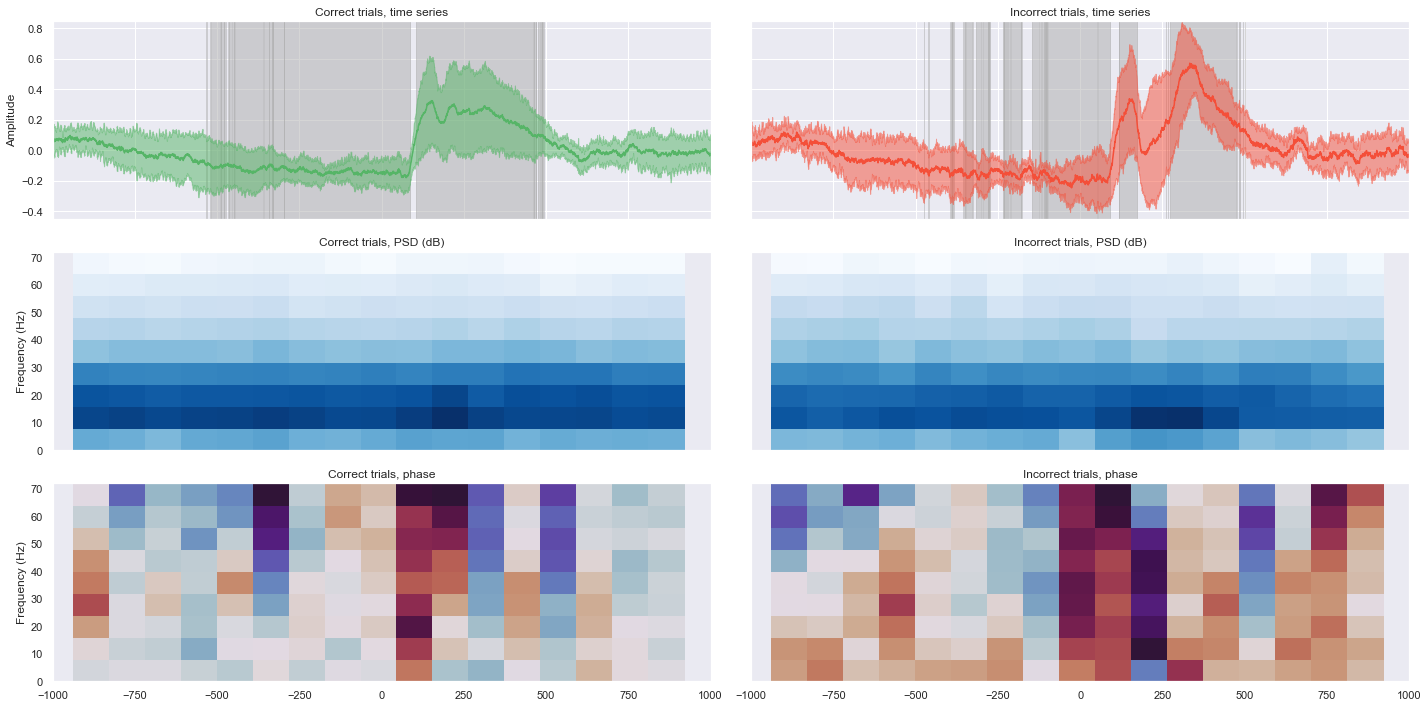

In [270]:
# Get correct & incorrect, overall: plot each separately with PSD & phase
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)

##### Get average time series #####

# Average across trials
correctChannels_averaged = correctChannels.groupby('Time').mean() # Mean of each electrode on left across trials
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Average across channels
correctChannels_mean = correctChannels_averaged.mean(axis=1)
correctChannels_SD = correctChannels_averaged.std(axis=1)

incorrectChannels_mean = incorrectChannels_averaged.mean(axis=1)
incorrectChannels_SD = incorrectChannels_averaged.std(axis=1)

##### Test to see where waveform is statistically significant #####
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Time', 'Trial'])
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Time', 'Trial'])

# Get average of all electrodes, indexed by trial and time
correctChannels_averaged = correctChannels.mean(axis=1)
incorrectChannels_averaged = incorrectChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttestsCorrect = [stats.ttest_1samp(correctChannels_averaged[t], 0) for t in df.Time.unique()]
pvalsCorrect = [test.pvalue for test in ttestsCorrect]

ttestsIncorrect = [stats.ttest_1samp(incorrectChannels_averaged[t], 0) for t in df.Time.unique()]
pvalsIncorrect = [test.pvalue for test in ttestsIncorrect]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startindsCorrect = [] # List of starts of intervals
endindsCorrect = [] # List of ends of intervals
for index, value in enumerate(pvalsCorrect):
    if pvalsCorrect[index] < threshold and pvalsCorrect[index-1] > threshold:
        startindsCorrect.append(index)
        
    if pvalsCorrect[index] < threshold and pvalsCorrect[index+1] > threshold:
        endindsCorrect.append(index)
        
intervalsCorrect = zip(startindsCorrect, endindsCorrect)

startindsIncorrect = [] # List of starts of intervals
endindsIncorrect = [] # List of ends of interval
for index, value in enumerate(pvalsIncorrect):
    if pvalsIncorrect[index] < threshold and pvalsIncorrect[index-1] > threshold:
        startindsIncorrect.append(index)
        
    if pvalsIncorrect[index] < threshold and pvalsIncorrect[index+1] > threshold:
        endindsIncorrect.append(index)
        
intervalsIncorrect = zip(startindsIncorrect, endindsIncorrect)

##### Get PSD & phase #####

# Get channel data from df
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesLeft, index = ['Trial', 'Time'])
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesLeft, index = ['Trial', 'Time'])

# Average across electrodes, indexed by trial & time
correctChannels_averaged = correctChannels.mean(axis=1)
incorrectChannels_averaged = incorrectChannels.mean(axis=1)

# Get spectrogram for each trial & average these
# Note getting average spectrogram rather than spectrogram of average - latter results in loss of information
correctPSDs = [] # Empty list for storing PSDs
correctPhases = [] # Empty list for storing phases
for trial in df[df['Outcome']=='Correct'].Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, correctSxx = signal.spectrogram(correctChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, correctphaseTrial = signal.spectrogram(correctChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial

    # Add PSD & phase to list
    correctPSDs.append(correctSxx)
    correctPhases.append(correctphaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials
    
# Get average psd & phase
correctpsd = np.mean(correctPSDs, axis=0)
correctphase = np.mean(correctPhases, axis=0)

incorrectPSDs = [] # Empty list for storing PSDs
incorrectPhases = [] # Empty list for storing phases
for trial in df[df['Outcome']=='Incorrect'].Trial.unique(): # Cycle through each trial
    # Get PSD & phase for trial
    freqs, times, incorrectSxx = signal.spectrogram(incorrectChannels_averaged[trial], fs=2048, mode = 'psd', scaling='spectrum', window='hanning', nperseg=256) # Get PSD for current trial
    freqs, times, incorrectphaseTrial = signal.spectrogram(incorrectChannels_averaged[trial], fs=2048, mode='phase', scaling='spectrum', window='hanning', nperseg=256) # Get phases for current trial

    # Add PSD & phase to list
    incorrectPSDs.append(incorrectSxx)
    incorrectPhases.append(incorrectphaseTrial)
    # Note that we don't need to save freqs or time as these are the same for all trials
    
# Get average psd & phase
incorrectpsd = np.mean(incorrectPSDs, axis=0)
incorrectphase = np.mean(incorrectPhases, axis=0)

# Convert to times centres on feedback
times = (times - 1) * 1000


##### Create plot: time series / PSD / phase
fig, ax = plt.subplots(3,2, sharex='col', sharey='row');

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervalsCorrect:
    ax[0,0].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Correct) Interval: {0}ms to {1}ms".format(t[start], t[end]))
for start, end in intervalsIncorrect:
    ax[0,1].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Incorrect) Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
    
# Plot time series
correctChannels_mean.plot(ax=ax[0,0], color=colours_correct[1])
ax[0,0].fill_between(correctChannels_mean.index, correctChannels_mean+correctChannels_SD, correctChannels_mean-correctChannels_SD, alpha=0.5, color=colours_correct[1])
ax[0,0].set_title('Correct trials, time series')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_ylim([-0.45, 0.85])

incorrectChannels_mean.plot(ax=ax[0,1], color=colours_incorrect[1])
ax[0,1].fill_between(incorrectChannels_mean.index, incorrectChannels_mean+incorrectChannels_SD, incorrectChannels_mean-incorrectChannels_SD, alpha=0.5, color=colours_incorrect[1])
ax[0,1].set_title('Incorrect trials, time series')

# Plot PSD
ax[1,0].pcolormesh(times, freqs[:10], 10*np.log(correctpsd[:10]), cmap = colours_spectrum)
ax[1,0].set_title('Correct trials, PSD (dB)')
ax[1,0].set_ylabel('Frequency (Hz)')

ax[1,1].pcolormesh(times, freqs[:10], 10*np.log(incorrectpsd[:10]), cmap = colours_spectrum)
ax[1,1].set_title('Incorrect trials, PSD (dB)')

# Plot phase
ax[2,0].pcolormesh(times, freqs[:10], correctphase[:10], cmap = colours_phase)
ax[2,0].set_title('Correct trials, phase')
ax[2,0].set_ylabel('Frequency (Hz)')

ax[2,1].pcolormesh(times, freqs[:10], incorrectphase[:10], cmap = colours_phase)
ax[2,1].set_title('Incorrect trials, phase')

fig.tight_layout()

The plot shows the overall ACC response to correct and to incorrect trials over all electrodes. Highlighted areas show the intervals where the ACC response is statistically significant at a threshold of $p < 0.0001$, Bonferroni corrected for the number of points tests (i.e. $p < 0.0001 \div 4097$).We can see, as would be expected, that the pre-feedback intervals are broadly similar; we would not expect that the anticipatory signal differs based on outcome, as there is no way outcome could influence the activity preceding feedback; there may be a signal related to the level of certainty in the prediction made, but the current analysis does not allow us to differentiate trials based on confidence in prediction.

Looking at the post-feedback response, we can see that both conditions produce an early response (at 105ms and 117ms in correct and incorrect trials respectively). This corresponds to the beginning of the feedback response we saw in the overall signal. Interestingly, in correct trials this interval continues through to 493ms, encompassing the full feedback response seen already, while this is not the case for incorrect trials. Here we see an early response lasting from 117ms to 173ms, followed by a second interval characterised by a large, delayed second peak, lasting from 270ms to 501ms. This strongly suggests that the ACC network responds differently based on the valence of the outcome. Further, it suggests that the feedback response may be composed of a separate early response beginning at 100 - 110ms that is common to all responses (i.e. an undifferentiated "event" indicator) and a later interval following this that differs based on outcome valence, lasting through to 500ms. This suggests that outcome valence is encoded by the ACC network later, with a response from about 270ms. This is consistent with the results of the linear discriminant analysis in Weiss et al. 2018.

The PSD and phase plots show us similar information: we see a more sustainted amplitude response at 10-20Hz in the response interval during incorrect trials, in keeping with the prolonged, high-amplitude response seen in the time domain. In the frequency domain, both show cross-frequency phase coherence in the immediate post-feedback period, while this phase response is maintained longer in incorrect trials, again in keeping with the prolonged valence signal seen in these trials.

These results suggest that the ACC network differentially signals outcome valence in the post-250ms interval. Particularly, we see a delayed, high-amplitude second peak in incorrect trials, suggestive of a strong response here. This ties in with our hypothesis regarding valence signalling to a network centre that maintains a prediction model that is updated based on valence: following an incorrect trial, the prediction network needs to be updated to improve the accuracy of future predictions, so we see a stronger response in this case than in correct trials, where the prediction model is performing appropriately.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: 184.5703125ms to 185.05859375ms
Interval: 187.01171875ms to 188.4765625ms
Interval: 189.453125ms to 189.453125ms
Interval: 190.4296875ms to 229.00390625ms
Interval: 302.24609375ms to 303.7109375ms
Interval: 304.6875ms to 374.51171875ms
Interval: 386.23046875ms to 386.23046875ms


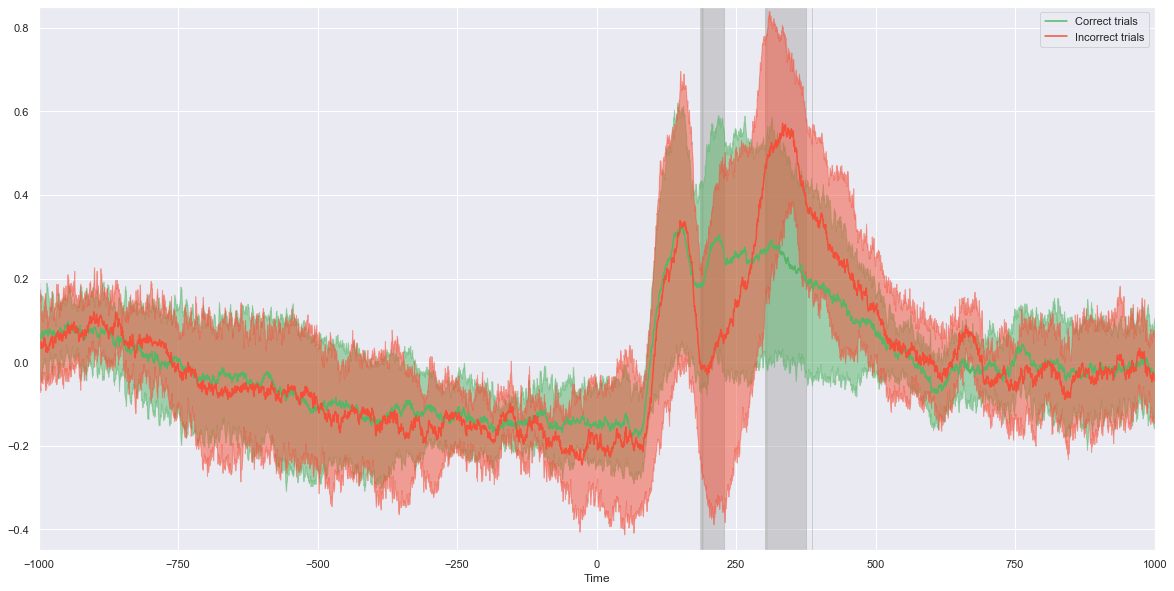

In [279]:
# Compare correct & incorrect
# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Time', 'Trial'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Time', 'Trial'], aggfunc = np.mean)

# Get average of all electrodes, indexed by trial and time
correctChannels_averaged = correctChannels.mean(axis=1)
incorrectChannels_averaged = incorrectChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttests = [stats.ttest_ind(correctChannels_averaged[t], incorrectChannels_averaged[t], 0) for t in df.Time.unique()]
pvals = [test.pvalue for test in ttests]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if pvals[index] < threshold and pvals[index-1] > threshold:
        startinds.append(index)
        
    if pvals[index] < threshold and pvals[index+1] > threshold:
        endinds.append(index)
        
intervals = zip(startinds, endinds)

# Create separate dataframes for correct & incorrect
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
correctChannels_averaged = correctChannels.groupby('Time').mean() # Mean of each electrode on left across trials
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
correctChannels_mean = correctChannels_averaged.mean(axis=1)
correctChannels_SD = correctChannels_averaged.std(axis=1)

incorrectChannels_mean = incorrectChannels_averaged.mean(axis=1)
incorrectChannels_SD = incorrectChannels_averaged.std(axis=1)

# Plot C v I
fig, ax = plt.subplots()

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax.fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
correctChannels_mean.plot(ax=ax, label='Correct trials', color=colours_correct[1])
incorrectChannels_mean.plot(ax=ax, label='Incorrect trials', color=colours_incorrect[1])
ax.fill_between(correctChannels_mean.index, correctChannels_mean + correctChannels_SD, correctChannels_mean - correctChannels_SD, alpha=0.5, color=colours_correct[1])
ax.fill_between(incorrectChannels_mean.index, incorrectChannels_mean + incorrectChannels_SD, incorrectChannels_mean - incorrectChannels_SD, alpha=0.5, color=colours_incorrect[1])

ax.set_ylim([-0.45, 0.85])
ax.legend()

This plot shows the overall responses for correct and incorrect trials superimposed on the same plot. Highlighted areas demonstrate the intervals where the response to correct and incorrect trials differ with a significance threshold of $p < 0.0001$ Bonferonni corrected for the number of points tested (i.e. $p < 0.0001 \div 4097$).

As expected, we see here that there is no difference in the pre-feedback interval. By looking at this period under different conditions of uncertainty, it may be possible to investigate whether there is a signal for how confident the ACC network is in its prediction; with the current analysis, we would not expect outcome valence to retroactively have an effect on signalling before feedback was received.

Looking at the post-feedback period, there are intervals where the ACC response differs based on valence at 184ms to 229ms and at 302 to 386ms. Notably, the early response at 100ms to 180ms is nearly identical regardless of outcome with overlapping peaks, supporting our suggestion that the response in this period represents an "event" signal, agnostic to outcome valence. The period from 184ms to 229ms is marked by an early, small second peak during correct trials and a significant drop in incorrect trials; our hypothesis of a predictive network would suggest that this interval represents the first "valence" signal, where agreement between the predicted response and the actual response is checked; we see a small response during correct trials, as a large adjustment is not necessary, while there is a more marked response in incorrect trials, corresponding to the greater deviation between predicted and actual responses. 

Following this, the signal in correct trials is briefly maintained then drops off, while in incorrect trials we see a significant second peak during the 302 to 386ms interval. Our hypothesis suggests that this relates to a second valence-related signal, where the error between the predicted and actual outcomes is signalled to indicate that the network's model needs to be updated. Notably, these first and second "valence-related" signals correspond almost exactly to the peaks seen in Weiss et al. 2018's discriminant analysis.

In this way, we see that the feedback response appears to be composed of three distinct signals here: an immediate "event" signal at 100ms to 180ms which signals that an event has occurred, a "valence" signal at 180ms to 230ms where agreement with the network's prediction is checked, and an "error" signal at 300ms to 380ms which indicates a need to update the model.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


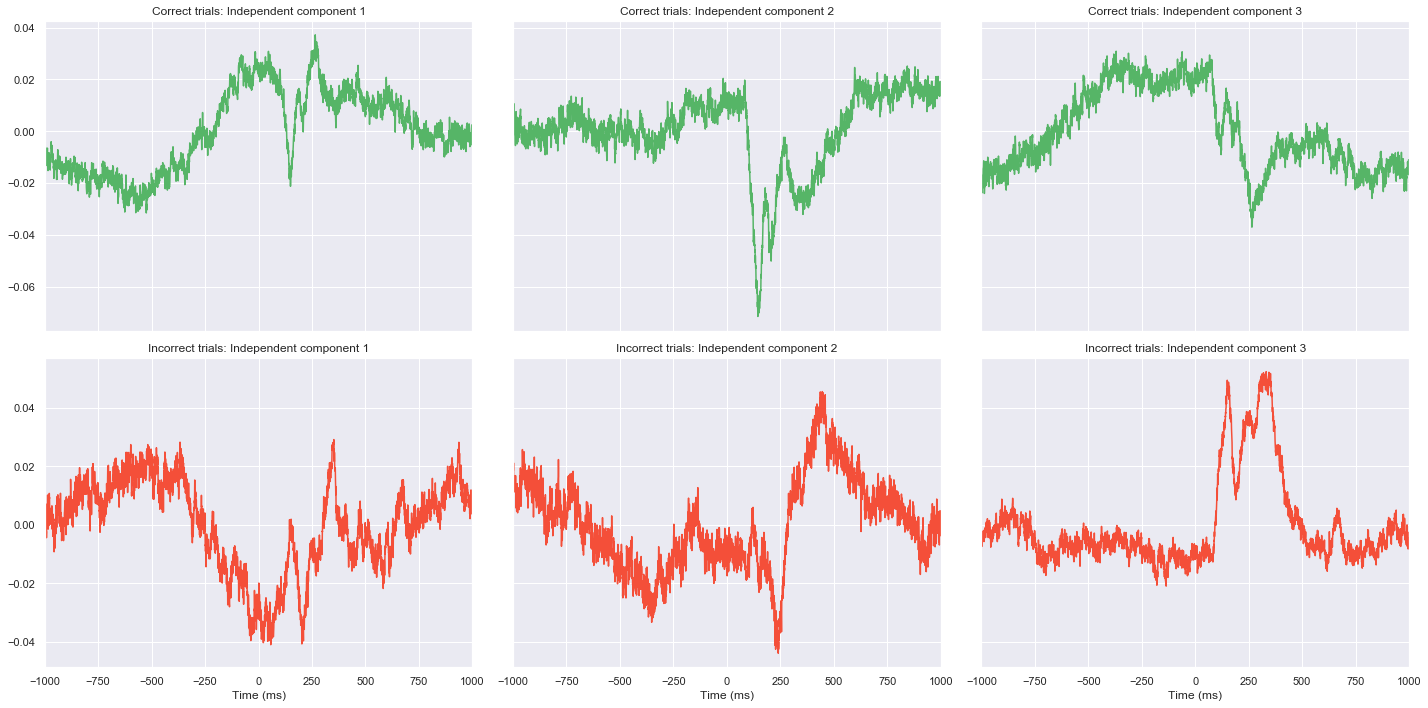

In [286]:
# Compare ICs, C v I
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Trial', 'Time'], aggfunc=np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Trial', 'Time'], aggfunc=np.mean)

correctChannels_averaged = correctChannels.groupby('Time').mean()
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean()

# 4097 x 6 array of average responses at each channel over time
signalsCorrect = np.array([correctChannels.groupby('Time').mean()[elec] for elec in electrodes]).T
signalsIncorrect = np.array([incorrectChannels.groupby('Time').mean()[elec] for elec in electrodes]).T

# Compute ICA
ica = FastICA(n_components = 3)
signalsCorrect_ = ica.fit_transform(signalsCorrect)
signalsIncorrect_ = ica.fit_transform(signalsIncorrect)

# Plot ICs
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(20,10))

for i, (icC, icI) in enumerate(zip(signalsCorrect_.T, signalsIncorrect_.T)):
    ax[0,i].plot(t, icC, color=colours_correct[1])
    ax[0,i].set_title('Correct trials: Independent component {}'.format(i+1))
    
    ax[1,i].plot(t, icI, color=colours_incorrect[1])
    ax[1,i].set_title('Incorrect trials: Independent component {}'.format(i+1))
    ax[1,i].set_xlabel('Time (ms)')
    ax[1,i].set_xlim([-1000,1000])
    
fig.tight_layout()

Decomposition of the overall signals for correct and incorrect trials into independent sources is shown above. This allows us to investigate how sources within the network we have identified respond to outcome valence. We can see here that following a correct trial, independent component 2 shows a sharp early spike, as does the beginning of component 1 for incorrect trials. This likely represents the common "event" signal. During correct trials, we then see small-amplitude spikes at roughly 250ms, likely corresponding to a small "valence" signal, followed by a return to baseline.

During incorrect trials, in addition to the "event" signal, we see spikes occuring at 200ms to 250ms, likely representing the "valence" signal again. We then see larger-amplitude second peaks at 300ms to 500ms in multiple sources. This likely represents the "error" signal we had identified, with significant activity from multiple sources responding to a mismatch between predicted and actual outcomes to signal a need to adjust the network's predictions.

These results demonstrate that the ACC responds differently based on outcome valence, and appears to indicate a complex three-component response to feedback within the network. We have previously shown that the ACC network is made up of spatially distributed centres of activity that carry out different roles, communicating with each other at key intervals. Given our hypothesis of functionally distinct regions communicating with each other, we would expect to see differences between regions in their response to outcome valence.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
(Side) Interval: -560.05859375ms to -560.05859375ms
(Side) Interval: -559.08203125ms to -559.08203125ms
(Side) Interval: -557.12890625ms to -553.22265625ms
(Side) Interval: -549.8046875ms to -549.8046875ms
(Side) Interval: -547.8515625ms to -547.8515625ms
(Side) Interval: -545.8984375ms to -544.43359375ms
(Side) Interval: -540.52734375ms to -539.55078125ms
(Side) Interval: -538.57421875ms to -534.1796875ms
(Side) Interval: -532.2265625ms to -532.2265625ms
(Side) Interval: -528.80859375ms to -528.80859375ms
(Side) Interval: -527.34375ms to -513.18359375ms
(Side) Interval: -512.20703125ms to -511.71875ms
(Side) Interval: -486.328125ms to -486.328125ms
(Side) Interval: -485.3515625ms to -484.375ms
(Side) Interval: -480.46875ms to -475.5859375ms
(Side) Interval: -474.609375ms to -474.609375ms
(Side) Interval: -473.6328125ms to -473.14453125ms
(Side) Interval: -468.26171875ms to -455.078125ms
(Side) Interval: -445.80078125ms 

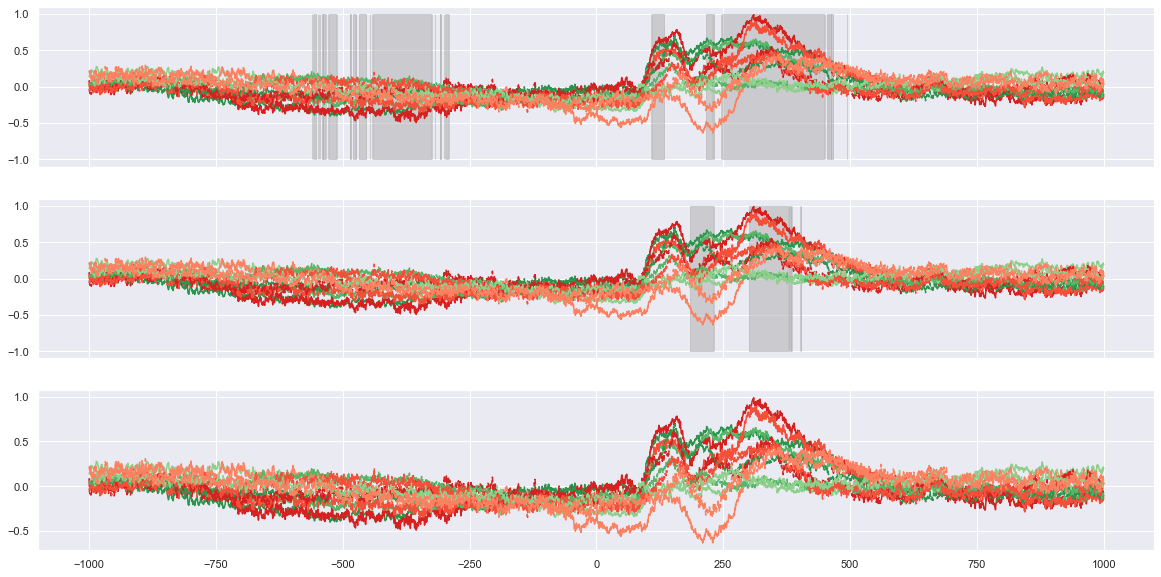

In [377]:
# ANOVA: split into C-L, C-R, I-L, I-R
    # Plot all 4; highlight with main effect side, main effect outcome, interaction
    # ?combine with pairwise plot - post hoc tests (+ ? ICs for all 4: 12 plots!)

# ? use RM vs independent t test - try RM initially

correctChannelsLeft = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)
correctChannelsRight = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)

incorrectChannelsLeft = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)
incorrectChannelsRight = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)

# Get average signal across electrodes
CL_ = correctChannelsLeft.mean(axis=1)
CR_ = correctChannelsRight.mean(axis=1)
IL_ = incorrectChannelsLeft.mean(axis=1)
IR_ = incorrectChannelsRight.mean(axis=1)

# Test each timepoint using ANOVA with side & outcome as factors
# There is definitely a better way of setting up the data frame than this, but it works
p_side = []
p_outcome = []
p_interaction = []
for t in df.Time.unique():
    CL = pd.DataFrame(CL_[t]) # Get vals at time point
    CL['Side'] = 'Left'
    CL['Outcome'] = 'Correct'
    CL.melt(id_vars=['Side','Outcome'])
    CL.columns=['Data', 'Side', 'Outcome']

    CR = pd.DataFrame(CR_[t]) # Get vals at time point
    CR['Side'] = 'Right'
    CR['Outcome'] = 'Correct'
    CR.melt(id_vars=['Side','Outcome'])
    CR.columns=['Data', 'Side', 'Outcome']

    IL = pd.DataFrame(IL_[t]) # Get vals at time point
    IL['Side'] = 'Left'
    IL['Outcome'] = 'Incorrect'
    IL.melt(id_vars=['Side','Outcome'])
    IL.columns=['Data', 'Side', 'Outcome']

    IR = pd.DataFrame(IR_[t]) # Get vals at time point
    IR['Side'] = 'Right'
    IR['Outcome'] = 'Incorrect'
    IR.melt(id_vars=['Side','Outcome'])
    IR.columns=['Data', 'Side', 'Outcome']
    
    dataprepped = pd.concat([CL, CR, IL, IR])
    
    aov = pg.anova(data=dataprepped, dv='Data', between=['Side', 'Outcome'])
    p_side.append(aov['p-unc'][0])
    p_outcome.append(aov['p-unc'][1])
    p_interaction.append(aov['p-unc'][2])
    
# Find intervals for side, outcome and interaction
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startindsSide = [] # List of starts of intervals
endindsSide = [] # List of ends of intervals
for index, value in enumerate(p_side):
    if index < len(p_side)-1: # Avoids error if last pval < 0.05
        if p_side[index] < threshold and p_side[index-1] > threshold:
            startindsSide.append(index)

        if p_side[index] < threshold and p_side[index+1] > threshold:
            endindsSide.append(index)
            
if p_side[-1] < threshold: # Add last index to end of intervals if last value significant
    endindsSide.append(len(p_side)-1)
    
intervalsSide = zip(startindsSide, endindsSide)

startindsOutcome = [] # List of starts of intervals
endindsOutcome = [] # List of ends of intervals
for index, value in enumerate(p_outcome):
    if index < len(p_outcome)-1: # Avoids error if last pval < 0.05
        if p_outcome[index] < threshold and p_outcome[index-1] > threshold:
            startindsOutcome.append(index)

        if p_outcome[index] < threshold and p_outcome[index+1] > threshold:
            endindsOutcome.append(index)
            
if p_outcome[-1] < threshold: # Add last index to end of intervals if last value significant
    endindsOutcome.append(len(p_outcome)-1)
    
intervalsOutcome = zip(startindsOutcome, endindsOutcome)

startindsInteraction = [] # List of starts of intervals
endindsInteraction = [] # List of ends of intervals
for index, value in enumerate(p_interaction):
    if index < len(p_interaction)-1: # Avoids error if last pval < 0.05
        if p_interaction[index] < threshold and p_interaction[index-1] > threshold:
            startindsInteraction.append(index)

        if p_interaction[index] < threshold and p_interaction[index+1] > threshold:
            endindsInteraction.append(index)
            
if p_interaction[-1] < threshold: # Add last index to end of intervals if last value significant
    endindsInteraction.append(len(p_interaction)-1)
    
intervalsInteraction = zip(startindsInteraction, endindsInteraction)

# Create plot
fig, ax = plt.subplots(nrows=3, ncols=1, sharex='col', figsize=(20,10));

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervalsSide:
    ax[0].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Side) Interval: {0}ms to {1}ms".format(t[start], t[end]))
for start, end in intervalsOutcome:
    ax[1].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Outcome) Interval: {0}ms to {1}ms".format(t[start], t[end]))
for start, end in intervalsInteraction:
    ax[2].fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("(Interaction) Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodes, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
correctChannels_averaged = correctChannels.groupby('Time').mean() # Mean of each electrode on left across trials
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean() # Mean of each electrode on right across trials

for i, left in enumerate(electrodesLeft):
    for j in range(3):
        ax[j].plot(t, correctChannels_averaged[left], label=left, color=colours_correct[i])
        ax[j].plot(t, incorrectChannels_averaged[left], label=left, color=colours_incorrect[i])
for i, right in enumerate(electrodesRight):
    for j in range(3):
        ax[j].plot(t, correctChannels_averaged[right], label=right, color=colours_correct[i], linestyle='--')
        ax[j].plot(t, incorrectChannels_averaged[right], label=right, color=colours_incorrect[i], linestyle='--')


Here we see the average signal at each electrode for correct (green) and incorrect (red) trials. Highlighted areas differ to a statistically significant degree at a threshold of $p < 0.0001 \div 4097$, based on analysis of variance with side and outcome as factors.

The top plot shows the areas where there is a main effect of side. As demonstrated previously, there are differences in the early predictive window, the the time-to-peak following feedback, and in the double-peak response to feedback.

The middle plot shows the main effect of outcome. As with previously, we see effects during the window corresponding to the valence signal and the later error signal.

The bottom plot shows the interaction between side and outcome. There are no areas where this accounts for the variance. This indicates that the variance within recordings is accounted for by the effects of left vs. right and correct vs. incorrect.

To more thoroughly investigate whether any differences exist in the response to outcomes between the left and right ACC, we will examine the differences in valence response within each side.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: 184.08203125ms to 233.88671875ms
Interval: 234.86328125ms to 235.83984375ms
Interval: 237.3046875ms to 241.2109375ms
Interval: 244.140625ms to 245.1171875ms
Interval: 247.0703125ms to 247.0703125ms
Interval: 255.859375ms to 255.859375ms
Interval: 306.640625ms to 307.12890625ms
Interval: 312.98828125ms to 313.4765625ms
Interval: 314.94140625ms to 315.91796875ms
Interval: 317.3828125ms to 317.87109375ms
Interval: 319.3359375ms to 356.93359375ms
Interval: 358.3984375ms to 358.88671875ms


Text(0.5, 1.0, 'Left ACC, correct vs. incorrect trials')

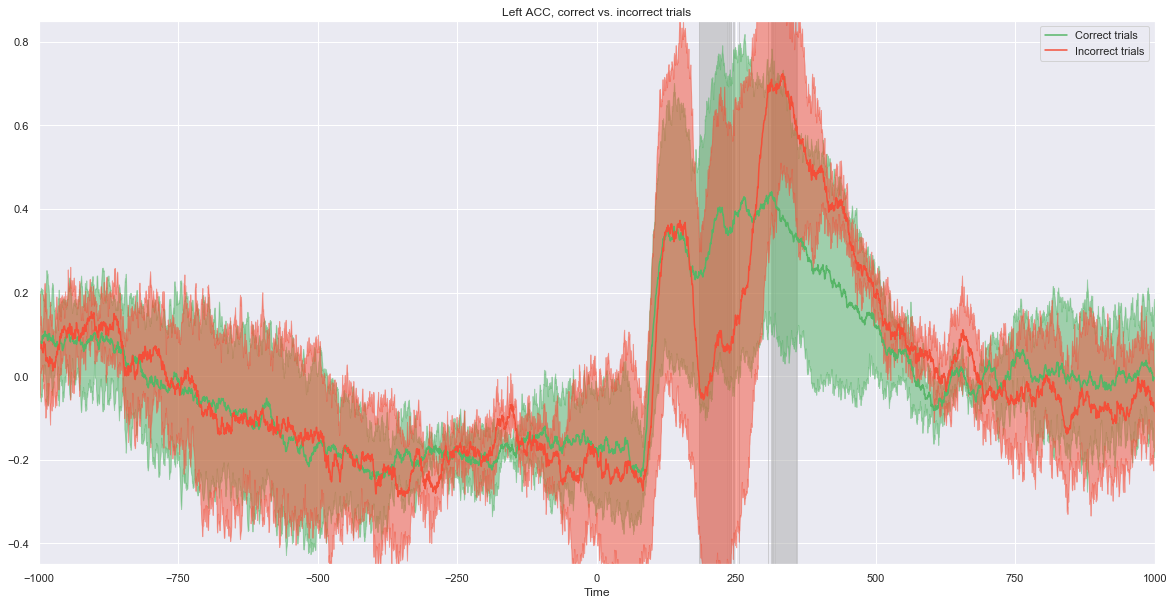

In [386]:
# L: C v I
# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesLeft, index = ['Time', 'Trial'], aggfunc = np.mean)

# Get average of all electrodes, indexed by trial and time
correctChannels_averaged = correctChannels.mean(axis=1)
incorrectChannels_averaged = incorrectChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttests = [stats.ttest_ind(correctChannels_averaged[t], incorrectChannels_averaged[t], 0) for t in df.Time.unique()]
pvals = [test.pvalue for test in ttests]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if pvals[index] < threshold and pvals[index-1] > threshold:
        startinds.append(index)
        
    if pvals[index] < threshold and pvals[index+1] > threshold:
        endinds.append(index)
        
intervals = zip(startinds, endinds)

# Create separate dataframes for correct & incorrect
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesLeft, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
correctChannels_averaged = correctChannels.groupby('Time').mean() # Mean of each electrode on left across trials
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
correctChannels_mean = correctChannels_averaged.mean(axis=1)
correctChannels_SD = correctChannels_averaged.std(axis=1)

incorrectChannels_mean = incorrectChannels_averaged.mean(axis=1)
incorrectChannels_SD = incorrectChannels_averaged.std(axis=1)

# Plot C v I
fig, ax = plt.subplots()

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax.fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
correctChannels_mean.plot(ax=ax, label='Correct trials', color=colours_correct[1])
incorrectChannels_mean.plot(ax=ax, label='Incorrect trials', color=colours_incorrect[1])
ax.fill_between(correctChannels_mean.index, correctChannels_mean + correctChannels_SD, correctChannels_mean - correctChannels_SD, alpha=0.5, color=colours_correct[1])
ax.fill_between(incorrectChannels_mean.index, incorrectChannels_mean + incorrectChannels_SD, incorrectChannels_mean - incorrectChannels_SD, alpha=0.5, color=colours_incorrect[1])

ax.set_ylim([-0.45, 0.85])
ax.legend()
ax.set_title('Left ACC, correct vs. incorrect trials')

This plot shows the average signals for correct and incorrect trials within the left ACC superimposed. Highlighted areas show regions where the response is statistically significant with a threshold of $p < 0.0001 \div 4097$.

We can see that the intervals identified here are a 184ms to 255ms window corresponding to the valence response we identified earlier; this appears to signal whether the actual outcome differs from what was anticipated by the ACC. There is then a second window of significant difference from 306ms to 358ms. This corresponds to the error response we proposed earlier, where, on identifying an outcome that differs from what was anticipated, the left ACC signals to update the network's prediction model. Notably, there is no difference in the early response period, corresponding to an "event" response that does not discriminate outcome valence.

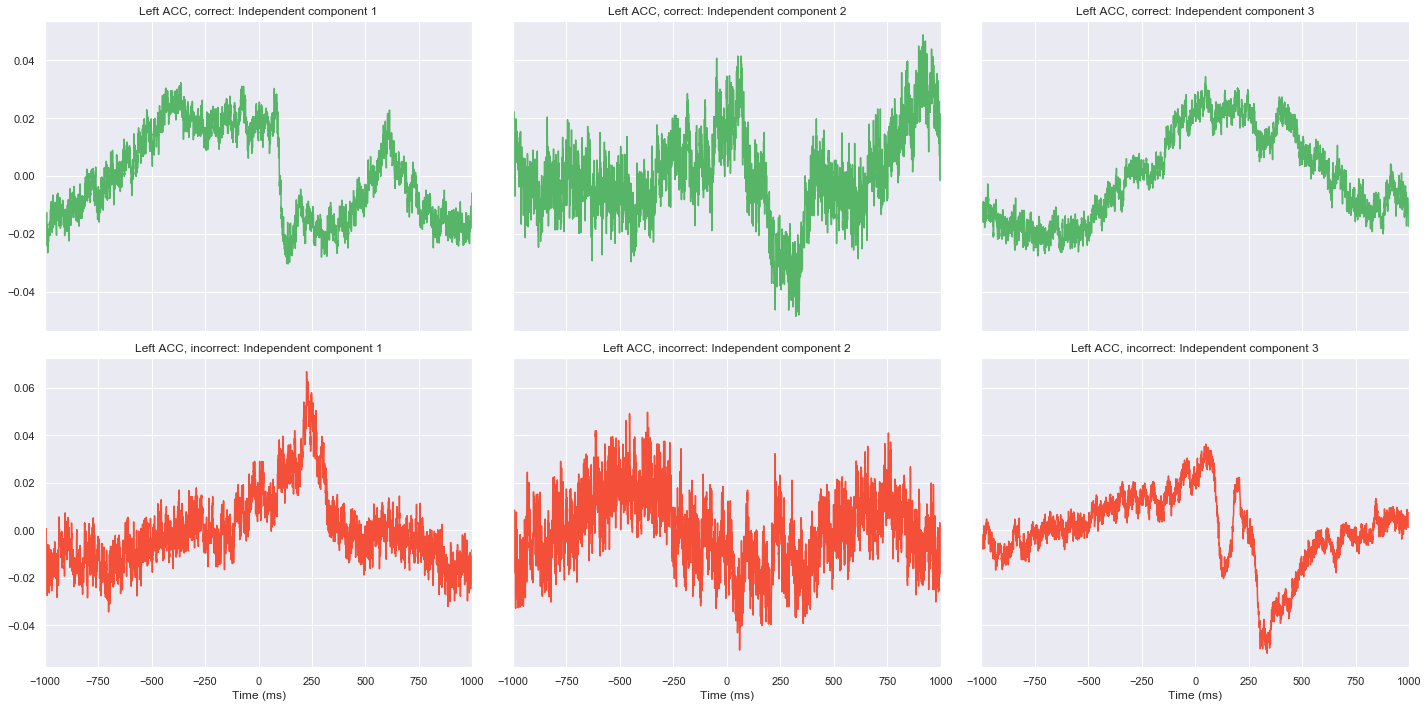

In [394]:
# L, C v I: ICs
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesLeft, index = ['Trial', 'Time'], aggfunc=np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesLeft, index = ['Trial', 'Time'], aggfunc=np.mean)

correctChannels_averaged = correctChannels.groupby('Time').mean()
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean()

# 4097 x 6 array of average responses at each channel over time
signalsCorrect = np.array([correctChannels.groupby('Time').mean()[elec] for elec in electrodesLeft]).T
signalsIncorrect = np.array([incorrectChannels.groupby('Time').mean()[elec] for elec in electrodesLeft]).T

# Compute ICA
ica = FastICA(n_components = 3)
signalsCorrect_L = ica.fit_transform(signalsCorrect)
signalsIncorrect_L = ica.fit_transform(signalsIncorrect)

# Plot ICs
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(20,10))

for i, (icC, icI) in enumerate(zip(signalsCorrect_L.T, signalsIncorrect_L.T)):
    ax[0,i].plot(t, icC, color=colours_correct[1])
    ax[0,i].set_title('Left ACC, correct: Independent component {}'.format(i+1))
    
    ax[1,i].plot(t, icI, color=colours_incorrect[1])
    ax[1,i].set_title('Left ACC, incorrect: Independent component {}'.format(i+1))
    ax[1,i].set_xlabel('Time (ms)')
    ax[1,i].set_xlim([-1000,1000])
    
fig.tight_layout()

Here we see the decomposition of the left ACC signal into its sources for correct and incorrect trials. This allows us to investigate whether there are differences in the activity of the left ACC network centres based on outcome valence.

We can see that following a correct trial, the left ACC centres seem to show sharp initial responses, likely corresponding to the valence signal, followed by a low-amplitude later peak in components 2 and 3, which seems to represent the activity that produces the small error-related activity seen. Following incorrect trials, there is a similar immediate response seem in components 2 and 3. However, we then see a much sharper and higher-amplitude second peak, corresponding to the more marked error-related activity in these centres following an incorrect trial.

These results demonstrate that the left ACC response differs based on outcome valence; this response is divided into an event-related response which does not differ, an early valence-related response and a late error signal that is particularly marked on incorrect trials, which likely indicates a need to update the behaviour of the prediction network. The spatially distributed activity sources identified earlier produce these activities by responding differently based on outcome valence, thereby encoding valence and error.

Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)
Interval: 201.66015625ms to 201.66015625ms
Interval: 203.125ms to 203.61328125ms
Interval: 205.078125ms to 205.56640625ms
Interval: 328.125ms to 328.125ms
Interval: 329.1015625ms to 329.1015625ms
Interval: 332.51953125ms to 334.47265625ms
Interval: 335.44921875ms to 362.79296875ms


Text(0.5, 1.0, 'Right ACC, correct vs. incorrect trials')

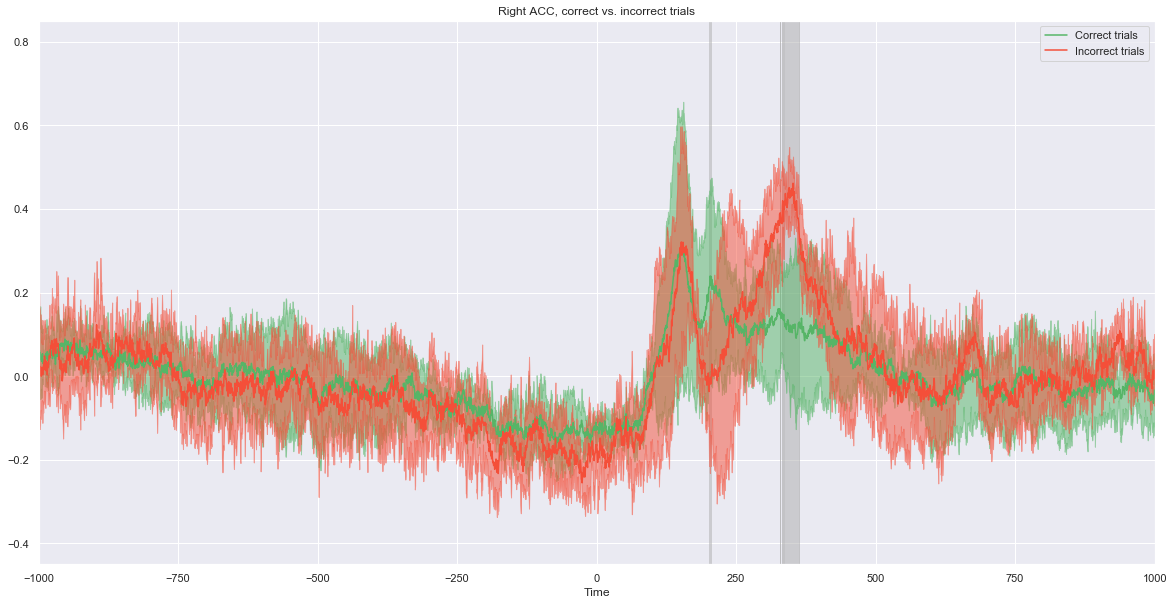

In [385]:
# R: C v I
# Create separate dataframes for left & right (labelling by left/right probably better, but this way I can mostly just reuse the above...)
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesRight, index = ['Time', 'Trial'], aggfunc = np.mean)

# Get average of all electrodes, indexed by trial and time
correctChannels_averaged = correctChannels.mean(axis=1)
incorrectChannels_averaged = incorrectChannels.mean(axis=1)

# For each timepoint, t-test values at each trial against 0
ttests = [stats.ttest_ind(correctChannels_averaged[t], incorrectChannels_averaged[t], 0) for t in df.Time.unique()]
pvals = [test.pvalue for test in ttests]

# Find intervals within which p-vals < threshold
threshold = 1e-4 / 4097 # Strict p-val, then Bonferonni correct
t = df.Time.unique()

startinds = [] # List of starts of intervals
endinds = [] # List of ends of intervals
for index, value in enumerate(pvals):
    if pvals[index] < threshold and pvals[index-1] > threshold:
        startinds.append(index)
        
    if pvals[index] < threshold and pvals[index+1] > threshold:
        endinds.append(index)
        
intervals = zip(startinds, endinds)

# Create separate dataframes for correct & incorrect
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesRight, index = ['Trial', 'Time'], aggfunc = np.mean)

# Average over trials
correctChannels_averaged = correctChannels.groupby('Time').mean() # Mean of each electrode on left across trials
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean() # Mean of each electrode on right across trials

# Get average & standard deviation across electrodes
correctChannels_mean = correctChannels_averaged.mean(axis=1)
correctChannels_SD = correctChannels_averaged.std(axis=1)

incorrectChannels_mean = incorrectChannels_averaged.mean(axis=1)
incorrectChannels_SD = incorrectChannels_averaged.std(axis=1)

# Plot C v I
fig, ax = plt.subplots()

print("Signal significant at p < 0.0001, Bonferroni corrected (p < 2e-8)")
for start, end in intervals:
    ax.fill_between([t[start], t[end]], 1, -1, color=colour_highlight, alpha=0.5)
    print("Interval: {0}ms to {1}ms".format(t[start], t[end]))
    
correctChannels_mean.plot(ax=ax, label='Correct trials', color=colours_correct[1])
incorrectChannels_mean.plot(ax=ax, label='Incorrect trials', color=colours_incorrect[1])
ax.fill_between(correctChannels_mean.index, correctChannels_mean + correctChannels_SD, correctChannels_mean - correctChannels_SD, alpha=0.5, color=colours_correct[1])
ax.fill_between(incorrectChannels_mean.index, incorrectChannels_mean + incorrectChannels_SD, incorrectChannels_mean - incorrectChannels_SD, alpha=0.5, color=colours_incorrect[1])

ax.set_ylim([-0.45, 0.85])
ax.legend()
ax.set_title('Right ACC, correct vs. incorrect trials')

This plot shows the average response of the right ACC to correct and incorrect trials. Highlighted regions demonstrate intervals where the response between correct and incorrect trials is statistically significant with a threshold of $p < 0.0001 \div 4097$.

Notably, we see a very minimal valence response, with a significant difference in activity only evident in the 201ms to 205ms interval. This suggests that valence is predominantly encoded by the left ACC, consistent with our results from earlier showing a stronger earlier response in the left ACC and left-to-right communication in this interval. This suggests that the left ACC encodes valence, and if the outcome is not what was anticipated, the left ACC signals to the right ACC in this interval, which them responds.

The later error-related signal is present here, extending from 328ms to 362ms. This window occurs 22ms later than the response in the left ACC, during an interval where we have demonstrated left-to-right communication with a lag of 20ms. This very strongly suggests that this high-amplitude second peak is a result of the second-peak error signal from the ACC 20ms earlier.

These results strongly support our hypothesis of a network of communicating areas within the ACC that respond to outcomes: we are seeing here a pattern of activity where there is an early event response, followed by encoding of valence in the left ACC, and where this is a deviation from the prediction, a signal to the right ACC which responds powerfully 20ms later. This is consistent with a situation where the ACC maintains an internal prediction model, where this needs to be updated when reality deviates from predictions.

In [ ]:
# minimal valence response: predominately signalled by left ACC
# Stronger error response, at 30ms lag from lACC - supports error signal sent which rACC responds to
# -> get communication over interval (?100 to 500 vs. late response only) to compare

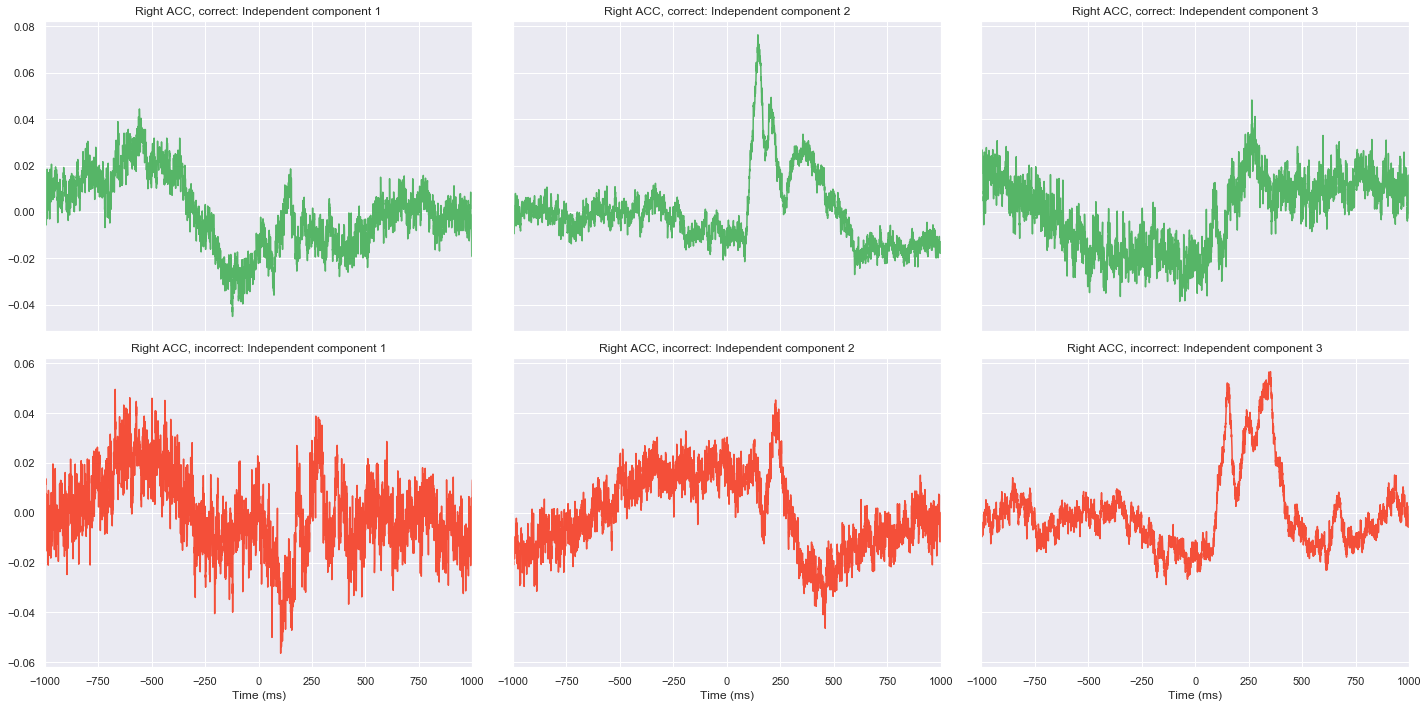

In [396]:
# R. C v I: ICs
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values = electrodesRight, index = ['Trial', 'Time'], aggfunc=np.mean)
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values = electrodesRight, index = ['Trial', 'Time'], aggfunc=np.mean)

correctChannels_averaged = correctChannels.groupby('Time').mean()
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean()

# 4097 x 6 array of average responses at each channel over time
signalsCorrect = np.array([correctChannels.groupby('Time').mean()[elec] for elec in electrodesRight]).T
signalsIncorrect = np.array([incorrectChannels.groupby('Time').mean()[elec] for elec in electrodesRight]).T

# Compute ICA
ica = FastICA(n_components = 3)
signalsCorrect_R = ica.fit_transform(signalsCorrect)
signalsIncorrect_R = ica.fit_transform(signalsIncorrect)

# Plot ICs
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(20,10))

for i, (icC, icI) in enumerate(zip(signalsCorrect_R.T, signalsIncorrect_R.T)):
    ax[0,i].plot(t, icC, color=colours_correct[1])
    ax[0,i].set_title('Right ACC, correct: Independent component {}'.format(i+1))
    
    ax[1,i].plot(t, icI, color=colours_incorrect[1])
    ax[1,i].set_title('Right ACC, incorrect: Independent component {}'.format(i+1))
    ax[1,i].set_xlabel('Time (ms)')
    ax[1,i].set_xlim([-1000,1000])
    
fig.tight_layout()

Here we see the source-decomposed signal from the right ACC for correct and incorrect trials, allowing us to investigate whether there are differences in activity in right ACC sources based on outcome valence.

We can see that following correct trials, there is an early response shown in component 1. This likely represents a population producing the early event response, and activity in a similar time range, but in the opposite direction, is seen in the first component for incorrect trials; this may also therefore represent a valence signal.

The remaining sources show relatively short-lived, blunted responses for correct trials. Following incorrect trials, however, we see much sharper, higher-amplitude, longer-lasting activity. This is consistent with populations in the right ACC responding differently based on outcome, with a much stronger late "error signal" response to incorrect trials.

These results clearly demonstrate that the ACC prediction network responds differently based on outcome. Specifically, we can see that there is an early "event-related" response that is not affected by outcome; this likely represents a signal to indicate the arrival of feedback to the network, in the same way that the late pre-feedback period "primed" the network for input. Following this, there is a "valence-related" signal, which is produced by populations in the left ACC. These centres clearly respond differently to correct and incorrect trials, indicating that they encode valence. There is then a later "error-related" signal. This is produced by centres in the left ACC following an incorrect trial. This is followed by a spike in activity in the right ACC 20ms later, an interval in which we have demonstrated communication earlier.

These results demonstrate a distributed network throughout the ACC that dynamically predicts and responds to outcomes. It anticipates feedback, priming for input, then signals input arrival, followed by valence; when there is a strong negative valence signal, further populations then send an error signal to the right ACC, which produces a spike in activity and a propagation of activity throughout the network. This is consistent with a network that maintains a prediction model to aid decision making, and which updates its predictions based on the error between its predictions and reality.

If our hypothesis is correct, we further expect to see differences in patterns of communication within the ACC network based on outcome, indicating that the network as a whole is behaving differently under different outcome conditions

Text(0.5, 1.0, 'Source-space GC for correct vs. incorrect trials')

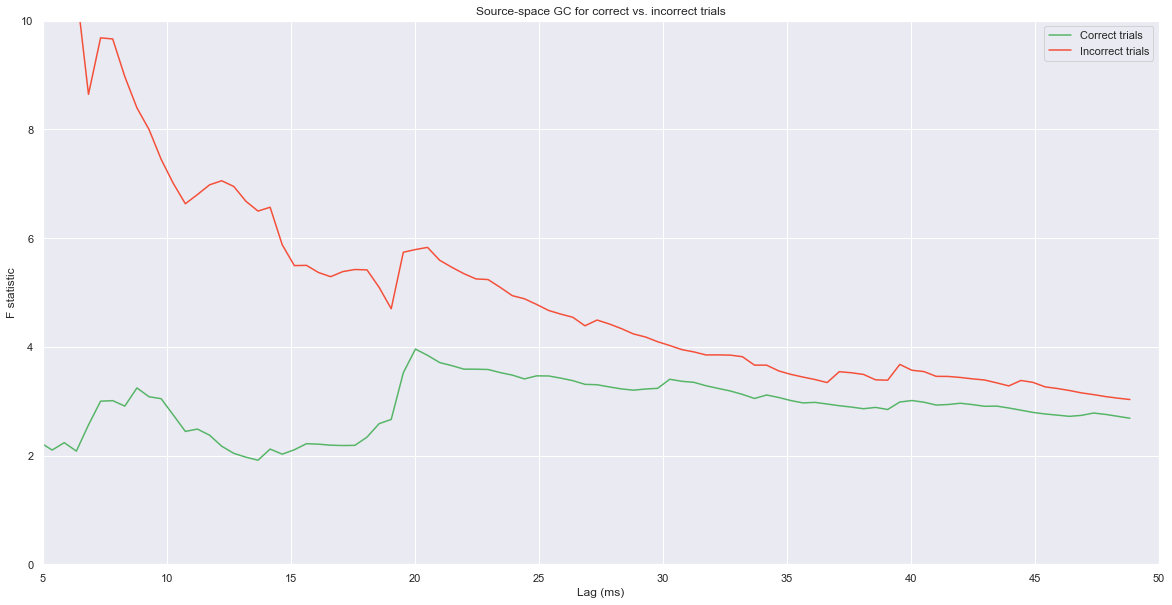

In [430]:
# GC @ post-feedback window w lag + frequency from earlier; C v I
# Source-space GC L->R in window 100ms to 500ms post feedback C v I
# ?also try moving to tighter window around error signal
dataCorrect = np.array([np.diff(signalsCorrect_R.T[1]), np.diff(signalsCorrect_L.T[0])]).T # 1,2 OK / 
dataIncorrect = np.array([np.diff(signalsIncorrect_R.T[0]), np.diff(signalsIncorrect_L.T[1])]).T # 0,1 similar to C1,2 / 

gc_resCorrect = grangercausalitytests(dataCorrect,100,verbose=False)
gc_resIncorrect = grangercausalitytests(dataIncorrect,100,verbose=False)

# Define intervals using t-tests -> test over these intervals over lags
# Choose test statistic & plot this
# Can then take max significance as area of max communication
# Also: demonstrate directionality by reversing
# Can then use these lags & directions for transfer entropy test

# At -150 to 0, early R -> L; L-> R less so, at later lags: bidirectional feedback, differing temporal dynamics
# 150 to 450: L -> R v early; no R -> L

# Can look at whether there is difference in communication C v I (i.e. L v R under conditions of C, I)
# Using intervals & directions already determined, look at whether test statistic plots differ for pre & post (i.e. is causality different with C v I)

FvalsCorrect = [gc_resCorrect[lag][0]['ssr_ftest'][0] for lag in range(1,101)]
FvalsIncorrect = [gc_resIncorrect[lag][0]['ssr_ftest'][0] for lag in range(1,101)]

timepoints = [t * 1000/2048 for t in range(1,101)]

fig,ax = plt.subplots(figsize=(20,10))

ax.plot(timepoints,FvalsCorrect, color=colours_correct[1], label="Correct trials")
ax.plot(timepoints,FvalsIncorrect, color=colours_incorrect[1], label="Incorrect trials")
ax.legend()
ax.set_ylabel('F statistic')
ax.set_xlabel('Lag (ms)')
ax.set_xlim([5, 50])
ax.set_ylim([0, 10])
ax.set_title('Source-space GC for correct vs. incorrect trials')

#print("Step at {0}ms: F = {1}, p = {2}".format(timepoints[np.argmax(FvalsLtoR[12:])+12], np.max(FvalsLtoR[12:]), gc_resLtoR[42][0]['ssr_ftest'][1])) # Add 1 to index of gc_res as lags 1 - 100 (not 0 indexed)
print("Step at {0}ms: F = {1}, p = {2}".format(timepoints[41], FvalsIncorrect[41], gc_resIncorrect[42][0]['ssr_ftest'][1]))

This plot shows Granger causality between left ACC and right ACC populations following source decomposition for correct and incorrect trials. We can see that there is a persistently greater test statistic through the lags tested for incorrect trials, indicating greater left-to-right information flow during incorrect trials, consistent with our hypothesis of a network that is strongly activated by outcomes that deviate from those predicted.

The high values at early time lags are likely a result of the broadly similar activities seen between populations in incorrect trials, indicative of the strongly coordinated activity through the network when outcomes deviate from expectations. This then gradually drops off, although we can still see a clear step in the test statistic; this occurs at 21ms ($F = 5.83, p < 0.0001 \div 100$). This is consistent with the lag at which we have previously shown communication within the ACC network in response to feedback. Notably, this is still present, though at a lower amplitude, during correct trials. This suggests that signalling from the left ACC to the right ACC is still present during correct trials following the valence signal, but that this communication is greater following incorrect trials, where we have demonstrated a large-magnitude "error signal" that is transmitted to the right ACC at a lag of 20ms then propagates through the right ACC; these results are consistent with these findings.

These results demonstrate that the distinct populations that make up the ACC network respond to the nature of outcomes, and that they communicate differently based on this information. This is consistent with a network that predicts outcomes and signals errors to update an internal prediction; here, we see this occurring in transmission of a late "error signal" throughout the ACC network, following a "valence signal" which indicates deviation of the actual outcome from what was predicted.

We have previously demonstrated that individual populations within the ACC network communicate with each other most strongly at a lag of 15ms with a peak frequency of 8-16Hz during the 100ms to 500ms post-feedback window. Based on our demonstration of a distributed network of sourced that modulate their communication based on outcome, we expect to see differences in pairwise connectivity between signals recorded at each electrode between outcome conditions.

In [441]:
# Circle plots, C v I for parameters from earlier - 100ms to 500ms, 15ms lag, 8 - 16Hz
# Separate circles for correct + incorrect
correctChannels = pd.pivot_table(df[df['Outcome']=='Correct'], values=electrodes, index=['Time', 'Trial'])
correctChannels_averaged = correctChannels.groupby('Time').mean()

coherencesCorrect = np.ones([6,6]) # Matrix to fill

# Cycle through each electrode & get coherence with all other electrodes
for row, elec1 in enumerate(electrodes):
    for column, elec2 in enumerate(electrodes):
        f, Cxy = signal.coherence(correctChannels_averaged[elec1][100:500], correctChannels_averaged[elec2][100+15:500+15], fs=2048)
        
        #coherences[row,column] = np.mean(Cxy[:10]) # Use mean over range
        coherencesCorrect[row,column] = Cxy[1] # Use peak value identified
        
colors = [colours_left[0], colours_left[1], colours_left[2], colours_right[0], colours_right[1], colours_right[2]]

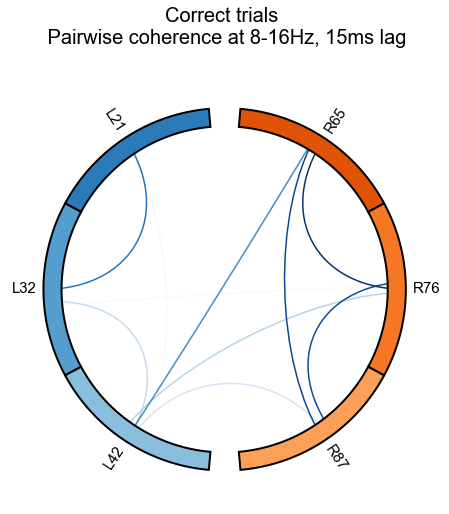

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x24f83219588>)

In [445]:
angles = circular_layout(electrodes, ['L21', 'L32', 'L42', 'R87', 'R76', 'R65'],
                         start_pos=90, start_between=True,
                         group_boundaries=[0, 3], group_sep=10
                        )

plot_connectivity_circle(coherencesCorrect, electrodes,
                         n_lines=10,
                         title="Correct trials \n Pairwise coherence at 8-16Hz, 15ms lag",
                         facecolor="white", textcolor="black", colormap="Blues",
                         node_colors=colors,
                         node_angles=angles,
                         colorbar=False,
                         colorbar_size=0.75, colorbar_pos=(0,0.6), 
                         fontsize_names=15, fontsize_colorbar=15, fontsize_title=20,
                         node_linewidth=2,
                         padding=2
                        )

In [450]:
# Circle plots, C v I for parameters from earlier - 100ms to 500ms, 15ms lag, 8 - 16Hz
# Separate circles for correct + incorrect
incorrectChannels = pd.pivot_table(df[df['Outcome']=='Incorrect'], values=electrodes, index=['Time', 'Trial'])
incorrectChannels_averaged = incorrectChannels.groupby('Time').mean()

coherencesIncorrect = np.ones([6,6]) # Matrix to fill

# Cycle through each electrode & get coherence with all other electrodes
for row, elec1 in enumerate(electrodes):
    for column, elec2 in enumerate(electrodes):
        f, Cxy = signal.coherence(incorrectChannels_averaged[elec1][100:500], incorrectChannels_averaged[elec2][100+15:500+15], fs=2048)
        
        #coherences[row,column] = np.mean(Cxy[:10]) # Use mean over range
        coherencesIncorrect[row,column] = Cxy[1] # Use peak value identified
        
colors = [colours_left[0], colours_left[1], colours_left[2], colours_right[0], colours_right[1], colours_right[2]]

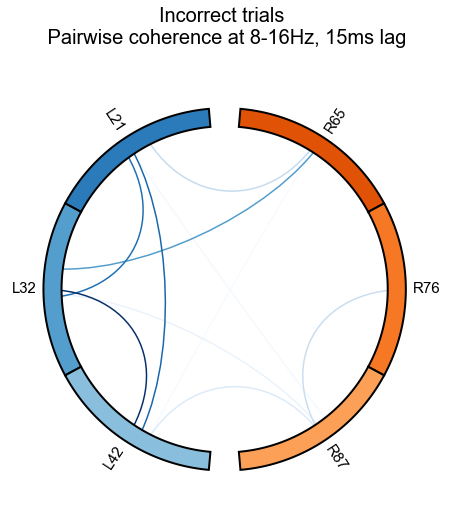

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x24f84c01f88>)

In [453]:
angles = circular_layout(electrodes, ['L21', 'L32', 'L42', 'R87', 'R76', 'R65'],
                         start_pos=90, start_between=True,
                         group_boundaries=[0, 3], group_sep=10
                        )

plot_connectivity_circle(coherencesIncorrect, electrodes,
                         n_lines=10,
                         title="Incorrect trials \n Pairwise coherence at 8-16Hz, 15ms lag",
                         facecolor="white", textcolor="black", colormap="Blues",
                         node_colors=colors,
                         node_angles=angles,
                         colorbar=False,
                         colorbar_size=0.75, colorbar_pos=(0,0.6), 
                         fontsize_names=15, fontsize_colorbar=15, fontsize_title=20,
                         node_linewidth=2,
                         padding=2
                        )

These plots demonstrate the pairwise connectivity between individual electrodes during the 100ms to 500ms post-feedback window we identified earlier, with a lag of 15ms, at 8-16Hz, based on the peak lag and frequency identified in left to right communications in this interval earlier.

We can see that there is a visible difference in the overall pattern of network communication between outcome conditions. This strongly supports our assertion that the ACC network responds differently based on outcome, with its internal pattern of communication between its populations differing depending on whether outcomes deviate from expectations at a timelag we have seen is consistent with communication between network areas.

We can visually that the pattern of communication within the ACC network differs based on outcome. We will now investigate quantitatively whether the overall pattern of network communication differs between conditions. We will do this by decomposing the matrix of pairwise coherence measures into its principal components, identifying the components that account for the most of the variance in network architecture and comparing these. This will allow us to compare the overall network structure between conditions.

In [716]:
# PCA (807, 36) -> (807, 4)
# Label by df.Outcome
# -> can compare & group

# Scale data
scaler = StandardScaler()
scaler.fit(allTrials)
scaledTrials = scaler.transform(allTrials)

pca = PCA(n_components=4)
pca.fit(scaledTrials)

print("Total variance explained: {}".format(np.sum(pca.explained_variance_ratio_)))

coh_pca = pca.transform(scaledTrials)

Total variance explained: 0.34086535388616007


In [717]:
outcomelist = df.Outcome[df['Time']==-1000]

In [718]:
t1 = coh_pca[:,0]
t1C = t1[outcomelist=='Correct']
t1I = t1[outcomelist=='Incorrect']

ttest = stats.ttest_ind(t1C, t1I)
ttest.pvalue

3.829783838439889e-05

By performing a PCA of all trials then extracting correct and incorrect trials, we can compare the first principal components of the network architecture. This first component contains most of the information regarding the network variance; this therefore allows us to compare whether there are global differences in network architecture based on outcome valence.

The results of the statistical test show a statistically significant difference between conditions, indicating that network communication differs globally based on outcome valence. This supports the idea that the network is communicating information relating to the nature of outcomes.